```
import Pyro4.util
try:
    [run your usual rfsoc experiment here]
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))
```

In [1]:
# %matplotlib widget
%matplotlib inline

In [80]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
import json
from scipy.fft import fft, fftfreq
import Pyro4.util

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load experiments

In [81]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

In [82]:
"""Reopen saved data"""
def prev_data(expt_path, filename=None):
    temp_data_file = expt_path
    if filename is not None: temp_data_file = os.path.join(expt_path, filename)
    print(temp_data_file)
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [83]:
expt_path=os.path.join(os.getcwd(), 'data', 'data_240617')
# expt_path = 'C:\_Data\LLqub'
print('Data will be stored in', expt_path)

Data will be stored in s:\Connie\experiments\qramLL_4QR2\data\data_240617


In [84]:
config_file = 'config_q3diamond_full688and638_reset.yml'
# config_file = 'config_q3diamond_full688_reset.yml'
# config_file = 'config_q3diamond.yml'
# config_file = 'config_zcu216.yml'
# config_file = 'config_zcu216_LLStdCandle.yml'
config_path = os.path.join(os.getcwd(), config_file)
print('Config will be', config_path)

Config will be s:\Connie\experiments\qramLL_4QR2\config_q3diamond_full688and638_reset.yml


# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [85]:
import yaml
print('Using config file', config_file)
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

Using config file config_q3diamond_full688and638_reset.yml


In [86]:
# im = InstrumentManager(ns_address='192.168.14.1') # Chicago lab
# im = InstrumentManager(ns_address='192.168.137.1') # SLAC lab
im = InstrumentManager(ns_address='10.108.30.56') # Spilker Fermium
# print(im)
print(im.keys())

dict_keys(['Pyro.NameServer', 'Qick187', 'SC_26C1', 'scqubA', 'scredA', 'scqubB', 'scredB', 'readoutattengrbA', 'readoutattengrbB', 'BNCfungen', 'YOKO4', 'Qick60', 'eHe_4x2_rfsoc', 'YOKO1', 'SC_26C6', 'SC_2FF1', 'SC_20A1'])


In [87]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())


QICK configuration:

	Board: ZCU216

	Software version: 0.2.272
	Firmware timestamp: Mon Jul 24 13:57:32 2023

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (10.256 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (10.256 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 65536 samples (10.256 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 65536 samples (10.256 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=43

In [135]:
lo1 = im[yaml_cfg.aliases.readout_LO]
# lo1 = SignalCore(name="SignalCore", address='10003494')
lo1.open_device()
print(lo1.get_id())

# TURN OFF
lo1.set_standby(True)
lo1.set_output_state(False)

# print(lo1.get_device_status().pll_status.crs_pll_ld)

# # TURN ON
# lo1.set_standby(False)
# lo1.set_output_state(True)
# # lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
# # lo_power = float(yaml_cfg.hw.lo.readout.power)
# lo_freq = 4385.5e6
# lo_power = 14
# lo1.set_frequency(lo_freq) # Set LO frequency
# print(f'set lo freq to {lo_freq*1e-6} MHz')
# lo1.set_power(lo_power) # Set LO power
# print(f'set lo power to {lo_power} dBm')

Default Instrument SC_26C1


0

## Set TWPA parameters

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [165]:
"""
TWPA ON
"""
print('Using config file', config_file)
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

im = InstrumentManager(ns_address='10.108.30.56') # Spilker Fermium

lo_twpa = im[yaml_cfg.aliases.twpa_LO]
# lo_twpa = SignalCore(name="SignalCore", address='10003494')
lo_twpa.open_device()
print(lo_twpa.get_id())

# TURN ON
lo_twpa.set_standby(False)
twpa_freq = float(yaml_cfg.hw.lo.twpa.frequency)
twpa_power = float(yaml_cfg.hw.lo.twpa.power)
# twpa_power = 7.9
# twpa_freq = 8420e6
lo_twpa.set_frequency(twpa_freq) # Set LO frequency
print(f'set twpa pump freq to {twpa_freq*1e-6} MHz')
lo_twpa.set_power(twpa_power) # Set LO power
print(f'set twpa pump power to {twpa_power} dBm')
lo_twpa.set_output_state(True)

Using config file config_q3diamond_full688and638_reset.yml
Default Instrument SC_26C1
set twpa pump freq to 8170.0 MHz
set twpa pump power to -1.0 dBm


0

In [ ]:
"""
TWPA OFF
"""
im = InstrumentManager(ns_address='10.108.30.56') # Spilker Fermium

lo_twpa = im[yaml_cfg.aliases.twpa_LO]
# lo_twpa = SignalCore(name="SignalCore", address='10003494')
lo_twpa.open_device()
print(lo_twpa.get_id())

# TURN OFF
lo_twpa.set_standby(True)
lo_twpa.set_output_state(False)

## Sweep TWPA params

#### Basic power sweep

In [ ]:
print('Using config file', config_file)
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

lo_twpa = im[yaml_cfg.aliases.twpa_LO]
# lo_twpa = SignalCore(name="SignalCore", address='10003494')
lo_twpa.open_device()
print(lo_twpa.get_id())

# # TURN OFF
# lo_twpa.set_standby(True)
# lo_twpa.set_output_state(False)

# TURN ON
lo_twpa.set_standby(False)
lo_twpa.set_output_state(True)


twpa_freq = float(yaml_cfg.hw.lo.twpa.frequency)
lo_twpa.set_frequency(twpa_freq) # Set LO frequency
print(f'set twpa pump freq to {twpa_freq*1e-6} MHz')

power_sweep = np.linspace(7, 9, 40)
# power_sweep = [0]
for pow in power_sweep:
    print(f'set twpa pump power to {pow} dBm')
    lo_twpa.set_power(pow) # Set LO power
    time.sleep(3)


Frequency sweep 

In [ ]:
print('Using config file', config_file)
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

lo_twpa = im[yaml_cfg.aliases.twpa_LO]
# lo_twpa = SignalCore(name="SignalCore", address='10003494')
lo_twpa.open_device()
print(lo_twpa.get_id())

# # TURN OFF
# lo_twpa.set_standby(True)
# lo_twpa.set_output_state(False)

# TURN ON
lo_twpa.set_standby(False)
lo_twpa.set_output_state(True)


twpa_freq = float(yaml_cfg.hw.lo.twpa.frequency)
lo_twpa.set_power(yaml_cfg.hw.lo.twpa.power)
# lo_twpa.set_frequency(twpa_freq) # Set LO frequency
# print(f'set twpa pump freq to {twpa_freq*1e-6} MHz')
print(f'set twpa pump power to {yaml_cfg.hw.lo.twpa.power} dBm')

freq_sweep = np.linspace(8.22, 8.5, 40)*1e9
# power_sweep = [0
for f in freq_sweep:
    print(f'set twpa pump freq to {f*1e-9}')
    lo_twpa.set_frequency(f) # Set LO power
    time.sleep(3)


#### SNR pump freq vs gain
Pump frequency vs readout frequency sweep at fixed pump, readout gain
Calculate SNR with mean over std dev from single shot

In [151]:
print('Using config file', config_file)
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

im = InstrumentManager(ns_address='10.108.30.56') # Spilker Fermium
lo_twpa = im[yaml_cfg.aliases.twpa_LO]
lo_twpa.open_device()
print(lo_twpa.get_id())

# TURN ON
lo_twpa.set_standby(False)
lo_twpa.set_output_state(True)



start_f = 8150
end_f = 8300
step_f = 1*10
# start_f = 8200
# end_f = 8500
# step_f = 1*15
pump_freq_sweep = np.linspace(start_f, end_f, int((end_f-start_f)/step_f + 1))
# pump_freq_sweep = [0]

start_pow = -2.5  # dBm
end_pow = -1
step_pow = 0.3

# power_sweep = [start_pow]
power_sweep = np.linspace(start_pow, end_pow, int((end_pow-start_pow)/step_pow + 1))

# """
# Baseline: TURN OFF TWPA PUMP
# """
# lo_twpa.set_standby(True)
# lo_twpa.set_output_state(False)
# pump_freq_sweep = [9000]
# power_sweep = [0]


print('pump_freq_sweep =', pump_freq_sweep)
print('power_sweep =', power_sweep)
print(f'{len(pump_freq_sweep)} x {len(power_sweep)} = {len(pump_freq_sweep)*len(power_sweep)} points')

Using config file config_q3diamond_full688and638_reset.yml
Default Instrument SC_26C1
pump_freq_sweep = [8150. 8160. 8170. 8180. 8190. 8200. 8210. 8220. 8230. 8240. 8250. 8260.
 8270. 8280. 8290. 8300.]
power_sweep = [-2.5 -2.2 -1.9 -1.6 -1.3 -1. ]
16 x 6 = 96 points


In [152]:
snr = np.zeros(shape=(4, len(pump_freq_sweep), len(power_sweep)))
signal_mat = np.zeros(shape=(4, len(pump_freq_sweep), len(power_sweep)))
noise_mat = np.zeros(shape=(4, len(pump_freq_sweep), len(power_sweep)))
expt = Experiment(
    path=expt_path,
    prefix=f"twpa_calibration",
    config_file=config_path,
)

readout_freqs = [yaml_cfg.device.readout.frequency[qi] - yaml_cfg.device.readout.lo_sideband[qi]*10 for qi in range(4)]
print(readout_freqs)
for ifreq, freq_MHz in enumerate(tqdm(pump_freq_sweep)):

    lo_twpa.set_frequency(freq_MHz*1e6) # Set LO frequency in Hz

    for ipow, pow in enumerate(power_sweep):
        lo_twpa.set_power(pow) # Set LO power

        # if freq_MHz != 8425 or pow != 7.2: continue

        shot = meas.HistogramExperiment(
            soccfg=soc,
            path=expt_path,
            prefix=f"single_shot",
            config_file=config_path,
        )


        shot.cfg.expt = dict(
            reps=2000,
            check_e=False,
            check_f=False,
            # qubit=qi,
            qubit=0, # for mux, automatically measures all 4 qubits (assuming no pulse)
        )
        shot.cfg.device.readout.relax_delay = [200, 200, 200, 200]
        shot.cfg.device.readout.frequency = readout_freqs
        shot.go(analyze=False, display=False, progress=False, save=False)

        for qi in range(4):
            i, q = shot.prog.collect_shots(qi)
            amps = np.abs(i+1j*q)
            signal = np.average(amps)
            noise = np.std(amps)
            signal_mat[qi, ifreq, ipow] = signal
            noise_mat[qi, ifreq, ipow] = noise
            snr[qi, ifreq, ipow] = signal/noise

    #         print(freq_MHz, pow)
    #         print(qi, signal, noise, signal/noise)
    #         plt.figure()
    #         # plt.plot(i, label='i')
    #         # plt.plot(q, label='q')
    #         plt.plot(amps, label='amps')
    #         plt.legend()
    #         plt.show()
    # print(f'snrs at freq {freq_MHz} for all qubits, all power', snr[:, ifreq, :])
expt.cfg = shot.cfg
expt.cfg.expt.qubit = [0, 1, 2, 3]
expt.cfg.power_sweep = power_sweep
expt.cfg.pump_freq_sweep = pump_freq_sweep
expt.data = dict(snr=snr)
expt.data = dict(signal=signal_mat)
expt.data = dict(noise=noise_mat)

[-400.95193842109995, 5784.90833333, 491.288233333334, -239.89577390000008]


100%|██████████| 16/16 [01:58<00:00,  7.40s/it]


max snrs for each qubit [ 6.66085451  5.94274379 13.22592566  5.40261339]
avg best snr for the qubits 7.8080343382396915
Max product SNR: 0.7468888914036499 at index (2, 5)
Operating params: pump freq 8170.0 MHz, pump power -1.0 dBm
SNRs for each qubit at this point [ 5.50038892  4.48962347 11.98115669  5.40261339]


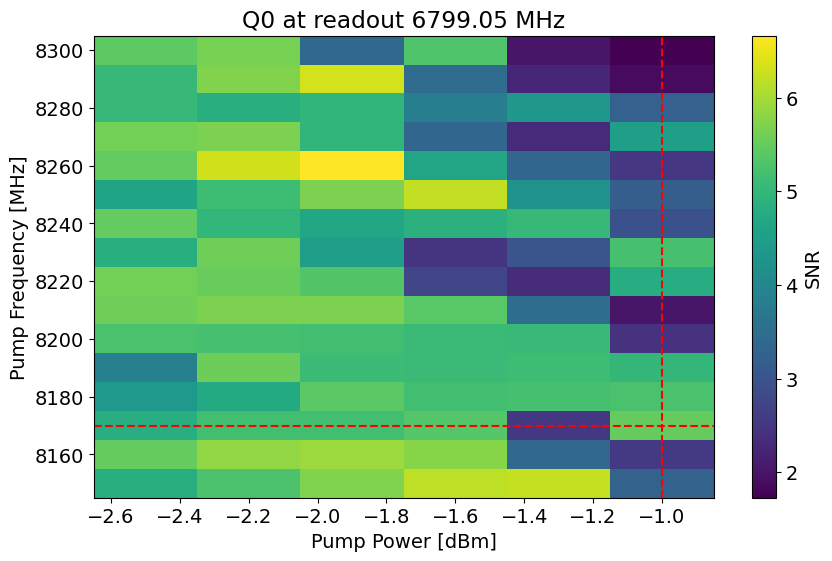

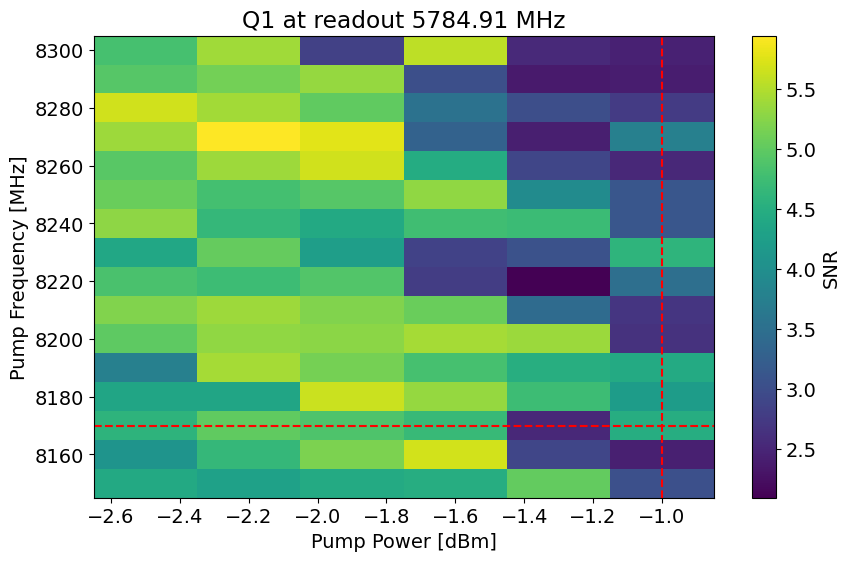

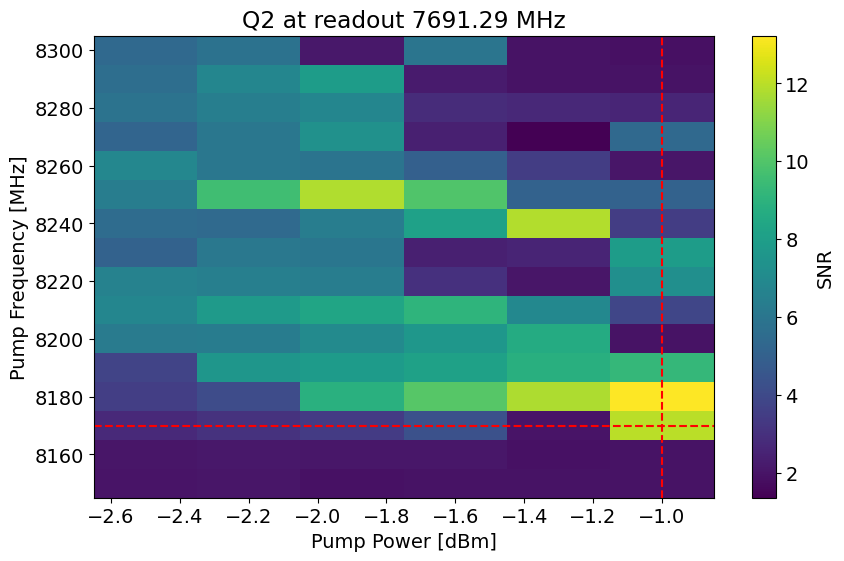

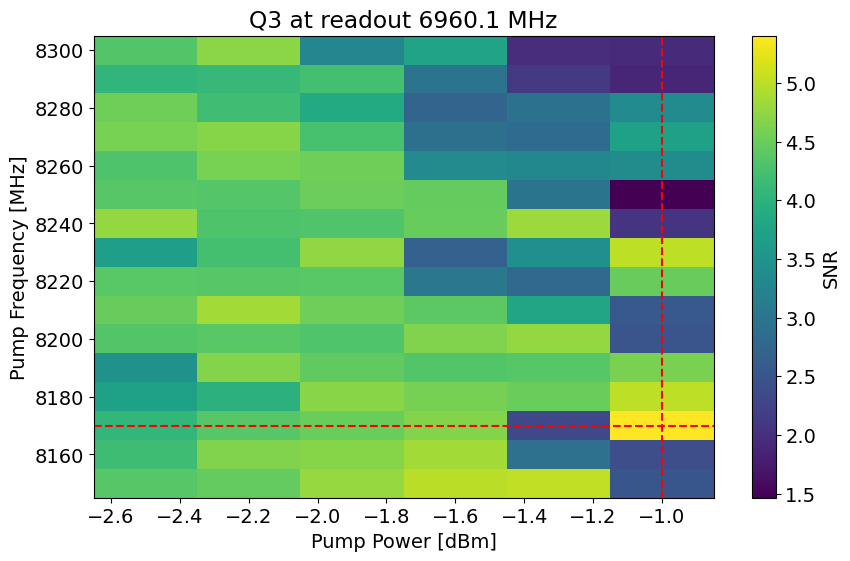

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00004_twpa_calibration.h5


's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00004_twpa_calibration.h5'

In [164]:
readout_freqs = float(yaml_cfg.hw.lo.readout.frequency)*1e-6 + np.array(yaml_cfg.device.readout.lo_sideband)*(np.array(yaml_cfg.hw.soc.dacs.readout.mixer_freq) + np.array(expt.cfg.device.readout.frequency))

# print(snr)
# avg_snr = np.average(snr, axis=0)

"""
More intelligent weighting for getting the average
"""
max_snrs = np.max(snr, axis=(1, 2))
print('max snrs for each qubit', max_snrs)
avg_max_snr = np.average(max_snrs)
print('avg best snr for the qubits', avg_max_snr)
avg_snr = np.ones_like(snr[0])
for qi in range(4):
    # snr_q_bounded = np.min([snr[qi], avg_max_snr * np.ones_like(snr[qi])], axis=0)
    # if qi == 1: continue
    if qi not in [2, 3]: continue
    snr_q_bounded = snr[qi]
    # print('qi', snr_q_bounded)
    avg_snr *= (1-1/snr_q_bounded)

max_ind = np.unravel_index(np.argmax(avg_snr), shape=avg_snr.shape)
max_avg_snr = avg_snr[max_ind]
print(f'Max product SNR: {max_avg_snr} at index {max_ind}')
print(f'Operating params: pump freq {pump_freq_sweep[max_ind[0]]} MHz, pump power {power_sweep[max_ind[1]]} dBm')
print('SNRs for each qubit at this point', snr[:, max_ind[0], max_ind[1]])

for qi in range(4):
    x_sweep = power_sweep
    y_sweep = pump_freq_sweep
    plt.pcolormesh(x_sweep, y_sweep, snr[qi], cmap='viridis', shading='auto')
    # plt.pcolormesh(x_sweep, y_sweep, signal_mat[qi], cmap='viridis', shading='auto')
    # plt.pcolormesh(x_sweep, y_sweep, noise_mat[qi], cmap='viridis', shading='auto')
    plt.ylabel('Pump Frequency [MHz]')
    plt.xlabel('Pump Power [dBm]')
    power_plot = power_sweep[max_ind[1]]
    freq_plot = pump_freq_sweep[max_ind[0]]
    # power_plot = -3.0
    # freq_plot = 8440.5
    plt.axvline(power_plot, linestyle='--', color='r')
    plt.axhline(freq_plot, linestyle='--', color='r')
    plt.colorbar(label='SNR')
    # plt.clim(np.min(snr), avg_max_snr)
    # plt.clim(np.min(snr), np.max(snr))
    plt.title(f'Q{qi} at readout {readout_freqs[qi]:.6} MHz')
    plt.show()

print(f'Saving {expt.fname}')
expt.save_data()


#### Single shot pump freq vs gain
Pump frequency vs readout frequency sweep at fixed pump, readout gain
Calculate readout fidelity from single shot after calibrating qubits

In [ ]:
print('Using config file', config_file)
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

im = InstrumentManager(ns_address='10.108.30.56') # Spilker Fermium
lo_twpa = im[yaml_cfg.aliases.twpa_LO]
# lo_twpa = SignalCore(name="SignalCore", address='10003494')
lo_twpa.open_device()
print(lo_twpa.get_id())

# TURN ON
lo_twpa.set_standby(False)
lo_twpa.set_output_state(True)

start_f = 8200
end_f = 8500
step_f = 5
pump_freq_sweep = np.linspace(start_f, end_f, int((end_f-start_f)/step_f + 1))
# pump_freq_sweep = [0]

start_pow = -4  # dBm
end_pow = -1
step_pow = 0.25

# power_sweep = [start_pow]
power_sweep = np.linspace(start_pow, end_pow, int((end_pow-start_pow)/step_pow + 1))

# """
# Baseline: TURN OFF TWPA PUMP
# """
# lo_twpa.set_standby(True)
# lo_twpa.set_output_state(False)
# pump_freq_sweep = [9000]
# power_sweep = [0]


print('pump_freq_sweep =', pump_freq_sweep)
print('power_sweep =', power_sweep)
print(f'{len(pump_freq_sweep)} x {len(power_sweep)} = {len(pump_freq_sweep)*len(power_sweep)} points')

In [ ]:
fids = np.zeros(shape=(4, len(pump_freq_sweep), len(power_sweep)))
expt = Experiment(
    path=expt_path,
    prefix=f"twpa_calibration_fids",
    config_file=config_path,
)

In [ ]:
expt.cfg.power_sweep = power_sweep
expt.cfg.pump_freq_sweep = pump_freq_sweep

while 0 in fids: # in case of error, continue from where it left off
    try:
        for ifreq, freq_MHz in enumerate(tqdm(pump_freq_sweep)):
            im = InstrumentManager(ns_address='10.108.30.56') # Spilker Fermium
            lo_twpa = im[yaml_cfg.aliases.twpa_LO]
            # lo_twpa = SignalCore(name="SignalCore", address='10003494')
            lo_twpa.open_device()
            lo_twpa.set_frequency(freq_MHz*1e6) # Set LO frequency in Hz
            for ipow, pow in enumerate(power_sweep):
                lo_twpa.set_power(pow) # Set LO power
                for qi in range(4):
                # for qi in range(1):
                    if fids[qi, ifreq, ipow] != 0: continue
                    shot = meas.HistogramExperiment(
                        soccfg=soc,
                        path=expt_path,
                        prefix=f"single_shot_qubit{qi}",
                        config_file=config_path,
                    )

                    shot.cfg.expt = dict(
                        reps=15000,
                        check_e=True,
                        check_f=False,
                        qubit=qi,
                    )
                    shot.go(analyze=False, display=False, progress=False, save=False)
                    shot.analyze(verbose=False)
                    fids[qi, ifreq, ipow] = 100*shot.data['fids'][0]
                    expt.cfg = shot.cfg
                    expt.cfg.expt.qubit = [0, 1, 2, 3]
                    expt.data = dict(fids=fids)
                    expt.save_data() # save after every loop
    except Exception as e:
        print(e)
        continue

In [ ]:
# TESTING
expt = meas.Experiment(config_file=config_path)
temp_data, attrs = prev_data('s:\Connie\experiments\qramLL_4QR2\data\data_240508\\00000_twpa_calibration_fids.h5')
expt.data = temp_data
expt.cfg = AttrDict(attrs['config'])
fids = expt.data['fids']

"""
More intelligent weighting for getting the average
"""
max_fids = np.max(fids, axis=(1, 2))
print('max fids for each qubit', max_fids)
avg_max_fid = np.average(max_fids)
print('avg best fid for the qubits', avg_max_fid)
avg_fid = np.ones_like(fids[0])
for qi in range(4):
    fid_q_bounded = np.min([fids[qi], avg_max_fid * np.ones_like(fids[qi])], axis=0)
    # fid_q_bounded = fids[qi]
    # print('qi', fid_q_bounded)
    # if qi == 1: continue
    avg_fid *= fid_q_bounded

max_ind = np.unravel_index(np.argmax(avg_fid), shape=avg_fid.shape)
max_avg_fid = avg_fid[max_ind]
print(f'Max product fid: {max_avg_fid} at index {max_ind}')
print(f'Operating params: pump freq {pump_freq_sweep[max_ind[0]]} MHz, pump power {power_sweep[max_ind[1]]} dBm')
print('fids for each qubit at this point', fids[:, max_ind[0], max_ind[1]])

for qi in range(4):
    x_sweep = power_sweep
    y_sweep = pump_freq_sweep
    plt.pcolormesh(x_sweep, y_sweep, fids[qi], cmap='viridis', shading='auto')
    plt.ylabel('Pump Frequency [MHz]')
    plt.xlabel('Pump Power [dBm]')
    power_plot = power_sweep[max_ind[1]]
    freq_plot = pump_freq_sweep[max_ind[0]]
    # power_plot = -3.0
    # freq_plot = 8440.5
    plt.axvline(power_plot, linestyle='--', color='r')
    plt.axhline(freq_plot, linestyle='--', color='r')
    plt.colorbar(label='$F_{ge}$')
    # plt.clim(np.min(fids), avg_max_fid)
    # plt.clim(np.min(fids), np.max(fids))
    plt.title(f'Q{qi}')
    plt.show()

print(f'Saving {expt.fname}')
expt.save_data()


# Qubit/resonator to probe

In [254]:
qubit_i = 3
print(qubit_i)

3


# RFSoC Calibration

In [ ]:
tof = meas.ToFCalibrationExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"adc_trig_offset_calibration_qubit{qubit_i}",
    config_file=config_path,
)

tof.cfg.expt = dict(
    pulse_length=1.0, # [us]
    readout_length=1.5, # [us]
    trig_offset=0, # [clock ticks]
    gain=tof.cfg.device.readout.gain[qubit_i],
    # gain=30000, # [MUX units: -1 to 1]
    frequency=tof.cfg.device.readout.frequency[qubit_i]+10, # [MHz]
    reps=1000, # Number of averages per point
    # qubit=qubit_i,
    qubit=qubit_i,
)
tof.cfg.device.readout.relax_delay=10 # wait time between experiments [us]
print(tof.cfg)

import Pyro4.util
try:
    tof.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
print('qubit_i', qubit_i)
print(np.average(tof.data['amps'][135:390]), '+/-', np.std(tof.data['amps'][135:390]))
tof.display(adc_trig_offset=145)

In [ ]:
print(514/55)
print(86/19)

In [ ]:
tof.save_data()

## Misc pulses testing

In [ ]:
prog = meas.MiscPulsesExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"misc_pulses",
    config_file=config_path,
)

prog.cfg.expt = dict(
    reps=10000,
    rounds=1000000,
)
prog.cfg.device.readout.relax_delay=10 # wait time between experiments [us]
print(prog.cfg)

import Pyro4.util
try:
    prog.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
print('qubit_i', qubit_i)
print(np.average(tof.data['amps'][135:390]), '+/-', np.std(tof.data['amps'][135:390]))
tof.display(adc_trig_offset=135)

## Photon pump calibration

In [ ]:
qubit_i = 1

In [ ]:
loop_prog = meas.PhotonPumpLoopCalibrationExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"photon_pump_loop_qubit{qubit_i}",
    config_file=config_path,
)

loop_prog.cfg.expt = dict(
    pulse_length=50.0, # [us]
    readout_length=50.0, # [us]
    trig_offset=135, # [clock ticks]
    gain=800, #1800, # for calibrated photon pump 
    reps=100000000, # Number of averages per point
    # qubit=qubit_i,
    qubit=qubit_i,
)

loop_prog.cfg.hw.soc.dacs.readout.nyquist = 2

loop_prog.cfg.device.readout.relax_delay = 10 # wait time between experiments [us]
# loop_prog.cfg.device.readout.frequency[qubit_i] -= 0.1
print(loop_prog.cfg)

import Pyro4.util
try:
    loop_prog.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
print('qubit_i', qubit_i)
print(loop_prog.prog.di_buf)
for axis in ['amps', 'i', 'q']:
    signal = np.average(loop_prog.data[axis][:]) 
    noise = np.std(loop_prog.data[axis][:])
    print(axis, 'signal', signal, '+/-', noise)
    print(axis, 'snr', signal / noise)
loop_prog.display()

In [ ]:
tof.save_data()

In [ ]:
950+5925

# Resonator spectroscopy

## Single tone (resonator) spectroscopy

Measures the resonant frequency of the readout resonator when the qubit is in its ground state: sweep readout pulse frequency and look for the frequency with the maximum measured amplitude.

The resonator frequency should be stored in the parameter <code>cfg.device.readouti.frequency</code>.

Note that harmonics of the clock frequency (6144 MHz) will show up as "infinitely"  narrow peaks!


In [42]:
qubit_i = 3

In [49]:
rspec = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span = 5.0 # MHz
npts = 250
rspec.cfg.expt = dict(
    start=rspec.cfg.device.readout.frequency[qubit_i]-span/2, # resonator frequency to be mixed up [MHz]
    # start=rspec.cfg.device.readout.frequency[qubit_i]-0.75*span, # resonator frequency to be mixed up [MHz]
    # start=-807-span/2, # resonator frequency to be mixed up [MHz]
    # start=rspec.cfg.device.readout.frequency[qubit_i]-0.75*span,
    # start=rspec.cfg.device.readout.frequency[qubit_i]-0.25*span,
    # start=-850,
    step=span/npts, # min step ~1 Hz
    expts=npts, # Number experiments stepping from start
    reps=500, # Number averages per point
    pulse_e=False, # add ge pi pulse prior to measurement
    pulse_f=False, # add ef pi pulse prior to measurement
    qubit=qubit_i,
)

rspec.cfg.device.readout.gain[qubit_i] = 0.5
# rspec.cfg.device.readout.frequency[qubit_i] = 822.2138666666668
# rspec.cfg.device.readout.readout_length = 2

# Wait time between experiments [us]
if not rspec.cfg.expt.pulse_e: rspec.cfg.device.readout.relax_delay = 20

print(rspec.cfg)
rspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-390.95193842109995, 5794.90833333, 501.288233333334, -229.94910723], 'frequency_ef': [-392.9315036040767, 5794.925333329999, 499.41074988962544, -231.37577390000007], 'gain': [0.25, 0.3, 0.85, 0.5], 'readout_length': [8.0, 10.0, 7.0, 6.0], 'readout_length_ef': [8.0, 7.0, 4.0, 4.0], 'relax_delay': 20}, 'qubit': {'f_ge': [4110.42834951, 3448.19703452, 4762.18199758, 4381.650168813355], 'f_ef': [3884.3809607535322, 3347.761789059698, 4572.363929531337, 4209.91711365584], 'f_Q1_ZZ': [3442.909184486008, 0, 3447.0924878770584, 3446.9608452525486], 'f_Q_ZZ1': [4104.8259754819555, 0, 4761.14068386677, 4380.292188886469], 'f_ef_Q_ZZ1': [0, 0, 4570.466450039196, 4207.199191279], 'f_EgGf': [2686.53594683, 0, 2017.3, 2414.92850999], 'f_EgGf_Q': [0, 0, 5883.9, 5146.885], 'f_f0g1': [1184.4, 999.8, 1632.9833333333333, 1620.9166666666665], 'gs': [52.40296404695958, 54.81794456602636, 43.49513117058557, 4.9306533524

  0%|          | 0/250 [00:00<?, ?it/s]

electrical delay phase correction (no mux support) (deg) 1.696027597443062
[6970.040892769999, 34850.204463849994, 34850.204463849994, 0, 0.015033377328391242, 0]
Attempted to init fitparam 5 to 0, which is out of bounds 0 to 1.0085864998345067. Instead init to 0.5042932499172533
[6.97006576e+03 5.35712263e+04 4.21643928e+04 3.04408245e-01
 2.25500660e-02 5.55404492e-27]

Freq with minimum transmission: -229.92910723
Freq with maximum transmission: -227.66910723
From fit:
	f0: 6970.065760363215
	Qi: 53571.22626552785 	 kappa_i/2pi: 0.13010838553173706
	Qe: 42164.392767902085 	 kappa_e/2pi: 0.1653069166377091
	Q0: 23594.125656921053
	kappa [MHz]: 0.29541530216944617
	phi [radians]: 0.3044082445087055
baseline 1273.012266899618


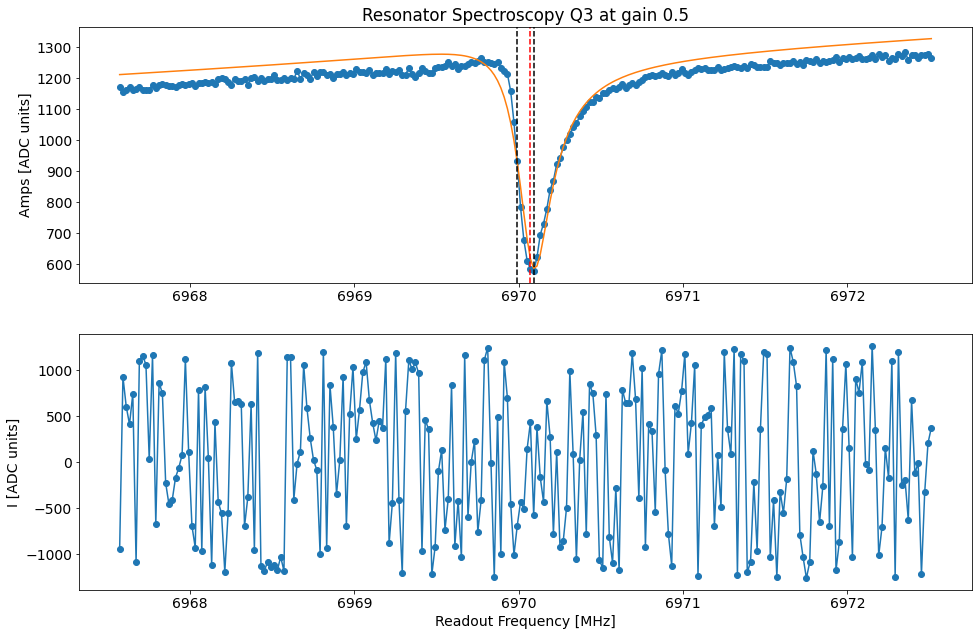

In [50]:
# # TESTING
# rspec = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# # temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit1.h5')
# temp_data, attrs = prev_data(expt_path, '00000_power_sweep_resonator_spectroscopy_qubit0.h5')
# i_gain = np.argmin(np.abs(temp_data['gainpts']-30))
# temp_data['amps'] = temp_data['amps'][i_gain][80:]
# temp_data['xpts'] = temp_data['xpts'][80:]
# data = rspec.analyze(data=temp_data, fit=True)
# rspec.display(data=data, fit=True)

data = rspec.analyze(fit=True, findpeaks=False)
rspec.display(data=data, fit=True, findpeaks=False)

In [ ]:
rspec.save_data()

Repeat res spec over time

In [ ]:
qubit_i = 2

In [ ]:
import time

rspecs = []

drift_meas_time = 3*60

start_time = time.time()
elapsed_time = 0
meas_times = []

freq = rspec.cfg.device.readout.frequency[qubit_i]
print('readout freq', freq)

for i in tqdm(range(100)):
# for i in tqdm(range(3)):
    rspec = meas.ResonatorSpectroscopyExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"resonator_spectroscopy_qubit{qubit_i}",
        config_file=config_path,
    )

    span = 0.0 # MHz
    npts = 1
    # arduino.set_voltage(channel=4, voltage=0.0104)
    rspec.cfg.expt = dict(
        start=freq, # resonator frequency to be mixed up [MHz]
        step=span/npts, # min step ~1 Hz
        expts=npts, # Number experiments stepping from start
        reps=500, # Number averages per point
        pulse_e=True, # add ge pi pulse prior to measurement
        pulse_f=False, # add ef pi pulse prior to measurement
        qubit=qubit_i,
    )

    # rspec.cfg.device.readout.gain[qubit_i] = 0.20
    # rspec.cfg.device.readout.frequency[qubit_i] = 824.7980472489251
    # rspec.cfg.device.readout.readout_length = 2.5

    if rspec.cfg.expt.pulse_e: rspec.cfg.device.readout.relax_delay = 500 # Wait time between experiments [us]
    else: rspec.cfg.device.readout.relax_delay = 20 # Wait time between experiments [us]

    # print(rspec.cfg)
    rspec.go(analyze=False, display=False, progress=False, save=False)
    rspecs.append(rspec)


    meas_times.append(elapsed_time)
    if elapsed_time > drift_meas_time: break
    # time.sleep(30)

In [ ]:
amp_freq = []
ampi_freq = []
ampq_freq = []
for rspec in rspecs:
    xpts = rspec.data['xpts']
    freq_loc = np.argmin(np.abs(xpts-rspec.cfg.device.readout.frequency[qubit_i]))
    amp_freq.append(rspec.data['amps'][freq_loc])
    ampi_freq.append(rspec.data['avgi'][freq_loc])
    ampq_freq.append(rspec.data['avgq'][freq_loc])
    # data = rspec.analyze(fit=True, findpeaks=False)
    # rspec.display(data=data, fit=False, findpeaks=False)

print('average', np.mean(amp_freq), '+/-', np.std(amp_freq))
plt.plot(amp_freq)
plt.ylabel('Amplitude at measurement frequency')
plt.xlabel('Iteration')
plt.title(f'Readout Amplitude of Q{qubit_i} in {"e" if rspec.cfg.expt.pulse_e else "g"} (readout gain {rspec.cfg.device.readout.gain[qubit_i]})')
plt.show()

plt.plot(ampi_freq)
plt.ylabel('I at measurement frequency')
plt.xlabel('Iteration')
plt.title(f'Readout Amplitude of Q{qubit_i} in {"e" if rspec.cfg.expt.pulse_e else "g"} (readout gain {rspec.cfg.device.readout.gain[qubit_i]})')
plt.show()

plt.plot(ampq_freq)
plt.ylabel('Q at measurement frequency')
plt.xlabel('Iteration')
plt.title(f'Readout Amplitude of Q{qubit_i} in {"e" if rspec.cfg.expt.pulse_e else "g"} (readout gain {rspec.cfg.device.readout.gain[qubit_i]})')
plt.show()

## Power sweep resonator spectroscopy

Repeat resonator spectroscopy at a range of powers to check that resonator frequency shifts at low powers. (Check qubit is alive.)

Use this experiment to determine the appropriate resonator gain, which should be stored in <code>cfg.device.readout.gain</code>


In [360]:
qubit_i = 3

In [363]:
rpowspec = meas.ResonatorPowerSweepSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"power_sweep_resonator_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span_f = 1.0
npts_f = 100

# span_gain = 0.95
span_gain = 0.5
npts_gain = 10

rpowspec.cfg.expt = dict(
    # start_f=rpowspec.cfg.device.readout.frequency[qubit_i]+span_f*0.9, # sweep frequency [MHz]
    start_f=rpowspec.cfg.device.readout.frequency[qubit_i]-span_f*0.5, # sweep frequency [MHz]
    step_f=span_f/npts_f, # min step ~1 Hz
    expts_f=npts_f, # Number experiments stepping freq from start
    # start_gain=rpowspec.cfg.device.readout.gain[qubit_i], # Gain sweep start [DAC units]
    start_gain=0.01,
    # start_gain=0.2,
    step_gain=span_gain/npts_gain, # Gain step size
    # step_gain=0, # Gain step size
    expts_gain=npts_gain+1, # Number experiments stepping gain from start
    reps=400, # Number averages per point
    pulse_e=False, # add ge pi pulse before measurement
    pulse_f=False, # add ef pi pulse before measurement
    qubit=qubit_i,
)
rpowspec.cfg.device.readout.relax_delay = 25 # Wait time between experiments [us]
# rpowspec.cfg.device.readout.readout_length = 3

print(rpowspec.cfg)

rpowspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-390.95193842109995, 5794.90833333, 501.288233333334, -229.87577390000007], 'frequency_ef': [-392.9315036040767, 5794.925333329999, 499.41074988962544, -231.37577390000007], 'gain': [0.25, 0.3, 0.85, 0.35], 'readout_length': [8.0, 10.0, 8.0, 6.0], 'readout_length_ef': [8.0, 7.0, 4.0, 6.0], 'relax_delay': 25}, 'qubit': {'f_ge': [4110.1917594510205, 3448.2684746433115, 4762.249073987997, 4381.601838787919], 'f_ef': [3884.967202697702, 3347.761789059698, 4572.328169162723, 4209.612874544659], 'f_Q1_ZZ': [3442.909184486008, 0, 3447.0924878770584, 3446.9608452525486], 'f_Q_ZZ1': [4104.8259754819555, 0, 4761.14068386677, 4380.292188886469], 'f_EgGf': [2686.53594683, 0, 2017.3, 2414.92850999], 'f_EgGf_Q': [0, 0, 5884.159166666667, 5146.885], 'f_f0g1': [1184.0166666666667, 999.9, 1632.9333333333334, 1620.5666666666666], 'gs': [52.40296404695958, 54.81794456602636, 43.49513117058557, 4.930653352423196, 2.6415

  0%|          | 0/11 [00:00<?, ?it/s]

qubit 3


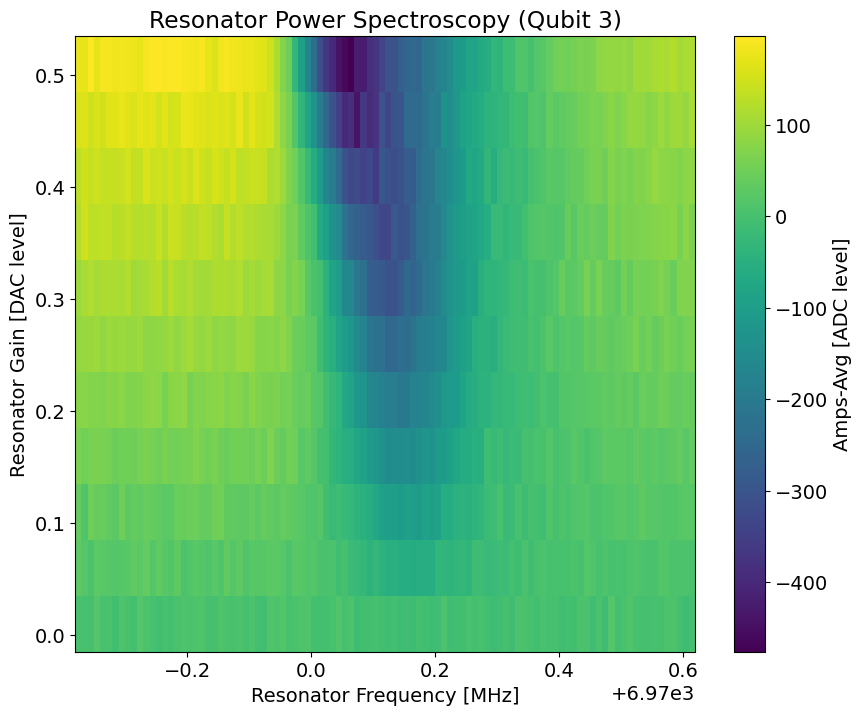

plotting at gain 0.46 index 9


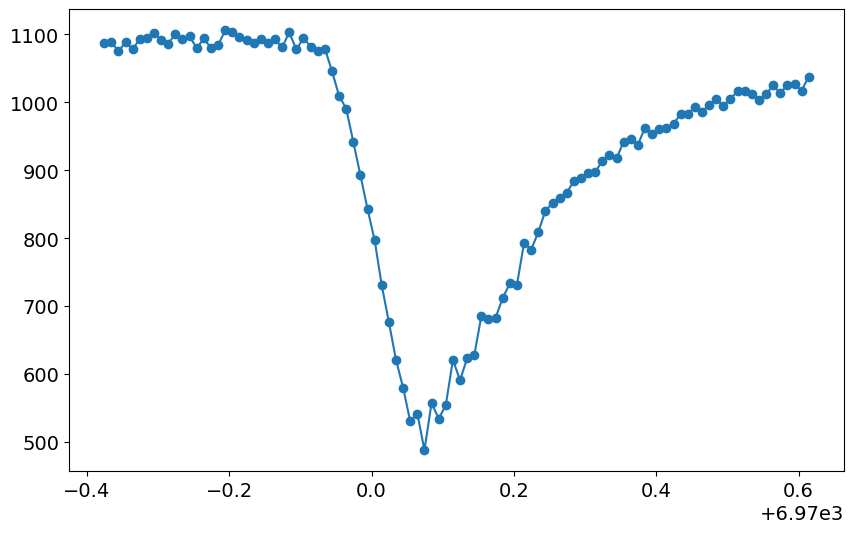

In [366]:
# # TESTING
# rpowspec = meas.ResonatorPowerSweepSpectroscopyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_power_sweep_resonator_spectroscopy_qubit1.h5')
# rpowspec.display(data=temp_data, fit=False)

print('qubit', rpowspec.cfg.expt.qubit)
rpowspec.analyze(fit=False, lowgain=None, highgain=None)
rpowspec.display(fit=False, select=0.45)

In [ ]:
rpowspec.save_data()

# Qubit ge spectroscopy

## Pulse Probe (qubit) spectroscopy

Measures the qubit frequency f_ge by driving at resonator frequency and sweeping qubit frequency.

Qubit frequency should be stored in <code>cfg.qubiti.f_ge</code>.

In [24]:
qubit_i = 3

In [51]:
qspec = meas.PulseProbeSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

# span = 2.5
# npts = 400

# span = 1.1*2*20 * 1.1
# npts = 500

span = 20
npts = 100

chi = 1.1

qspec.cfg.expt = dict(
    start=qspec.cfg.device.qubit.f_ge[qubit_i] - span/2, # [MHz]
    # start=4108-span/2,
    # start=qspec.cfg.device.qubit.f_ge[qubit_i] - 0.9*span, # [MHz]
    # start=qspec.cfg.device.qubit.f_ge[qubit_i] - 3*chi - 0.5*span, # [MHz]
    # start=4780,
    step=span/npts, # min step ~1 MHz
    expts=npts, # Number of experiments stepping from start
    reps=100, # Number of averages per point
    rounds=10, # Number of start to finish sweeps to average over
    length=30, # Qubit probe constant pulse length [us]
    gain=25, # Qubit pulse gain
    # length=7.5, # Qubit probe constant pulse length [us]
    # gain=int(900), # Qubit pulse gain
    # gain=int(3869/150), # Qubit pulse gain
    # pulse_type='flat_top',
    pulse_type='const',
    qubit=qubit_i,
)
print('start', qspec.cfg.expt.start, 'stop', qspec.cfg.expt.start+qspec.cfg.expt.step*qspec.cfg.expt.expts, 'npts', qspec.cfg.expt.expts)
qspec.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]
# qspec.cfg.device.readout.relax_delay = 3 # Wait time between experiments [us]
# qspec.cfg.device.readout.frequency[qubit_i] = qspec.cfg.device.readout.frequency[qubit_i] - 1.1
# qspec.cfg.device.readout.gain[qubit_i] = 0.8

# qspec.cfg.device.readout.gain[qubit_i] = 0.18
# qspec.cfg.device.readout.readout_length[qubit_i] = 1

print(qspec.cfg)

qspec.go(analyze=False, display=False, progress=True, save=False)

start 4371.650168813355 stop 4391.650168813355 npts 100
{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-390.95193842109995, 5794.90833333, 501.288233333334, -229.94910723], 'frequency_ef': [-392.9315036040767, 5794.925333329999, 499.41074988962544, -231.37577390000007], 'gain': [0.25, 0.3, 0.85, 0.35], 'readout_length': [8.0, 10.0, 7.0, 6.0], 'readout_length_ef': [8.0, 7.0, 4.0, 4.0], 'relax_delay': 100}, 'qubit': {'f_ge': [4110.42834951, 3448.19703452, 4762.18199758, 4381.650168813355], 'f_ef': [3884.3809607535322, 3347.761789059698, 4572.363929531337, 4209.91711365584], 'f_Q1_ZZ': [3442.909184486008, 0, 3447.0924878770584, 3446.9608452525486], 'f_Q_ZZ1': [4104.8259754819555, 0, 4761.14068386677, 4380.292188886469], 'f_ef_Q_ZZ1': [0, 0, 4570.466450039196, 4207.199191279], 'f_EgGf': [2686.53594683, 0, 2017.3, 2414.92850999], 'f_EgGf_Q': [0, 0, 5883.9, 5146.885], 'f_f0g1': [1184.4, 999.8, 1632.9833333333333, 1620.9166666666665], 'gs': [52.40296404

  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4381.497156692669, HWHM 0.7620629677761969
Found peak in I at [MHz] 4381.515452408491, HWHM 0.9173432335043301
Found peak in Q at [MHz] 4381.516290098799, HWHM 0.9795605745345045


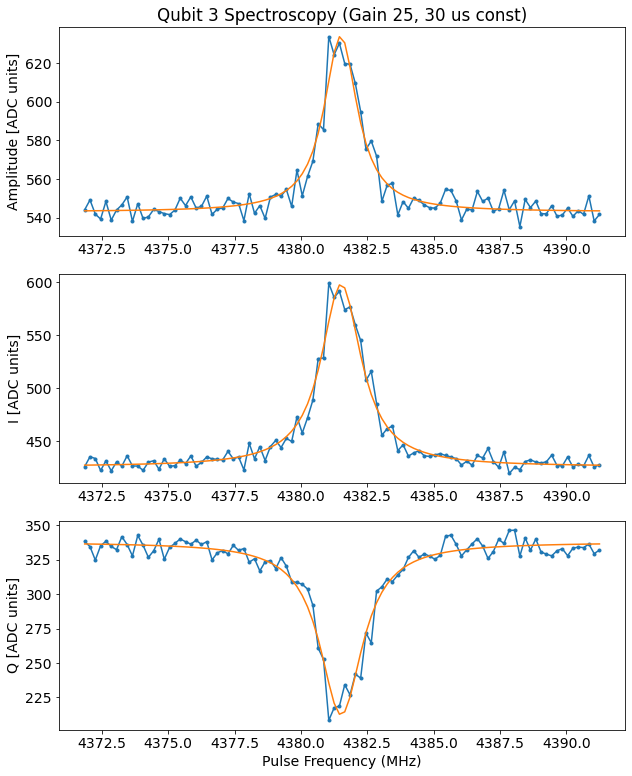

In [52]:
# TESTING
# qspec = meas.PulseProbeSpectroscopyExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_qubit_spectroscopy_qubit2.h5')
# qspec.data = temp_data
# qspec.cfg = AttrDict(attrs['config'])
# data = qspec.analyze(data=temp_data, fit=True)
# qspec.display(data=data, fit=True)

qspec.analyze(fit=True, signs=[1, -1, 1])
qspec.display(fit=True, signs=[1, -1, 1])

In [ ]:
qspec.data['fit_amps']

In [ ]:
qspec.save_data()

## Photon counting

In [ ]:
qubit_i = 0

In [ ]:
qspec = meas.PhotonCountingExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"photon_counting_{qubit_i}",
    config_file=config_path,
)

# span = 3.0
# npts = 300

span = 3.5
npts = 400

qspec.cfg.expt = dict(
    # start=qspec.cfg.device.qubit.f_ge[qubit_i]-span/2, # [MHz]
    start=qspec.cfg.device.qubit.f_ge[qubit_i]-0.9*span, # [MHz]
    step=span/npts,
    expts=npts, # Number of experiments stepping from start
    reps=400, # Number of averages per point
    rounds=80, # Number of start to finish sweeps to average over
    length=25, # Qubit probe constant pulse length [us]
    gain=int(400), # Qubit pulse gain
    pulse_type='flat_top',
    pump_gain=800,
    pump_length=5+25, # total length of readout pump tone
    offset=5, # delay start of qubit pulse from start of pump; -1 indicates to start qubit pulse at end of pump
    meas_delay=4*1/0.1, # delay before resonator measurement tone (ensure not to punch out)
    qubit=qubit_i,
)

qspec.cfg.device.readout.relax_delay = 40 # Wait time between experiments [us]
# qspec.cfg.device.readout.relax_delay = 3 # Wait time between experiments [us]
# qspec.cfg.device.readout.frequency[qubit_i] = -813.508 # Wait time between experiments [us]
# qspec.cfg.device.readout.gain[qubit_i] = 0.35
# qspec.cfg.device.readout.readout_length[qubit_i] = 60

print(qspec.cfg)

qspec.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# x = np.linspace(0, 1, 100)
x = qspec.data['xpts']
y0=2
yscale=2
x0=0.9
xscale=0.1
nbar=1
chi=0.2
# plt.plot(x, meas.fitting.nlorfunc(x, 3, y0, yscale, x0, xscale, nbar, chi))
plt.plot(x, meas.fitting.nlorfunc(x, 3, 15953.425355284104, 847.089185965473, 3449.8207632671583, 0.3491250000000036/2, 0.5, 0.5))

In [ ]:
# TESTING
qspec = meas.PhotonCountingExperiment(config_file=config_path,)
temp_data, attrs = prev_data('s:\Connie\experiments\qramLL_4QR2\data\data_240508\\00000_photon_counting_1.h5')
qspec.data = temp_data
qspec.cfg = AttrDict(attrs['config'])
# temp_data['avgi'] = temp_data['amps']
# data = qspec.analyze(data=temp_data, fit=True)
# qspec.display(data=data, fit=True)

print(qspec.cfg.expt)
signs = [1, -1, 1]
qspec.analyze(fit=True, npeaks=4, chi=0.7, signs=signs, search_span=0.35)
qspec.display(fit=True, npeaks=4, signs=signs)

In [ ]:
# TESTING
qspec = meas.PhotonCountingExperiment(config_file=config_path,)
temp_data, attrs = prev_data('s:\Connie\experiments\qramLL_4QR2\data\data_240405\\00010_photon_counting_0.h5')
qspec.data = temp_data
qspec.cfg = AttrDict(attrs['config'])
print(qspec.cfg.expt.rounds, qspec.cfg.expt.reps)
data = qspec.analyze(data=temp_data, fit=False)
qspec.display(data=data, fit=False)


In [ ]:
qspec.save_data()

### Loop over photon counting experiments

In [ ]:
qubit_i = 3

In [ ]:
pump_gain_sweep = np.linspace(0.01*32000, 0.08*32000, 5)[2:]
print('pump gain sweep', pump_gain_sweep)

In [ ]:
for i_gain, pump_gain in enumerate(pump_gain_sweep):
    qspec = meas.PhotonCountingExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"photon_counting_{qubit_i}",
        config_file=config_path,
    )
    
    # span = 2.5
    # npts = 400
    
    span = 3.0
    npts = 300
    
    qspec.cfg.expt = dict(
        start=qspec.cfg.device.qubit.f_ge[qubit_i]-0.9*span, # [MHz]
        step=span/npts, # min step ~1 MHz
        expts=npts, # Number of experiments stepping from start
        reps=200, # Number of averages per point
        rounds=20*(i_gain+1), # Number of start to finish sweeps to average over
        length=20, # Qubit probe constant pulse length [us]
        gain=int(200), # Qubit pulse gain
        pulse_type='flat_top',
        qubit=qubit_i,
        pump_gain=int(pump_gain),
        pump_length=5+20, # total length of readout pump tone
        offset=5, # delay start of qubit pulse from start of pump; -1 indicates to start qubit pulse at end of pump
        meas_delay=4*1/0.2,
    )
    print('reps', qspec.cfg.expt.reps, 'rounds', qspec.cfg.expt.rounds)
    
    qspec.cfg.device.readout.relax_delay = 50 # Wait time between experiments [us]
    # qspec.cfg.device.readout.relax_delay = 3 # Wait time between experiments [us]
    # qspec.cfg.device.readout.frequency[qubit_i] = -813.508 # Wait time between experiments [us]
    # qspec.cfg.device.readout.gain[qubit_i] = 0.35
    # qspec.cfg.device.readout.readout_length[qubit_i] = 60

    qspec.go(analyze=False, display=False, progress=True, save=False)
    qspec.analyze(fit=True, npeaks=3, chi=0.5)
    qspec.display(fit=True, npeaks=3)
    qspec.save_data()

In [ ]:
# TESTING
# qspec = meas.PhotonCountingExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_photon_counting_0.h5')
# qspec.data = temp_data
# qspec.cfg = AttrDict(attrs['config'])
# temp_data['avgi'] = temp_data['amps']
# data = qspec.analyze(data=temp_data, fit=True)
# qspec.display(data=data, fit=True)

photon_counts = []
gains = []
axis = 'amps'
for i, file_ind in enumerate(range(0, 4)):
    print(file_ind)
    qspec = meas.PhotonCountingExperiment(config_file=config_path,)
    if file_ind < 10:
        temp_data, attrs = prev_data(expt_path, f'0000{file_ind}_photon_counting_{qubit_i}.h5')
    else: temp_data, attrs = prev_data(expt_path, f'000{file_ind}_photon_counting_{qubit_i}.h5')
    qspec.data = temp_data
    qspec.cfg = AttrDict(attrs['config'])
    gain = qspec.cfg.expt.pump_gain
    if gain < 1000: npeaks = 3
    else: npeaks = 4
    qspec.analyze(fit=True, npeaks=npeaks, chi=0.5)
    qspec.display(fit=True, npeaks=npeaks)
    photon_counts.append(qspec.data[f'fit_peaks_{axis}'][4])
    gains.append(gain)

plt.plot(np.array(gains)**2, photon_counts, 'o')
print('gains', gains)
print('photon counts', photon_counts)
plt.xlabel('Power (a.u.)')
plt.ylabel('$\\bar{n}$')
plt.title(f'Qubit {qspec.cfg.expt.qubit}')
plt.show()

## Length Rabi

Measures Rabi oscillations by sweeping over the duration of the qubit drive pulse. This is a preliminary measurement to prove that we see Rabi oscillations. This measurement is followed up by the Amplitude Rabi experiment below.


In [27]:
soc.cycles2us(1, gen_ch=0)

0.00250400641025641

In [319]:
lengthrabi = meas.LengthRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabi_qubit{qubit_i}",
    config_file=config_path,
)

lengthrabi.cfg.expt = dict(
    start=soc.cycles2us(1), # pulse length (sigma) [us]
    step=soc.cycles2us(1), # [us]
    # step=0.001,
    expts=101,
    reps=1000,
    # gain=10000, # qubit gain [DAC units],
    # gain=lengthrabi.cfg.device.qubit.pulses.pi_ge.gain[qubit_i],
    pulse_type='gauss',
    checkZZ=False,
    checkEF=False, 
    qubits=[qubit_i],
    # qubits=[3,1],
)
# lengthrabi.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]

print(lengthrabi.cfg)
# lengthrabi.im[lengthrabi.cfg.aliases.soc].reset()
import Pyro4.util
try:
    lengthrabi.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-390.95193842109995, 5794.90833333, 501.288233333334, -229.87577390000007], 'frequency_ef': [-392.9315036040767, 5794.925333329999, 499.41074988962544, -231.37577390000007], 'gain': [0.25, 0.3, 0.85, 0.35], 'readout_length': [8.0, 10.0, 8.0, 6.0], 'readout_length_ef': [8.0, 7.0, 4.0, 6.0], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4110.120468874234, 3448.1789080733843, 4762.249073987997, 4381.601838787919], 'f_ef': [3884.967202697702, 3347.761789059698, 4572.328169162723, 4209.612874544659], 'f_Q1_ZZ': [3442.817665250723, 0, 3447.0924878770584, 3446.8884296904694], 'f_Q_ZZ1': [4104.7742544709245, 0, 4761.14068386677, 4379.46426116178], 'f_EgGf': [2686.53594683, 0, 2017.3, 2414.92850999], 'f_EgGf_Q': [0, 0, 5884.159166666667, 5144.185], 'f_f0g1': [1183.9, 999.7, 1632.9333333333334, 1618.5666666666666], 'gs': [52.40296404695958, 54.81794456602636, 43.49513117058557, 4.930653352423196, 2.

  0%|          | 0/101 [00:00<?, ?it/s]

Pi length from avgi data [us]: 1.699756806572552
	Pi/2 length from avgi data [us]: 0.849878403286276

Pi length from avgq data [us]: 0.04122511273921335
Pi/2 length from avgq data [us]: 0.020612556369606676


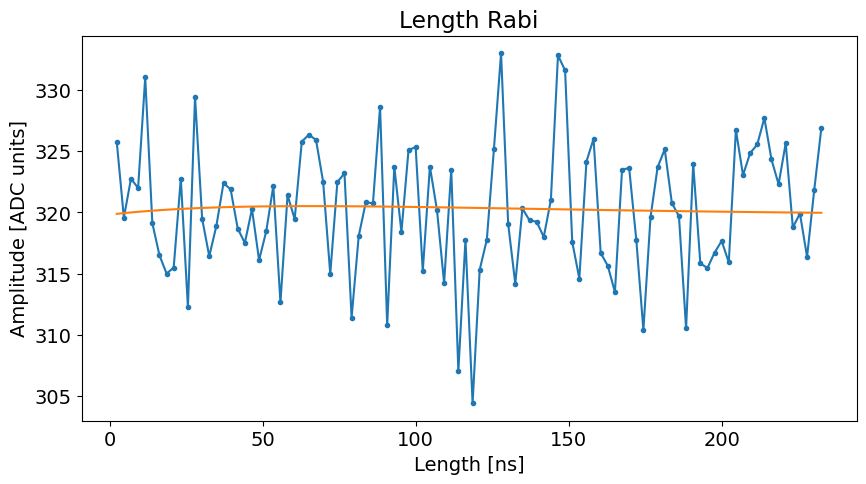

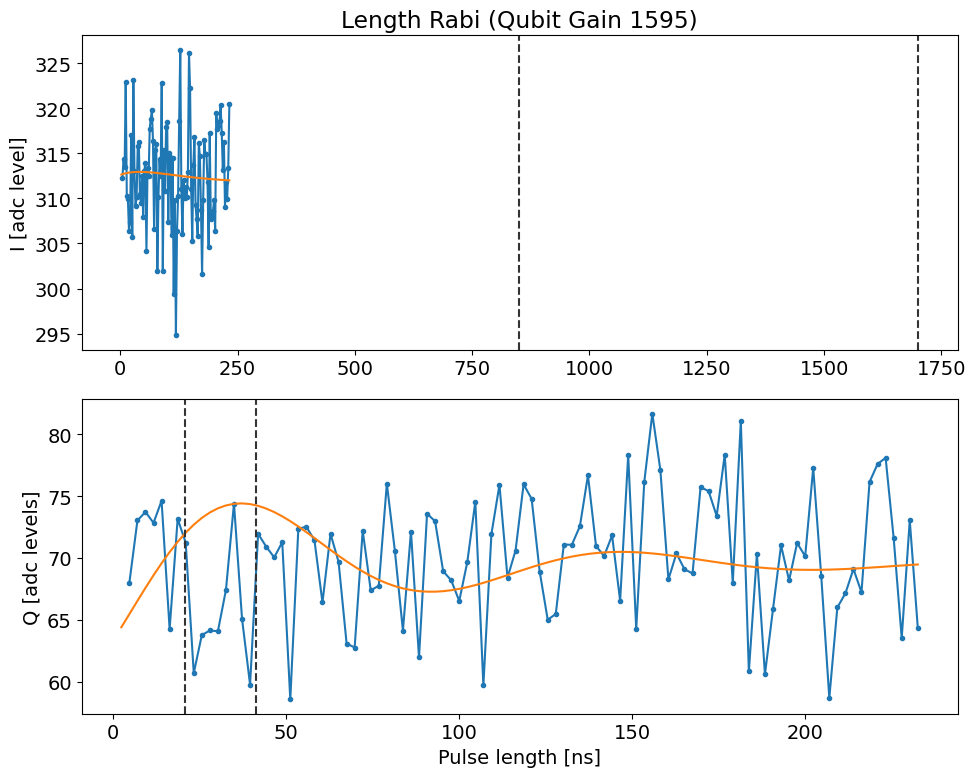

In [320]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = lengthrabi.analyze(data=temp_data, fit=True)

lengthrabi.analyze(fit=True)
lengthrabi.display(fit=True)

In [ ]:
lengthrabi.save_data()

## Repeat the gate N times to amplify angle errors

In [ ]:
npulsecalib = meas.NPulseExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"NPulseExptQ{qubit_i}",
    config_file=config_path,
)

npulsecalib.cfg.expt = dict(
    start=0, # number gate repetitions
    step=1,
    expts=10,
    reps=2000,
    loops=20,
    pulse_type='gauss',
    checkZZ=False,
    checkEF=False, 
    qubits=[qubit_i],
    # qubits=[3,1],
    test_pi_half=False,

    post_process=True,
    singleshot_reps=15000,
    # thresholds=[43.368258050721565, 0, 0, 0],
    # angles=[129.3141210721163, 0, 0, 0],
    # ge_avgs=[[-16.597052285758558, -35.58801227336122, -23.53465758561909, -44.1365109251511], array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
    # counts_calib=[[1609, 11248, 307, 1836], [348, 1780, 2210, 10662]]
)

print(npulsecalib.cfg)
import Pyro4.util
try:
    npulsecalib.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = lengthrabi.analyze(data=temp_data, fit=True)

data = npulsecalib.data
npulsecalib.analyze(fit=True, scale=data['ge_avgs'])
npulsecalib.display(fit=True, scale=data['ge_avgs'])

In [ ]:
npulsecalib.save_data()

## Optimal control amp rabi

### QCTRL

In [ ]:
from qctrl import Qctrl
qctrl = Qctrl()

In [ ]:
# ctrl_result = qctrl.get_result(action_id=1761100)
# ctrl_result = qctrl.get_result(action_id=1763052)
# ctrl_result = qctrl.get_result(action_id=1763052)
ctrl_result = qctrl.get_result(action_id=1764628)

In [ ]:
print("Fidelity:", 1-ctrl_result.output["cost"]["value"])

times_us = []
I_values_MHz = []
Q_values_MHz = []
for q in range(4):
    if f"$\gammaI_{q}$" not in ctrl_result.output: continue
    I_values_q = []
    Q_values_q = []
    t = 0
    for j in range(2): # I, Q
        name = f"$\gamma{'I' if j==0 else 'Q'}_{q}$"
        control = ctrl_result.output[name]
        for step, pulse in enumerate(control):
            if q==1 and j==0: times_us.append(t)
            t += pulse['duration']
            # factor of 1/2, -1, and 2pi due to how their controls are defined relative to ours
            if j==0: I_values_q.append(pulse['value'])
            else: Q_values_q.append(pulse['value'])
            # if j==0: I_values_q.append(0.01)
            # else: Q_values_q.append(0.01)

    I_values_MHz.append(I_values_q)
    Q_values_MHz.append(Q_values_q)

times_us = np.array(times_us)*1e-3
I_values_MHz = np.array(I_values_MHz)*1e3
Q_values_MHz = np.array(Q_values_MHz)*1e3

# plt.figure(figsize=(6,8))
plt.suptitle('I, Q Controls (qubit drives)', fontsize=14)
ymax = 1.1*max(abs(np.concatenate((I_values_MHz.flatten(), Q_values_MHz.flatten()))))

# I_values_MHz[0] = 50*np.exp(-(1e3*times_us-150)**2/10**2)
# Q_values_MHz[0] = 0*np.exp(-(times_us)**2/10**2)

controls_index = 0
for q in range(4):
    if f"$\gammaI_{q}$" not in ctrl_result.output: continue
    # plt.subplot(int(f'41{q+1}'))
    plt.plot(1e3*times_us, I_values_MHz[controls_index], label=f'$I_{q}$')
    plt.plot(1e3*times_us, Q_values_MHz[controls_index], label=f'$Q_{q}$')
    # plt.ylim(-ymax, ymax)
    plt.ylabel(f'$\gamma_{q}/2\pi$ [MHz]')
    plt.legend()
    controls_index += 1

plt.xlabel('Times [ns]')
# plt.tight_layout()
plt.show()
print('max amplitude (MHz)', ymax)

fourier = np.fft.fftshift(np.abs(np.fft.fft(I_values_MHz[0] + 1j*Q_values_MHz[0])))
freqs = np.fft.fftshift(np.fft.fftfreq(len(fourier), d=(times_us[1]-times_us[0])))
plt.plot(freqs, fourier)
plt.xlabel('Frequency [MHz]')
# plt.xlim(-200, 200)
plt.show()

In [ ]:
"""
Get effective drive rate in units of 1/[sigma] from a Rabi experiment
"""
sigma_n = 4 # total number of sigmas in gaussian
def amp_eff(sigma, sigma_n=sigma_n):
    return 1/2 / (sigma * np.sqrt(2*np.pi) * sp.special.erf(sigma_n/2 / np.sqrt(2)))

# What sigma is needed to get given drive rate?
def sigma_needed(amp_rate, sigma_n=sigma_n):
    return 1 / (2*amp_rate*np.sqrt(2*np.pi)*sp.special.erf(sigma_n/2 / np.sqrt(2)))

ymax/amp_eff(yaml_cfg.device.qubit.pulses.pi_ge.sigma[1])*yaml_cfg.device.qubit.pulses.pi_ge.gain[1]
# amp_eff(50/4)

In [ ]:
ch = 1
I_mhz_vs_us = I_values_MHz[0]
Q_mhz_vs_us = Q_values_MHz[0]
gencfg = soc['gens'][ch]
maxv = gencfg['maxv']*gencfg['maxv_scale']
samps_per_clk = gencfg['samps_per_clk']
times_cycles = np.linspace(0, soc.us2cycles(times_us[-1], gen_ch=ch), len(times_us))
times_samps = samps_per_clk * times_cycles
print(times_cycles)
print('samps per clock', samps_per_clk)
IQ_scale = max((np.max(np.abs(I_mhz_vs_us)), np.max(np.abs(Q_mhz_vs_us))))
I_func = sp.interpolate.interp1d(times_samps, I_mhz_vs_us/IQ_scale, kind='quadratic', fill_value='extrapolate')
Q_func = sp.interpolate.interp1d(times_samps, Q_mhz_vs_us/IQ_scale, kind='quadratic', fill_value='extrapolate')
print(times_samps[-1])
t = np.arange(0, np.round(times_samps[-1]))
iamps = I_func(t)
qamps = Q_func(t)
plt.plot(iamps, '.-')
plt.plot(times_samps, I_func(times_samps), '.-')
plt.plot(qamps, '.-')
plt.plot(times_samps, Q_func(times_samps), '.-')
plt.show()

### Import from npz file

240722_qram_4q_2qubit_e+gg
dict_keys(['times', 'I_0', 'Q_0', 'I_1', 'Q_1'])


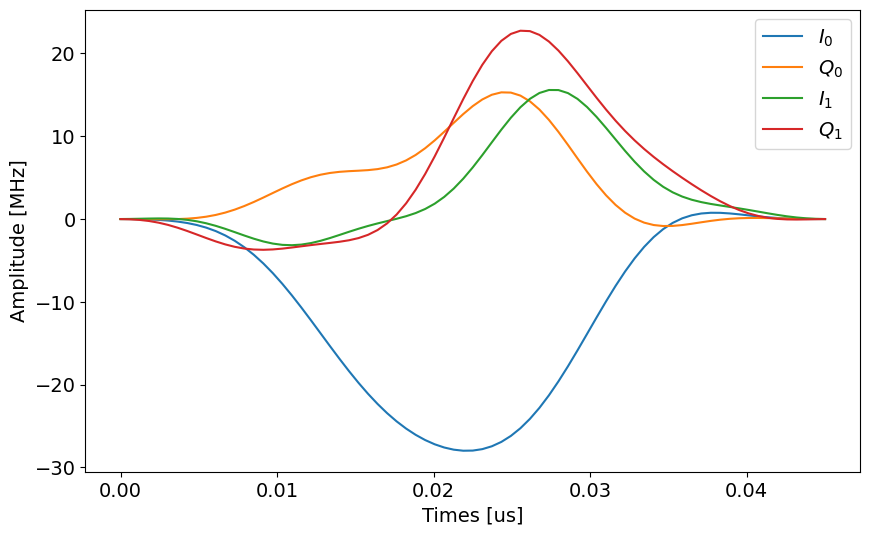

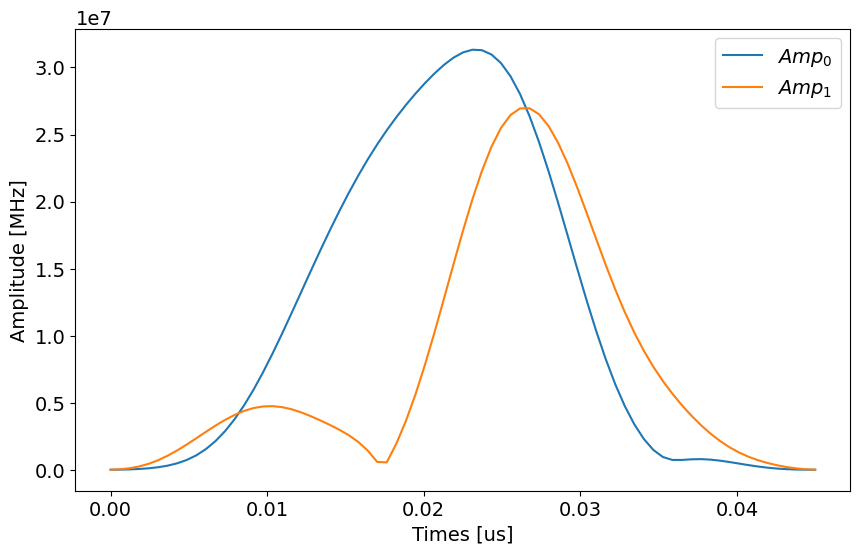

In [83]:
# pulse_filename = yaml_cfg.device.qubit.pulses.pulse_pp.filename
pulse_filename = yaml_cfg.device.qubit.pulses.pulse_1p.filename
# pulse_filename = yaml_cfg.device.qubit.pulses.pulse_p1.filename
print(pulse_filename)

pulse_filepath = os.path.join(os.getcwd(), pulse_filename + '.npz')


pulse_params_dict = dict() # open file
with np.load(pulse_filepath) as npzfile:
    for key in npzfile.keys():
        pulse_params_dict.update({key:npzfile[key]})

print(pulse_params_dict.keys())

times = pulse_params_dict['times']
I_0 = pulse_params_dict['I_0']
Q_0 = pulse_params_dict['Q_0']
I_1 = pulse_params_dict['I_1']
Q_1 = pulse_params_dict['Q_1']
plt.figure()
plt.plot(times*1e6, I_0*1e-6, label='$I_0$')
plt.plot(times*1e6, Q_0*1e-6, label='$Q_0$')
plt.plot(times*1e6, I_1*1e-6, label='$I_1$')
plt.plot(times*1e6, Q_1*1e-6, label='$Q_1$')
plt.legend()
plt.xlabel('Times [us]')
plt.ylabel('Amplitude [MHz]')
plt.show()

I_values_MHz = np.array([I_0, I_1])*1e-6
Q_values_MHz = np.array([Q_0, Q_1])*1e-6
times_us = times*1e6

plt.figure()
plt.plot(times*1e6, np.abs(I_0+1j*Q_0), label='$Amp_0$')
plt.plot(times*1e6, np.abs(I_1+1j*Q_1), label='$Amp_1$')
plt.legend()
plt.xlabel('Times [us]')
plt.ylabel('Amplitude [MHz]')
plt.show()

Run amplitude rabi

In [84]:
IQ_qubits = [0, 1]

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (0)


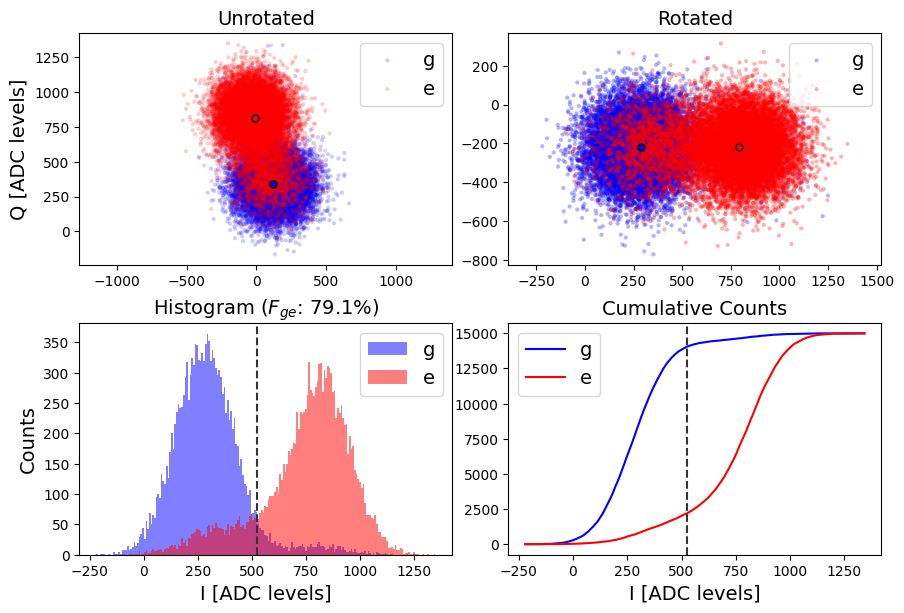

ge fidelity (%): 79.05333333333333 	 angle (deg): -107.11765135264082 	 threshold ge: 526.1675468085
Qubit  (1)


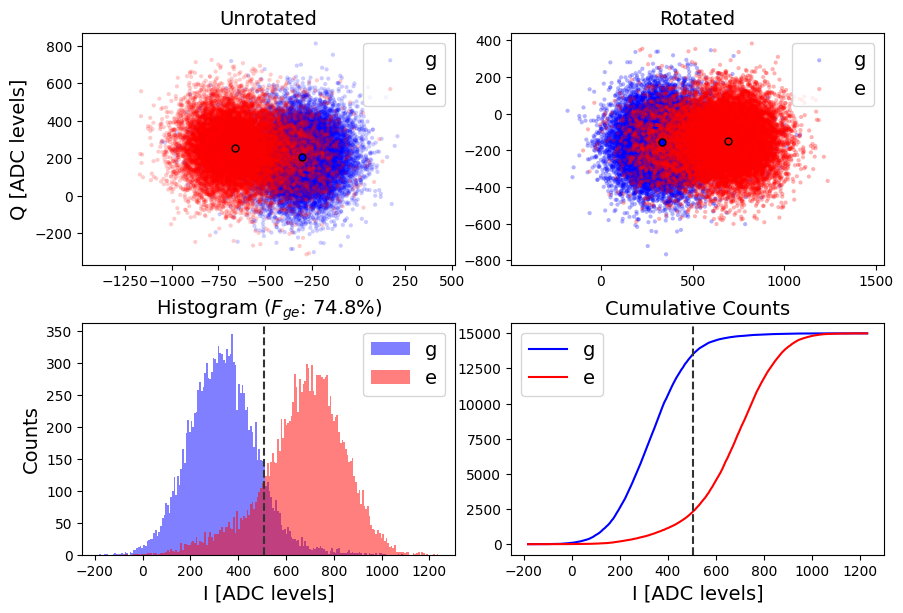

ge fidelity (%): 74.80666666666667 	 angle (deg): -170.87988227173437 	 threshold ge: 506.25962185685535
thresholds=[526.1675468085, 506.25962185685535, 0, 0],
angles=[-107.11765135264082, -170.87988227173437, 0, 0],
ge_avgs=[[119.99043151613778, 350.9525032546786, -10.639394412801737, 781.5753230810958], [-308.7086572265625, 208.00581423611112, -642.4505302300348, 251.94330349392362], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[12558, 1445, 854, 143], [1941, 11881, 289, 889], [1919, 235, 11076, 1770], [481, 1203, 1452, 11864]]


  0%|          | 0/20 [00:00<?, ?it/s]

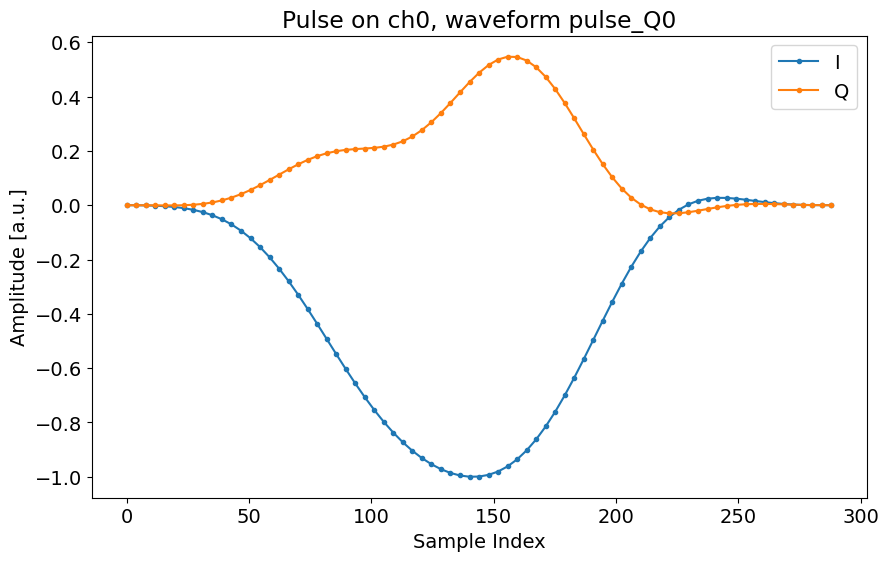

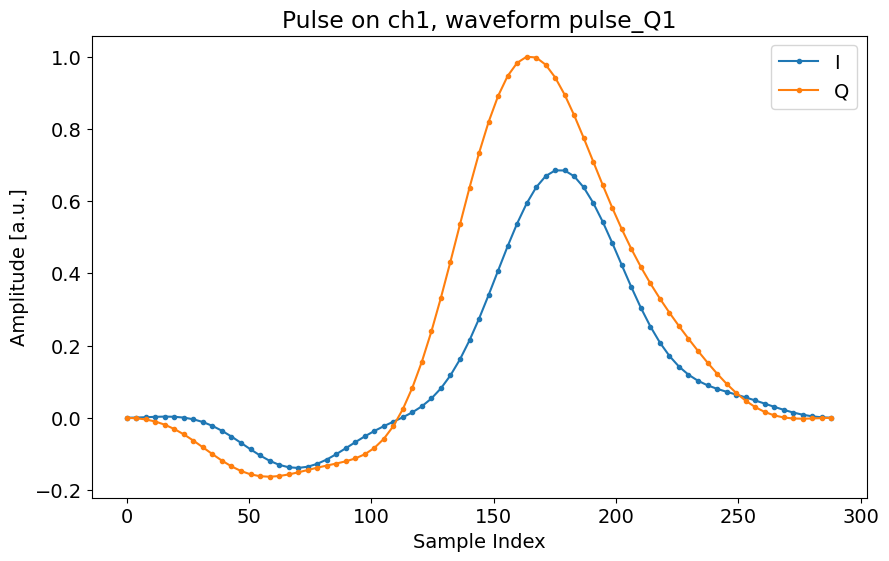

In [85]:
amprabi = meas.AmplitudeRabiOptimalCtrlChevronExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_opt_ctrl_chevron_qubit{IQ_qubits[0]}{IQ_qubits[1]}",
    config_file=config_path,
)

# start = [0, 0]
# spans = [10000, 10000]
# # span = 32000
# npts = [25, 25]

start = [2000, 2000]
spans = [4000, 4000]
npts = [20, 20]

spans = np.array(spans)
npts = np.array(npts)
    
amprabi.cfg.expt = dict(
    starts = start, # start gain for each qubit in IQ_qubits
    steps=(spans/npts).astype(int),
    expts=npts,
    reps=200,
    rounds=10,
    Icontrols=I_values_MHz, # 2D array with array of Icontrols for each of IQ_qubits
    Qcontrols=Q_values_MHz, # 2D array with array of Qcontrols for each of IQ_qubits
    times_us=times_us,
    IQ_qubits=IQ_qubits,

    post_process='scale',
    singleshot_reps=15000,

    # thresholds=[521.4040533387323, 300.0169798857155, 0, 0],
    # angles=[12.998786858152307, 156.54650718837152, 0, 0],
    # ge_avgs=[[349.11613782945733, 368.16658679069764, 902.913945891473, 245.2268714728682], [-254.3919086634111, 84.06556972327726, -448.16672090794, -9.88941287755471], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
    # counts_calib=[[11738, 2372, 667, 223], [2256, 11813, 301, 630], [1275, 331, 10841, 2553], [419, 988, 2098, 11495]]
)

# amprabi.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]

# print(amprabi.cfg)

import Pyro4.util
try:
    amprabi.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

Q0 popln at gain0 4600, gain1 4600: 0.9982159022927336


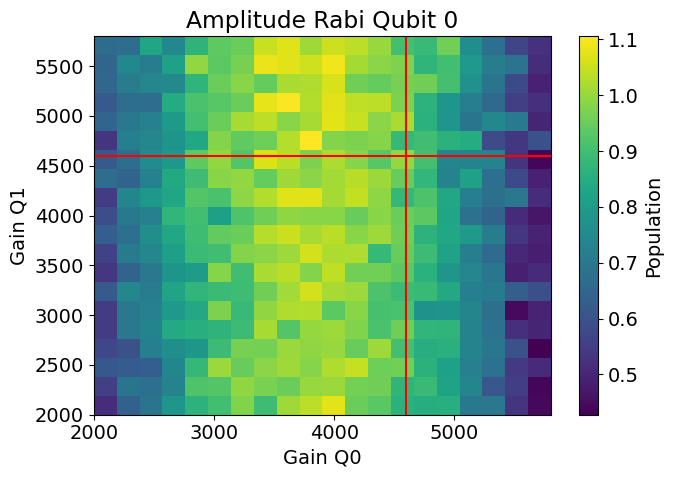

Q1 popln at gain0 4600, gain1 4600: 0.5033765832009632


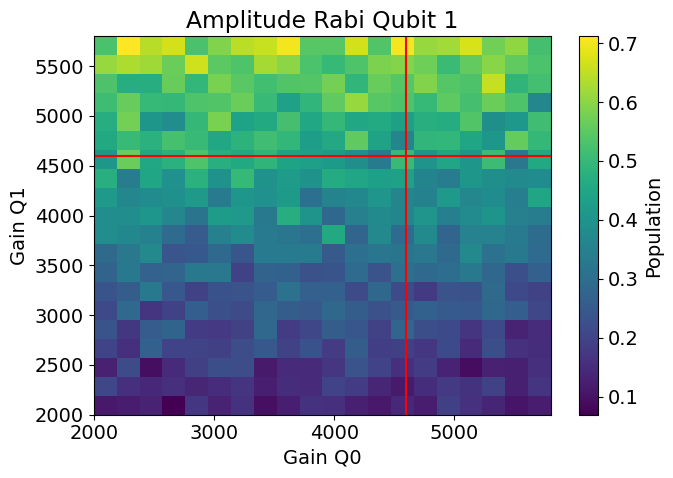

In [86]:
# # TESTING
# amprabi = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit2.h5')
# data = amprabi.analyze(data=temp_data, fit=True)
# amprabi.display(data=data, fit=True)

amprabi.analyze(fit=True, gain0_range=None, gain1_range=None, opt_q0=1.0, opt_q1=0.5)
amprabi.display(fit=True) #, plot_gain0=2500, plot_gain1=3000)

In [ ]:
amprabi.save_data()

## Amplitude Rabi

Measures Rabi oscillations by sweeping over the amplitude of the qubit drive pulse, which is a Gaussian pulse with sigma set by <code>cfg.device.qubiti.pulses.pi_ge.sigma</code>. We measure the $\pi$ pulse amplitude which are used in subsequent experiments to control the qubit, which should be stored in <code>cfg.device.qubiti.pulses.pi_ge.gain</code>.

In [64]:
amprabi = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_qubit{qubit_i}",
    config_file=config_path,
)

# span = 30000
span = 5000
npts = 101
    
amprabi.cfg.expt = dict(
    # start=0, # qubit gain [dac level]
    # step=int(span/npts), # [dac level]
    # expts=npts,
    start=0,
    step=int(100),
    expts=100,
    reps=100,
    rounds=10,
    sigma_test=0.005, # gaussian sigma for pulse length - overrides config [us]
    checkZZ=False,
    checkEF=False, 
    # qubits=[0, 1], # qZZ, qTest
    qubits=[qubit_i],
    # pulse_type='gauss',
    pulse_type='gauss',
    # n_pulses=10,
    # pulse_type='adiabatic',
    # mu=6, # dimensionless
    # beta=4, # dimensionless
    # sigma_test=0.100, # us
    # pulse_type='pulseiq',
    # Icontrols=I_values_MHz[0],
    # Qcontrols=Q_values_MHz[0],
    # times_us=times_us,
)

# amprabi.cfg.device.readout.relax_delay = 0 # Wait time between experiments [us]
# amprabi.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]

print(amprabi.cfg)

import Pyro4.util
try:
    amprabi.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-390.95193842109995, 5794.90833333, 501.288233333334, -229.94910723], 'frequency_ef': [-392.9315036040767, 5794.925333329999, 499.41074988962544, -231.37577390000007], 'gain': [0.25, 0.3, 0.85, 0.35], 'readout_length': [8.0, 10.0, 7.0, 6.0], 'readout_length_ef': [8.0, 7.0, 4.0, 4.0], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4110.42834951, 3448.19703452, 4762.18199758, 4381.650168813355], 'f_ef': [3884.3809607535322, 3347.761789059698, 4572.363929531337, 4209.91711365584], 'f_Q1_ZZ': [3442.909184486008, 0, 3447.0924878770584, 3446.9608452525486], 'f_Q_ZZ1': [4104.8259754819555, 0, 4761.14068386677, 4380.292188886469], 'f_ef_Q_ZZ1': [0, 0, 4570.466450039196, 4207.199191279], 'f_EgGf': [2686.53594683, 0, 2017.3, 2414.92850999], 'f_EgGf_Q': [0, 0, 5883.9, 5146.885], 'f_f0g1': [1184.4, 999.8, 1632.9833333333333, 1620.9166666666665], 'gs': [52.40296404695958, 54.81794456602636, 43.495131170

  0%|          | 0/10 [00:00<?, ?it/s]

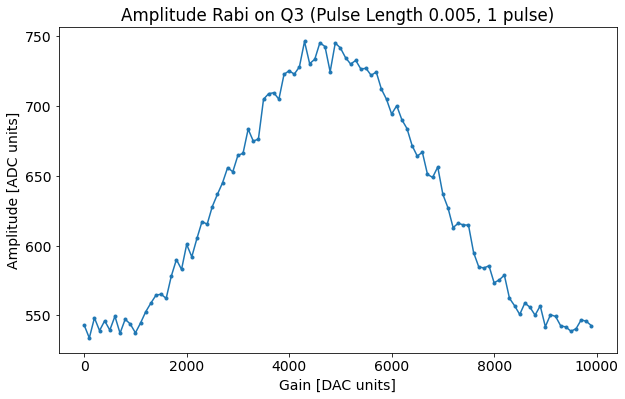

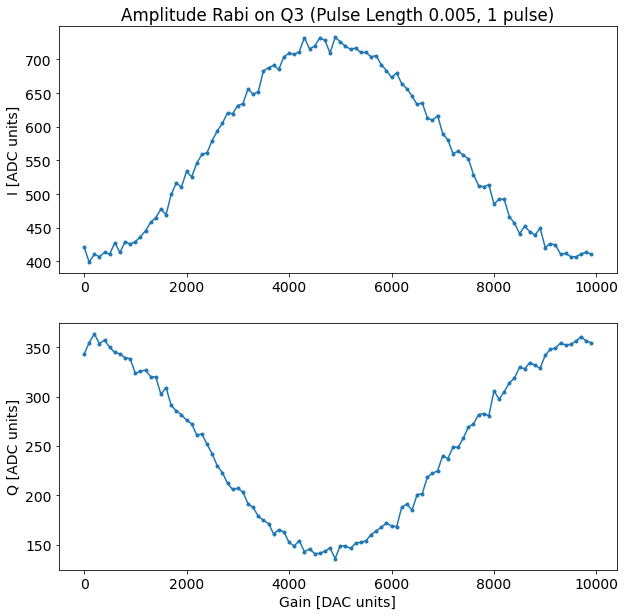

In [66]:
# # TESTING
# amprabi = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit2.h5')
# data = amprabi.analyze(data=temp_data, fit=True)
# amprabi.display(data=data, fit=True)

amprabi.analyze(fit=True)
amprabi.display(fit=False)

In [ ]:
amprabi.save_data()

## Amplitude rabi qubit frequency sweep (chevron)

In [ ]:
amprabichev = meas.AmplitudeRabiChevronExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_qubit_chevron{qubit_i}",
    config_file=config_path,
)

# span_gain = 10000
# npts_gain = 51
span_gain = 0
npts_gain = 1

span_f = 20
npts_f = 80

amprabichev.cfg.expt = dict(
    # start_f=amprabichev.cfg.device.qubit.f_ge[qubit_i]-span_f/2,
    # start_f=amprabichev.cfg.device.qubit.f_Q1_ZZ[0]-span_f/2,
    start_f=amprabichev.cfg.device.qubit.f_ef[qubit_i]-span_f/2,
    step_f=span_f/(npts_f-1),
    expts_f=npts_f,
    # start_gain=0, # qubit gain [dac level]
    start_gain=amprabichev.cfg.device.qubit.pulses.pi_ef.gain[qubit_i],
    step_gain=int(span_gain/npts_gain), # [dac level]
    expts_gain=npts_gain,
    reps=500,
    rounds=10,
    # sigma_test=0.2, # gaussian sigma for pulse length - overrides config [us]
    checkZZ=False,
    checkEF=True, 
    pulse_ge=True,
    qubits=[qubit_i],
    pulse_type='gauss',
    # pulse_type='adiabatic',
    # mu=6, # dimensionless
    # beta=4, # dimensionless
    # sigma_test=0.120*4, # us
)

# amprabichev.cfg.device.readout.relax_delay = 50 # Wait time between experiments [us]

print(amprabichev.cfg)

amprabichev.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# # TESTING
# temp_data_file = '/home/xilinx/jupyter_notebooks/_experiment/20211215_LL_StandardCandle1/data/00000_power_sweep_resonator_spectroscopy_qubit2.h5'
# with SlabFile(temp_data_file) as a:
#     temp_data = dict(
#         amps=np.asarray(a['amps']),
#         gainpts=np.asarray(a['gain']),
#         fpts=np.asarray(a['freq']),
#     )

# data = rpowspec.analyze(data=temp_data, lowgain=2000, highgain=18000)

amprabichev.analyze()
amprabichev.display()

plt.figure()
data = amprabichev.data
plot_gain = amprabichev.cfg.device.qubit.pulses.pi_ef.gain[qubit_i]
gain_ind = np.argmin(np.abs(data['xpts']-plot_gain))
plt.title(f"Cut through gain {data['xpts'][gain_ind]}")
plt.plot(data['freqpts'], data['amps'][:, gain_ind], '.-')
plt.xlabel('Frequency [MHz]')


# check all the ZZ shifted
ZZs = np.reshape(amprabichev.cfg.device.qubit.ZZs, (4, 4))
good_ZZ_freq = amprabichev.cfg.device.qubit.f_ef[qubit_i]
plt.axvline(good_ZZ_freq, color='g', linestyle='--')
for i in range(4):
    if i == qubit_i: continue
    bad_ZZ_freq = amprabichev.cfg.device.qubit.f_ef[qubit_i]+ZZs[qubit_i, i]
    plt.axvline(bad_ZZ_freq, color='r', linestyle='--')



plt.show()

In [ ]:
amprabichev.save_data()

## Single Shot

Measures the single shot readout fidelity of the system. We acquire single shot (I, Q) readout values by first preparing the qubit in its ground (blue dots) a certain number of times and then preparing the qubit in its excited state (red dots) the same number of times. We then extract two parameters which are used to optimize the associated readout fidelity: the rotation angle of the IQ blobs and the threshold that classifies the two qubit states (ground and excited). The two output parameters should be stored in <code>cfg.device.readouti.phase</code> and <code>cfg.device.readouti.threshold</code>.

Note that this experiment already assumes that you have found your qubit frequency and $\pi$ pulse amplitude. Every time you reset the QICK firmware the single shot angle and threshold changes. So, this experiment is used to calibrate any experiment below that uses single shot data (such as the Active Reset experiment).

In [241]:
qubit_i = 2

In [239]:
shot = meas.HistogramExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_qubit{qubit_i}",
    config_file=config_path,
)

shot.cfg.expt = dict(
    reps=20000,
    check_e=True,

    # reps=100000000,
    # check_e=False,

    check_f=False,
    # qubit=1,
    qubit=qubit_i,

    # cool_qubits=[qubit_i],
    # cool_qubits=[0, 1, 2, 3],
    # cool_idle=[5],
)

# shot.cfg.device.readout.frequency[qubit_i] = shot.cfg.device.readout.frequency_ef[qubit_i]
# shot.cfg.device.readout.readout_length[qubit_i] = shot.cfg.device.readout.readout_length_ef[qubit_i]

# shot.cfg.device.readout.frequency_ef[qubit_i]=shot.cfg.device.readout.frequency_ef[qubit_i] - 1.3
# shot.cfg.device.readout.frequency=shot.cfg.device.readout.frequency_ef
# print(shot.cfg.device.readout.frequency_ef)
# shot.cfg.device.readout.frequency[qubit_i]=shot.cfg.device.readout.frequency[qubit_i] - 0.4
# shot.cfg.device.readout.gain[0]= 0.001
# shot.cfg.device.readout.gain[1]= 0.001
# shot.cfg.device.readout.gain[2]= 0.001
# shot.cfg.device.readout.gain[3]= 0.001



# shot.cfg.device.readout.gain[qubit_i] = 0.25
# shot.cfg.device.readout.readout_length = 6
# shot.cfg.device.readout.relax_delay = 500  # Wait time between experiments [us]

# set the gains 

print('qubit', shot.cfg.expt.qubit)

shot.go(analyze=False, display=False, progress=True, save=False)

qubit 3


  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

qubit 3
Unrotated:
Ig 411.7658708627238 +/- 154.19162692377836 	 Qg 335.30113944655454 +/- 143.63627154055243 	 Amp g 531.0159946004406 +/- 141.89487730922303
Ie 790.2794357026587 +/- 181.9550841761531 	 Qe 73.96500271296799 +/- 157.44689134420585 	 Amp e 793.733209662316 +/- 151.54127367322212
Rotated:
Ig 162.59719197395367 +/- 154.19162692377836 	 Qg 506.4452926829281 +/- 143.63627154055243 	 Amp g 531.906647183988 +/- 141.89487730922303
Ie 630.5601226141948 +/- 181.9550841761531 	 Qe 485.328835834894 +/- 157.44689134420585 	 Amp e 795.707325041112 +/- 151.54127367322212
g correctly categorized: 92.415%
e correctly categorized: 86.62933146657332%


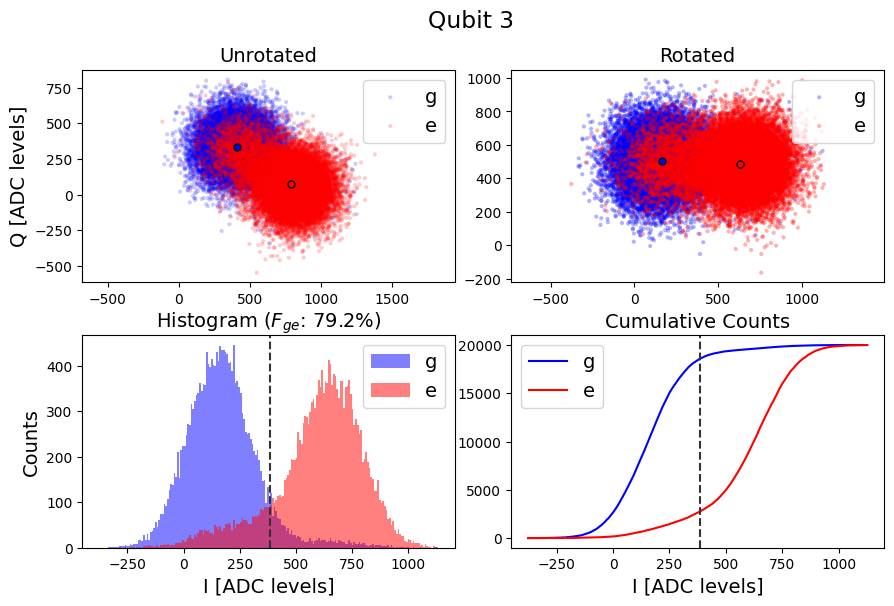

ge fidelity (%): 79.18697967449187
rotation angle (deg): 32.955595409512455
threshold ge: 385.78475229355934


In [240]:
# # TESTING
# shot = meas.HistogramExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00001_single_shot_qubit0.h5')
# data = shot.analyze(data=temp_data)
# shot.display(data=data)

print('qubit', qubit_i)
shot.analyze(verbose=False)
shot.display(verbose=True, plot_f=False)

In [ ]:
# Checking for drift vs. shot number

data = shot.data
i = data['Ie']
q = data['Qe']
amps = np.abs(i+1j*q)
phases = np.angle(i+1j*q)

# plt.plot(amps, '.', label='amps')
# plt.ylabel('Amps [ADC units]')
# plt.xlabel('Shot number')
# plt.legend()
# plt.show()

plt.plot(phases, '.', label='phases')
plt.axhline(0, color='r')
plt.axhline(1.5, color='r')
plt.ylabel('Phases [radians]')
plt.xlabel('Shot number')
plt.legend()
plt.show()

plt.plot(i, '.', label='i')
plt.ylabel('I [ADC units]')
plt.xlabel('Shot number')
plt.legend()
plt.show()

plt.plot(q, '.', label='Q')
plt.ylabel('Q [ADC units]')
plt.xlabel('Shot number')
plt.legend()
plt.show()

In [ ]:
shot.save_data()

Single shot drift

In [ ]:
import time

Igs = []
Qgs = []
Ies = []
Qes = []
angles = []

drift_meas_time = 2*60

start_time = time.time()
elapsed_time = 0
meas_times = []
for i in tqdm(range(20)):
# for i in tqdm(range(3)):
    shot = meas.HistogramExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"single_shot_qubit{qubit_i}",
        config_file=config_path,
    )

    shot.cfg.expt = dict(
        reps=20000,
        check_f=False,
        qubit=qubit_i,
    )

    # shot.cfg.device.readout.frequency=-82.015-0.54
    shot.cfg.device.readout.gain=0.75
    # shot.cfg.device.readout.readout_length = 10 # [us]
    # shot.cfg.device.readout.relax_delay = 70 # Wait time between experiments [us]
    # print(shot.cfg)

    shot.go(analyze=False, display=False, progress=False, save=False)
    elapsed_time = time.time() - start_time

    shot.analyze(verbose=False)

    Ig = np.average(shot.data['Ig'])
    Qg = np.average(shot.data['Qg'])
    Ie = np.average(shot.data['Ie'])
    Qe = np.average(shot.data['Qe'])
    angle = shot.data['angle']
    # print('Ig', Ig, 'Qg', Qg, 'Ie', Ie, 'Qe', Qe, 'angle', angle)

    Igs.append(Ig)
    Qgs.append(Qg)
    Ies.append(Ie)
    Qes.append(Qe)
    angles.append(angle)

    meas_times.append(elapsed_time)
    if elapsed_time > drift_meas_time: break
    time.sleep(30)

    

In [ ]:
Igs = np.array(Igs)
Qgs = np.array(Qgs)
Ies = np.array(Ies)
Qes = np.array(Qes)
phase_gs = arctan(Igs/Qgs)
phase_es = arctan(Ies/Qes)
amps_gs = np.sqrt(Igs**2 + Qgs**2)
amps_es = np.sqrt(Ies**2 + Qes**2)

plt.plot(meas_times, Igs, label='Ig')
plt.plot(meas_times, Ies, label='Ie')
plt.ylabel('I [ADC units]')
plt.xlabel('Measurement time (s)')
plt.legend()
plt.show()

plt.plot(meas_times, Qgs, label='Qg')
plt.plot(meas_times, Qes, label='Qe')
plt.ylabel('Q [ADC units]')
plt.xlabel('Measurement time (s)')
plt.legend()
plt.show()

plt.plot(Qgs, Igs, label='Ig(Qg)')
plt.plot(Qes, Ies, label='Ie(Qe)')
plt.ylabel('I [ADC units]')
plt.xlabel('Q [ADC units]')
plt.legend()
plt.show()

plt.plot(meas_times, amps_gs, label='amps g')
plt.plot(meas_times, amps_es, label='amps e')
plt.ylabel('Amps [ADC units]')
plt.xlabel('Measurement time (s)')
plt.legend()
plt.show()

plt.plot(meas_times, phase_gs, label='phases g')
plt.plot(meas_times, phase_es, label='phases e')
plt.ylabel('Phase (rad)')
plt.xlabel('Measurement time (s)')
plt.legend()
plt.show()


### Single shot/readout optimization

In [ ]:
shotopt = meas.SingleShotOptExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_opt_qubit{qubit_i}",
    config_file=config_path,
)

span_f = 1.0 # MHz
npts_f = 10

span_gain = 0.0
# npts_gain = 2
npts_gain = 1

span_len = 0 # us
# npts_len  2
npts_len = 1

shotopt.cfg.expt = dict(
    reps=15000,
    qubit=qubit_i,

    start_f=shotopt.cfg.device.readout.frequency[qubit_i] - 0.5*span_f,
    step_f=span_f/npts_f,
    expts_f=npts_f,

    # start_gain=int(shotopt.cfg.device.readout.gain[qubit_i] - 0.5*span_gain),
    # start_gain=int(shotopt.cfg.device.readout.gain[qubit_i]-span_gain/2),
    start_gain=0.10,
    step_gain=span_gain/npts_gain,
    expts_gain=npts_gain,

    start_len=3.0,
    step_len=span_len/npts_len,
    expts_len=npts_len,
)

print(shotopt.cfg)

shotopt.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
shotopt.analyze()
print(shotopt.data['fid'])
shotopt.display()

In [ ]:
shotopt.save_data()

## $T_1$

Measures the qubit T1 characteristic decay time by preparing the qubit in its excited state with a $\pi$ pulse followed by a variable delay ($\tau$) before measuring the qubit's state. This exponential decay curve can be fitted in post-processing to obtain the qubit T1 time.

In [10]:
qubit_i = 2

In [11]:
t1 = meas.T1Experiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"t1_qubit{qubit_i}",
    config_file=config_path,
)

span = 400
# npts = 151
npts = 1

t1.cfg.expt = dict(
    start=0, # wait time [us]
    step=span/npts,
    expts=npts+1,
    # step=400,
    # expts=2,
    reps=2000,
    rounds=5,
    qubit=qubit_i,
    # checkEF=True,
)

# t1.cfg.device.readout.frequency[qubit_i] = t1.cfg.device.readout.frequency_ef[qubit_i]
# t1.cfg.device.readout.readout_length[qubit_i] = t1.cfg.device.readout.readout_length_ef[qubit_i]

# t1.cfg.device.readout.relax_delay = 300 # Wait time between experiments [us]

print(t1.cfg)

t1.go(analyze=False, display=False, progress=True, save=False)

{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-390.95193842109995, 5794.90833333, 501.288233333334, -229.87577390000007], 'frequency_ef': [-392.9315036040767, 5794.925333329999, 499.41074988962544, -231.37577390000007], 'gain': [0.25, 0.3, 0.85, 0.45], 'readout_length': [8.0, 10.0, 8.0, 6.0], 'readout_length_ef': [8.0, 7.0, 4.0, 4.0], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4110.420743494436, 3448.276329863116, 4762.189233139845, 4381.644523175155], 'f_ef': [3884.3809607535322, 3347.761789059698, 4572.375572742949, 4209.906282844173], 'f_Q1_ZZ': [3442.909184486008, 0, 3447.0924878770584, 3446.9608452525486], 'f_Q_ZZ1': [4104.8259754819555, 0, 4761.14068386677, 4380.292188886469], 'f_ef_Q_ZZ1': [0, 0, 4570.466450039196, 4207.199191279], 'f_EgGf': [2686.53594683, 0, 2017.3, 2414.92850999], 'f_EgGf_Q': [0, 0, 5883.9, 5146.885], 'f_f0g1': [1184.4666666666667, 999.8, 1632.9833333333333, 1620.9166666666665], 'gs': [52.40296404695958, 

  0%|          | 0/5 [00:00<?, ?it/s]

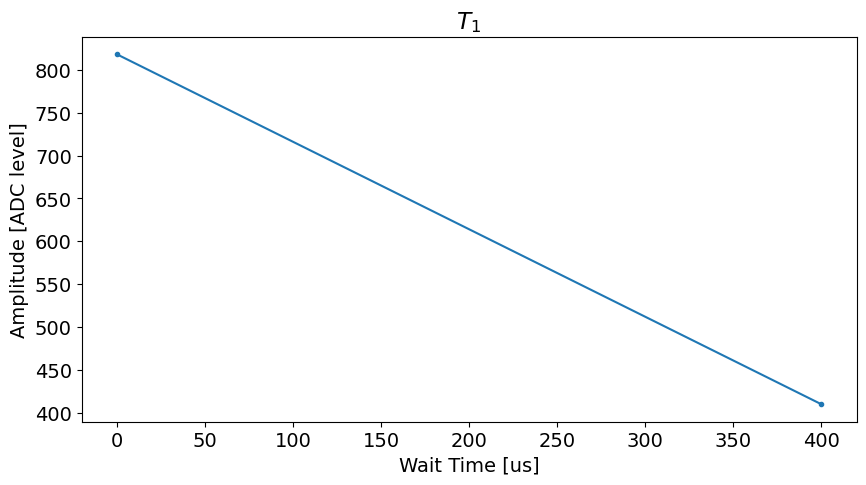

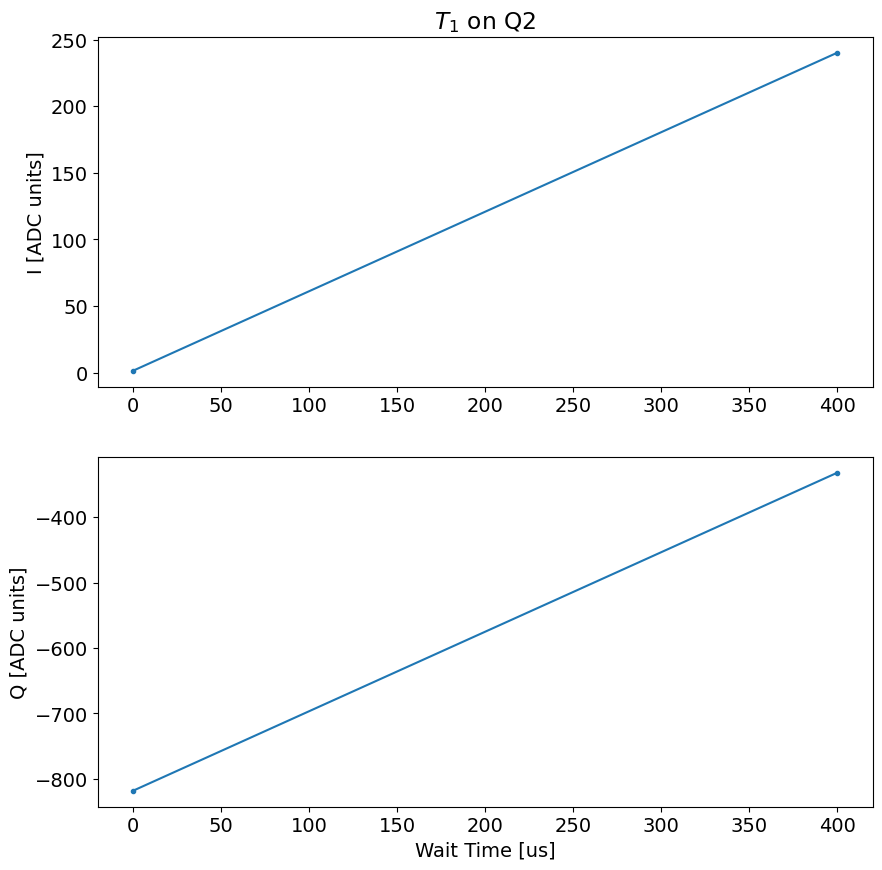

In [12]:
# TESTING
# t1 = meas.T1Experiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_t1_qubit3.h5')
# data = t1.analyze(data=temp_data) #, fit_slice=(0, 50))
# t1.data = data
# t1.cfg = AttrDict(attrs['config'])
# print(t1.cfg.expt.reps, t1.cfg.expt.rounds, t1.cfg.expt.expts)

# t1.display(data=data, fit=True, fit_log=False)

# print('qubit', qubit_i)
# t1.analyze()
t1.display(fit=False)

In [ ]:
t1.save_data()

Fit to quasiparticle excitations

In [ ]:
t1 = meas.T1Experiment(config_file=config_path,)
temp_data, attrs = prev_data(expt_path, '00003_t1_qubit2.h5')
data = t1.analyze(data=temp_data)
t1.data = data
t1.cfg = AttrDict(attrs['config'])


xpts_full = np.copy(t1.data['xpts'])
ypts_full = np.copy(t1.data['amps'])

ypts_full = (ypts_full - ypts_full[-1])/(ypts_full[0]-ypts_full[-1])

xpts_fit = np.copy(t1.data['xpts'][:-37])
ypts_fit = np.copy(ypts_full[:-37])

xpts_fit = xpts_fit[:-1]
ypts_fit = ypts_fit[:-1] # need to get rid of the 0 at the end of the sequence
print(ypts_fit)
ypts_logscale = np.log(ypts_fit)
print(ypts_logscale)
for i in range(len(xpts_fit)):
    if np.isnan(ypts_logscale[i]):
        ypts_logscale[i] = (ypts_logscale[i+1] + ypts_logscale[i-1])/2
print(ypts_logscale)


fitparams = [0.1, 20, 50]
fitparams = None
# p, pCov = meas.fitting.fitqpexp(xpts_fit, ypts_logscale, fitparams=fitparams)
p, pCov = meas.fitting.fitlogexp(xpts_fit, ypts_logscale, fitparams=fitparams)

plt.figure()
plt.yscale('log')
plt.plot(xpts_full, ypts_full,'o-')
plt.axhline(1/np.e, linestyle='--', color='k')

# captionStr = '$T_{1QP}$'+ f' fit [us]: {p[1]:.3} $\pm$ {np.sqrt(pCov[1][1]):.3}'
# captionStr += '\n$T_{1R}$'+ f' fit [us]: {p[2]:.3} $\pm$ {np.sqrt(pCov[2][2]):.3}'
# captionStr += '\n$n_{QP}$'+ f' fit [us]: {p[0]:.3} $\pm$ {np.sqrt(pCov[0][0]):.3}'
# fit_data = meas.fitting.qp_expfunc(xpts_fit, *p)

captionStr = '$T_{1}$'+ f' fit [us]: {p[0]:.3} $\pm$ {np.sqrt(pCov[0][0]):.3}'
fit_data = meas.fitting.logexpfunc(xpts_fit, *p)



fit_data = np.exp(fit_data)
plt.plot(xpts_fit, fit_data, label=captionStr)

plt.legend()
plt.xlabel("Wait Time [us]")
plt.ylabel("[ADC units]")
plt.show()

In [ ]:
t1.save_data()

## $T_2$ Ramsey Fringe Experiment

Measures the qubit $T_2$ Ramsey characteristic decay time by preparing the qubit in a superposition state with a  $\frac{\pi}{2}$ pulse (about X-axis) followed by a variable delay ($\tau$) before applying another $\frac{\pi}{2}$ pulse (about X-axis) with a phase advanced by $\Delta \phi = \omega * \tau$, where $\omega$ is the Ramsey frequency.

When qubit frequency is off by $\Delta$, oscillations will be observed at $\omega+\Delta$. Iterate on this experiment, adjusting the qubit frequency, until no oscillations are observed.

This exponential decay envelope can be fitted in post-processing to obtain the qubit $T_2$ Ramsey time.

In [216]:
qubit_i =2

In [ ]:
0.5/soc.cycles2us(50)

In [ ]:
t2r = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ramsey_qubit{qubit_i}",
    config_file=config_path,
)

t2r.cfg.expt = dict(
    start=0, # wait time tau [us]
    expts=151,
    step=soc.cycles2us(40), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    ramsey_freq=0.1, # [MHz]
    # step=soc.cycles2us(120), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    # ramsey_freq=0.100, # [MHz]
    reps=300,
    rounds=1,
    qubits=[qubit_i],
    # qubits=[2, 1], # qZZ, qTest
    checkZZ=False,
    checkEF=False,
    # cool_qubits=[1],
    # cool_idle=9.1, # us
)
print(t2r.cfg.expt.step)
# t2r.cfg.device.readout.gain = 0.05
# t2r.cfg.device.readout.relax_delay = 3*t2r.cfg.device.qubit.T1[qubit_i] # Wait time b/w expts [us]
# t2r.cfg.device.qubit.pulses.pi_ge.gain = 4657
# t2r.cfg.device.qubit.pulses.pi_ge.sigma = 0.070

print(t2r.cfg)

import Pyro4.util
try:
    t2r.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
# # TESTING
# t2r = meas.RamseyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
# t2r.cfg = AttrDict(attrs['config'])
# data = t2r.analyze(data=temp_data, fit=True)
# t2r.display(data=data, fit=True)

t2r.analyze(fit=True, fit_num_sin=1)
t2r.display(fit=True, fit_num_sin=1)

plt.figure()
data = t2r.data
xpts = data['xpts']
fourier = np.fft.fftshift(np.abs(np.fft.fft(data['avgi'])))
freqs = np.fft.fftshift(np.fft.fftfreq(len(fourier), d=(xpts[1]-xpts[0])))
plt.plot(freqs, fourier)
ZZs = np.reshape(t2r.cfg.device.qubit.ZZs, (4, 4))
for i in range(4):
    plt.axvline(t2r.cfg.expt.ramsey_freq - ZZs[qubit_i, (qubit_i+i)%4], color='k', linewidth=0.5, linestyle='--')
plt.xlabel('Frequency [MHz]')
plt.xlim(-7, 7)
plt.ylim(0, 30000)
plt.title(f'Fourier Transform of Ramsey on Q{qubit_i} (Ramsey Freq: {t2r.cfg.expt.ramsey_freq})')
plt.show()

In [ ]:
# # TESTING
# t2r = meas.RamseyExperiment(config_file=config_path)
# t2r.cfg.expt = dict(ramsey_freq=2, qubit=qubit_i)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit1.h5')
# data = t2r.analyze(data=temp_data, fit=True)
# t2r.display(data=data, fit=True)

t2r.save_data()

In [ ]:
temp = 1e3*-h*fge/(kB*np.log(efamp_nopulse/efamp_normal))

## $T_2$ Echo

Same idea as Ramsey, but add additional $\pi$ pulses in the middle of $\tau$  which prevent the qubit from decaying as quickly.

In [ ]:
soc.cycles2us(15)*1e3

In [ ]:
t2e = meas.RamseyEchoExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"echo_qubit{qubit_i}",
    config_file=config_path,
)

t2e.cfg.expt = dict(
    start=soc.cycles2us(30), # total wait time b/w the two pi/2 pulses [us]
    step=soc.cycles2us(8), # make sure nyquist freq = 0.5*(1/step) > ramsey (signal) freq!
    expts=200,
    ramsey_freq=3.0, # frequency by which to advance phase [MHz]
    num_pi=1, # number of pi pulses
    cpmg=False, # set either cp or cpmg to True
    cp=True, # set either cp or cpmg to True
    reps=800,
    rounds=1,
    qubit=qubit_i,
)

# t2e.cfg.device.readout.relax_delay = 3*t2e.cfg.device.qubit.T1[qubit_i] # Wait time b/w expts [us]

print(t2e.cfg)

t2e.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# # TESTING
# t2e = meas.RamseyEchoExperiment(config_file=config_path)
# t2e.cfg.expt = dict(ramsey_freq=1, qubit=qubit_i)
# temp_data, attrs = prev_data(expt_path, '00000_echo_qubit1.h5')
# data = t2e.analyze(data=temp_data, fit=True)
# t2e.display(data=data, fit=True)

print('qubit', qubit_i)
t2e.analyze(fit=True)
t2e.display(fit=True)

In [ ]:
t2e.save_data()

# Qubit ef spectroscopy

## Pulse Probe ef spectroscopy

Qubit ef frequency should be stored in <code>cfg.qubiti.f_ef</code>.

In [21]:
qubit_i =2

In [24]:
qEFspec = meas.PulseProbeEFSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_EF_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span = 25
npts = 150

qEFspec.cfg.expt = dict(
    start=qEFspec.cfg.device.qubit.f_ef[qubit_i]-0.5*span, # resonator frequency to be mixed up [MHz]
    step=span/npts, # min step ~1 Hz
    expts=npts, # Number of experiments stepping from start
    reps=100, # Number of averages per point
    rounds=10, # Number of start to finish sweeps to average over
    length=1, # ef probe constant pulse length [us]
    gain=int(50), # ef pulse gain
    pulse_type='gauss', # ef pulse type
    qubit=qubit_i,
)

# qEFspec.cfg.device.readout.relax_delay = 50 # Wait time between experiments [us]
# qEFspec.cfg.device.readout.gain = 0.75 # Wait time between experiments [us]
# qEFspec.cfg.device.readout.frequency[qubit_i] += 0.2 # Wait time between experiments [us]
print(qEFspec.cfg.expt)

qEFspec.go(analyze=False, display=False, progress=True, save=False)

{'start': 4559.863929531337, 'step': 0.16666666666666666, 'expts': 150, 'reps': 100, 'rounds': 10, 'length': 1, 'gain': 50, 'pulse_type': 'gauss', 'qubit': 2}


  0%|          | 0/10 [00:00<?, ?it/s]

In [31]:
config_path

's:\\Connie\\experiments\\qramLL_4QR2\\config_q3diamond_full688and638_reset.yml'

Found peak in amps at [MHz] 4572.360798754663, HWHM -0.36240623530837435
Found peak in I at [MHz] 4572.377604456956, HWHM 0.30042948333753183
Found peak in Q at [MHz] 4572.359092348519, HWHM -0.37625386202360606


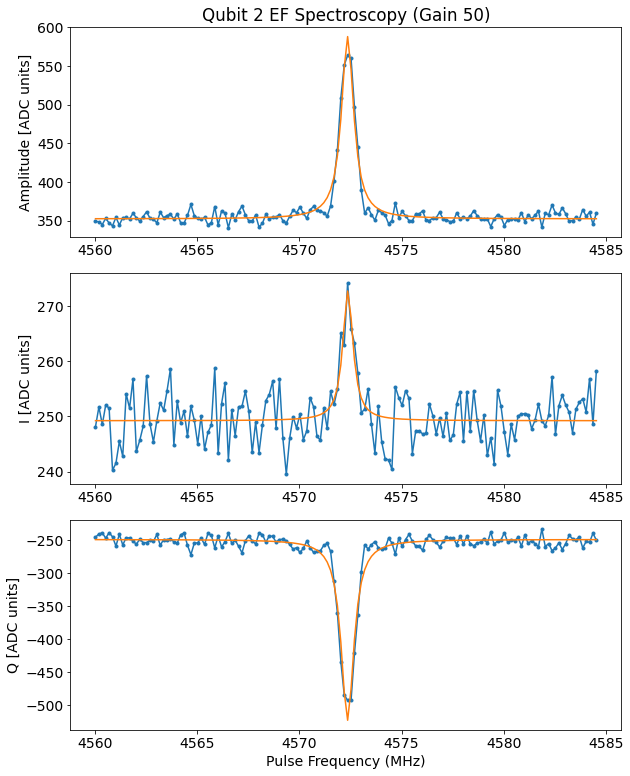

In [25]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = qEFspec.analyze(data=temp_data, fit=True)

qEFspec.analyze(fit=True, signs=[1, -1, 1])
qEFspec.display(fit=True, signs=[1, -1, 1])

In [ ]:
qEFspec.save_data()

### Pulse probe EF power sweep

In [ ]:
pulseprobeEFpowspec = meas.PulseProbeEFPowerSweepSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"pulse_probe_ef_power_sweep_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span_f = 5
npts_f = 5

span_gain = 1000
npts_gain = 2

pulseprobeEFpowspec.cfg.expt = dict(
    start_f=pulseprobeEFpowspec.cfg.device.readout.frequency[qubit_i]-span_f/2, # Pulse frequency [MHz]
    step_f=span_f/npts_f, # min step ~1 Hz
    expts_f=npts_f, # Number experiments stepping freq from start
    # start_gain=pulseprobeEFpowspec.cfg.device.readout.gain[qubit_i], # Gain sweep start [DAC units]
    start_gain=1,
    step_gain=int(span_gain/npts_gain), # Gain step size
    expts_gain=npts_gain, # Number experiments stepping gain from start
    reps=10,
    rounds=10, # Number averages per point
    length=10, # ef const pulse length [us]
    qubit=qubit_i,
)
pulseprobeEFpowspec.cfg.device.readout.relax_delay = 2*pulseprobeEFpowspec.cfg.device.qubit.T1[qubit_i] # Wait time b/w expts [us]

print(pulseprobeEFpowspec.cfg)

pulseprobeEFpowspec.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = rpowspec.analyze(data=temp_data, lowgain=2000, highgain=18000)

pulseprobeEFpowspec.analyze(lowgain=None, highgain=None)
pulseprobeEFpowspec.display()

## Length EF Rabi

In [ ]:
lengthrabiEF = meas.LengthRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabiEF_qubit{qubit_i}",
    config_file=config_path,
)

lengthrabiEF.cfg.expt = dict(
    start=soc.cycles2us(1), # pulse length (sigma) [us]
    step=soc.cycles2us(1), # [us]
    # step=0,
    expts=101,
    reps=1000,
    gain=yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]//3, # qubit gain [DAC units],
    pulse_type='gauss',
    checkZZ=False,
    checkEF=True, 
    pulse_ge=True,
    # cool_qubits=[1],
    # cool_idle=9.1, # us
    qubits=[qubit_i],
)
# lengthrabiEF.cfg.device.readout.relax_delay = 50 # Wait time between experiments [us]

import Pyro4.util
try:
    lengthrabiEF.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
lengthrabiEF.save_data()

In [ ]:
# # TESTING
# # lengthrabiEF = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# lengthrabiEF.data = temp_data

lengthrabiEF.analyze(fit=True, fit_func='sin')

# lengthrabiEF_fit, lengthrabiEF_fit_err = meas.fitting.get_best_fit(lengthrabiEF.data) #, fitfunc=fitter.decaysin)

lengthrabiEF.display(fit=True, fit_func='sin')

fit_axis = 'amps'

lengthrabiEF_data = lengthrabiEF.data[fit_axis]
p = lengthrabiEF.data[f'fit_{fit_axis}']
# efamp_normal = p[0]
# efamp_nopulse = p[0]
print(p[0])

# p = lengthrabiEF_fit
# if p[2] > 180: p[2] = p[2] - 360
# elif p[2] < -180: p[2] = p[2] + 360
# if p[2] < 0: pi_lenEF = (1/2 - p[2]/180)/2/p[1]
# else: pi_lenEF = (3/2 - p[2]/180)/2/p[1]
# pi_lenEF = np.max((0.9*pi_lenEF, 0.015)) # since we run the length rabi at a < max gain

# lengthrabiEF_decay = p[3]

# print(f'Use sigma {pi_lenEF} for amplitude rabi EF')

Sweep length rabi over wait times

In [ ]:
wait_times = np.linspace(1, 10, 21)
saved_files = []
print(wait_times)
data_amps = []
data_avgi = []
data_avgq = []

for wait in wait_times:
    print(wait)
    lengthrabiEF = meas.LengthRabiExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"length_rabiEF_qubit{qubit_i}",
        config_file=config_path,
    )

    lengthrabiEF.cfg.expt = dict(
        start=soc.cycles2us(1), # pulse length (sigma) [us]
        step=soc.cycles2us(1), # [us]
        # step=0,
        expts=101,
        reps=10000,
        gain=yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]//3, # qubit gain [DAC units],
        pulse_type='gauss',
        checkZZ=False,
        checkEF=True, 
        pulse_ge=False,
        cool_qubits=[1],
        cool_idle=wait, # us
        qubits=[qubit_i],
    )
    # lengthrabiEF.cfg.device.readout.relax_delay = 50 # Wait time between experiments [us]

    import Pyro4.util
    try:
        lengthrabiEF.go(analyze=False, display=False, progress=True, save=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))
    saved_files.append(lengthrabiEF.save_data())

    data_amps.append(lengthrabiEF.data['amps'])
    data_avgi.append(lengthrabiEF.data['avgi'])
    data_avgq.append(lengthrabiEF.data['avgq'])

In [ ]:
plot_xpts = lengthrabiEF.data['xpts']
plot_ypts = wait_times
data = np.copy(data_amps)

amplitudes = []
maxes = []
mins = []
for length_rabi in data:
    amplitudes.append(max(length_rabi) - min(length_rabi))
    maxes.append(max(length_rabi))
    mins.append(min(length_rabi))
maxes = np.array(maxes) - min(mins)
mins = np.array(mins) - min(mins)

plt.figure()
plt.pcolormesh(plot_xpts, plot_ypts, data, cmap='viridis', shading='auto')
plt.colorbar()
plt.xlabel('Pulse Length [ns]')
plt.ylabel('Wait Time [us]')
plt.show()

plt.figure()
# plt.plot(wait_times, amplitudes, label='amplitude')
# plt.plot(wait_times, maxes, '--', label='max')
# plt.plot(wait_times, mins, '--', label='min')
for i in range(len(wait_times)//2):
    plt.plot(plot_xpts, data[i]-min(data), linewidth=1, label=f'{wait_times[i]:.3}')
plt.xlabel('Pulse Length [ns]')
plt.ylabel('Amplitude max-min [ADC units]')
plt.ylim(-0.1, 1.1*(max(data)-min(data)))
plt.legend()
plt.show()

plt.figure()
# plt.plot(wait_times, amplitudes, label='amplitude')
# plt.plot(wait_times, maxes, '--', label='max')
# plt.plot(wait_times, mins, '--', label='min')
for i in range(len(wait_times)//2, len(wait_times)):
    plt.plot(plot_xpts, data[i]-min(data), linewidth=1, label=f'{wait_times[i]:.3}')
plt.xlabel('Pulse Length [ns]')
plt.ylabel('Amplitude max-min [ADC units]')
plt.legend()
#     plt.plot(plot_xpts, data[i] - min(data))
plt.ylim(-0.1, 1.1*(max(data)-min(data)))
plt.show()

for i in range(len(wait_times)):
    plt.figure(figsize=(5, 2))
    plt.plot(plot_xpts, data[i] - min(data), label=f'{wait_times[i]}')
    plt.ylim(-0.1, 1.1*(max(data)-min(data)))
    plt.xlabel('Pulse Length [ns]', fontsize=10)
    plt.ylabel('max-min [ADC units]', fontsize=10)
    plt.legend()
    plt.show()

## Amplitude EF Rabi

The EF pi pulse amplitude should be stored in <code>cfg.device.qubit.pulses.pi_ef.gain</code>.

In [211]:
qubit_i = 0

In [214]:
amprabiEF = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="amp_rabi_EF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

# span = 6000
npts = 10

amprabiEF.cfg.expt = dict(
    start=0, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts+1,
    # step=amprabiEF.cfg.device.qubit.pulses.pi_ef.gain[qubit_i],
    # expts=2,
    reps=100,
    rounds=10,
    pulse_type='gauss',
    # sigma_test=0.013, # gaussian sigma for pulse length - default from cfg [us]
    checkZZ=False,
    # checkEF=True, 
    # pulse_ge=True,
    # cool_qubits=[1],
    # cool_idle=9.1, # us
    # check heating from swap
    checkEF=True, 
    pulse_ge=True,
    apply_EgGf=False,
    # qubits_EgGf=[2, 1],
    # qDrive=2,


    qubits=[qubit_i],
)

# change the readout gain 



print(amprabiEF.cfg)
amprabiEF.go(analyze=False, display=False, progress=True, save=False)

{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-390.95193842109995, 5794.90833333, 501.288233333334, -229.87577390000007], 'frequency_ef': [-392.9315036040767, 5794.925333329999, 499.41074988962544, -231.37577390000007], 'gain': [0.25, 0.3, 0.85, 0.45], 'readout_length': [8.0, 10.0, 8.0, 6.0], 'readout_length_ef': [8.0, 7.0, 4.0, 4.0], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4110.420743494436, 3448.276329863116, 4762.189233139845, 4381.644523175155], 'f_ef': [3884.3809607535322, 3347.761789059698, 4572.375572742949, 4209.906282844173], 'f_Q1_ZZ': [3442.909184486008, 0, 3447.0924878770584, 3446.9608452525486], 'f_Q_ZZ1': [4104.8259754819555, 0, 4761.14068386677, 4380.292188886469], 'f_ef_Q_ZZ1': [0, 0, 4570.466450039196, 4207.199191279], 'f_EgGf': [2686.53594683, 0, 2017.3, 2414.92850999], 'f_EgGf_Q': [0, 0, 5883.9, 5146.885], 'f_f0g1': [1184.4666666666667, 999.8, 1632.9833333333333, 1620.9166666666665], 'gs': [52.40296404695958, 

  0%|          | 0/10 [00:00<?, ?it/s]

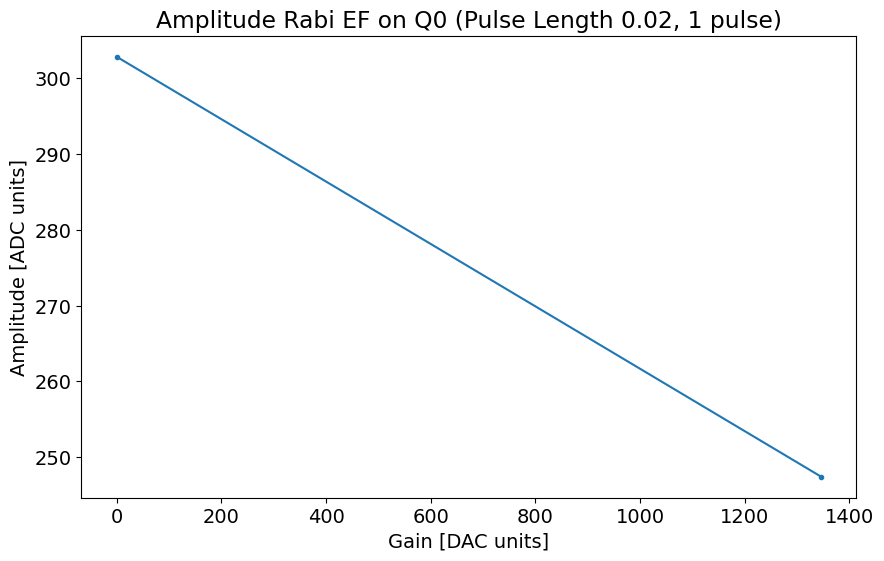

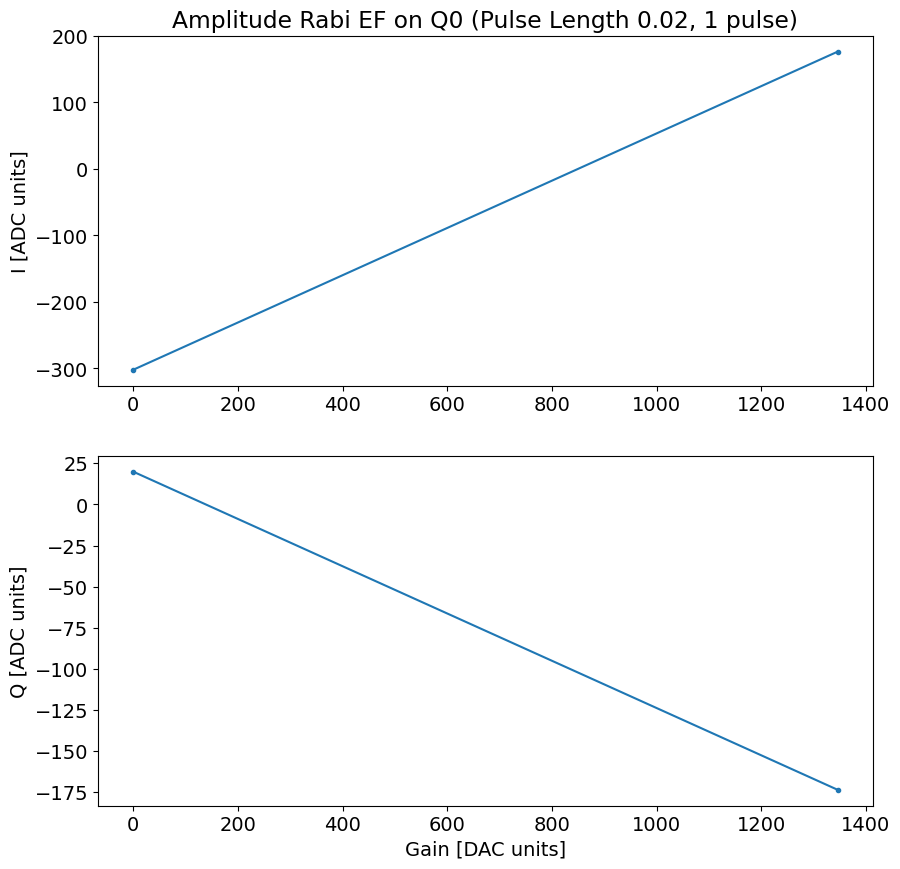

In [215]:
# # TESTING
# amprabiEF = meas.AmplitudeRabiEFExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramseyEF_qubit0.h5')
# data = amprabiEF.analyze(data=temp_data, fit=True)
# amprabiEF.display(data=data, fit=True)

# xdata = amprabiEF.data['xpts']
# fitparams=[None]*4
# fitparams[1]=2/xdata[-1]

# amprabiEF.analyze(fit=True, fitparams=fitparams)


# fit_axis = 'amps'
# # fit_axis = 'avgq'

# amprabiEF_data = amprabiEF.data[fit_axis]
# p = amprabiEF.data[f'fit_{fit_axis}']
# efamp = p[0]
# print('fit amplitude', efamp)
# efamp = max(amprabiEF.data[fit_axis]) - min(amprabiEF.data[fit_axis])
# print('max-min', efamp)


amprabiEF.display(fit=False)

In [ ]:
amprabiEF.save_data()

### Qubit temperature
Run amplitude rabi EF twice, once with and once without pulse_ge. Input the amplitude of the rabi oscillation (printed in the cell below) for each of these cases to calculate qubit temperature from the ratio.

In [ ]:
# NATRUAL CONSTANTS
h = 6.62607015e-34
fge = 1e6*(amprabiEF.cfg.device.qubit.f_ge[qubit_i] + amprabiEF.cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i])
kB = 1.380649e-23
################

fit_axis = 'amps'
# fit_axis = 'avgq'

efamp_normal = 372 
efamp_nopulse = 7.05

print('Qubit temp [mK]:', -1e3*h*fge/(kB*np.log(efamp_nopulse/efamp_normal)))

pop_e = efamp_nopulse/efamp_normal
print('Population in e:', pop_e)


## EF Ramsey Fringe
Update the ef frequency in <code>cfg.qubit.f_ef</code>.

In [ ]:
1/(soc.cycles2us(1)*151)

In [ ]:
t2EFr = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="ramseyEF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

t2EFr.cfg.expt = dict(
    start=0, # wait time tau [us]
    expts=150,
    step=soc.cycles2us(150), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    ramsey_freq=0.100, # [MHz]
    # step=soc.cycles2us(40), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    # ramsey_freq=0.300, # [MHz]
    checkZZ=False,
    checkEF=True,
    reps=100,
    rounds=30,
    qubits=[qubit_i],
)
t2EFr.cfg.device.readout.frequency = t2EFr.cfg.device.readout.frequency_ef

print(t2EFr.cfg)

t2EFr.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# # TESTING
# t2EFr = meas.RamseyEFExperiment(config_file=config_path)
# t2EFr.cfg.expt = dict(ramsey_freq=1, qubit=qubit_i)
# temp_data = prev_data(expt_path, '00000_ramseyEF_qubit0.h5')
# temp_data = temp_data[0]
# data = t2EFr.analyze(data=temp_data, fit=True)
# t2EFr.display(data=data, fit=True)

t2EFr.analyze(fit=True)
t2EFr.display(fit=True)

In [ ]:
t2EFr.save_data()

# F0 --> G1

In [183]:
f_ge = np.array(yaml_cfg.device.qubit.f_ge) + np.array(yaml_cfg.hw.soc.dacs.qubit.mixer_freq)
f_ef = np.array(yaml_cfg.device.qubit.f_ef) + np.array(yaml_cfg.hw.soc.dacs.qubit.mixer_freq)
f_res = np.array(yaml_cfg.device.readout.frequency) + np.array(yaml_cfg.hw.soc.dacs.readout.mixer_freq)

print(f'f_f0g1: {(f_ge + f_ef - f_res).tolist()}')

f_f0g1: [1186.6026343450158, 1001.040418667968, 1633.4027015931488, 1618.7163911025682]


In [85]:
qubit_i = 0

In [86]:
rabiF0G1FreqLenChevron = meas.F0G1FreqLenChevronExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"rabi_F0G1_freqlen_chevron_qubit{qubit_i}",
    config_file=config_path,
)

# span_f = 10 # MHz
# span_f = 3.0 # MHz
span_f = 1.5
# npts_f = 30
# span_f = 0.5
npts_f = 15

start_len = 0
# span_len = 2.0
span_len = 1.5*rabiF0G1FreqLenChevron.cfg.device.qubit.pulses.pi_f0g1.sigma[qubit_i]
npts_len = 20
# npts_len = 40

rabiF0G1FreqLenChevron.cfg.expt = dict(
    start_f=rabiF0G1FreqLenChevron.cfg.device.qubit.f_f0g1[qubit_i] - span_f/2, # start freq [MHz],
    step_f=span_f/npts_f, # freq step, 
    expts_f=npts_f, # number of different freq experiments, 
    start_len=start_len, # pulse length (sigma) [us]
    step_len=span_len/npts_len, # [us]
    expts_len=npts_len,
    gain=32000,
    reps=500,
    pulse_type='flat_top',
    # post_process='scale', #'threshold',
    # singleshot_reps=10000,
    measure_f=False,
    qubit=qubit_i,
)

# rabiF0G1FreqLenChevron.cfg.device.readout.readout_length = [15, 15] # [us]
# rabiF0G1FreqLenChevron.cfg.device.readout.relax_delay = [600, 50] # Wait time between experiments [us]

print(rabiF0G1FreqLenChevron.cfg)

import Pyro4.util
try:
    rabiF0G1FreqLenChevron.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-390.95193842109995, 5794.90833333, 501.288233333334, -229.87577390000007], 'frequency_ef': [-392.9315036040767, 5794.925333329999, 499.41074988962544, -231.37577390000007], 'gain': [0.25, 0.3, 0.85, 0.45], 'readout_length': [8.0, 10.0, 8.0, 6.0], 'readout_length_ef': [8.0, 7.0, 4.0, 4.0], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4110.4153676, 3448.27468154, 4762.18307375, 4381.643639996708], 'f_ef': [3884.3809607535322, 3347.761789059698, 4572.375572742949, 4209.906361998122], 'f_Q1_ZZ': [3442.909184486008, 0, 3447.0924878770584, 3446.9608452525486], 'f_Q_ZZ1': [4104.8259754819555, 0, 4761.14068386677, 4380.292188886469], 'f_ef_Q_ZZ1': [0, 0, 4570.466450039196, 4207.199191279], 'f_EgGf': [2686.53594683, 0, 2017.3, 2414.92850999], 'f_EgGf_Q': [0, 0, 5883.9, 5146.885], 'f_f0g1': [1184.4666666666667, 999.8, 1632.9833333333333, 1620.9166666666665], 'gs': [52.40296404695958, 54.8179445660

  0%|          | 0/15 [00:00<?, ?it/s]

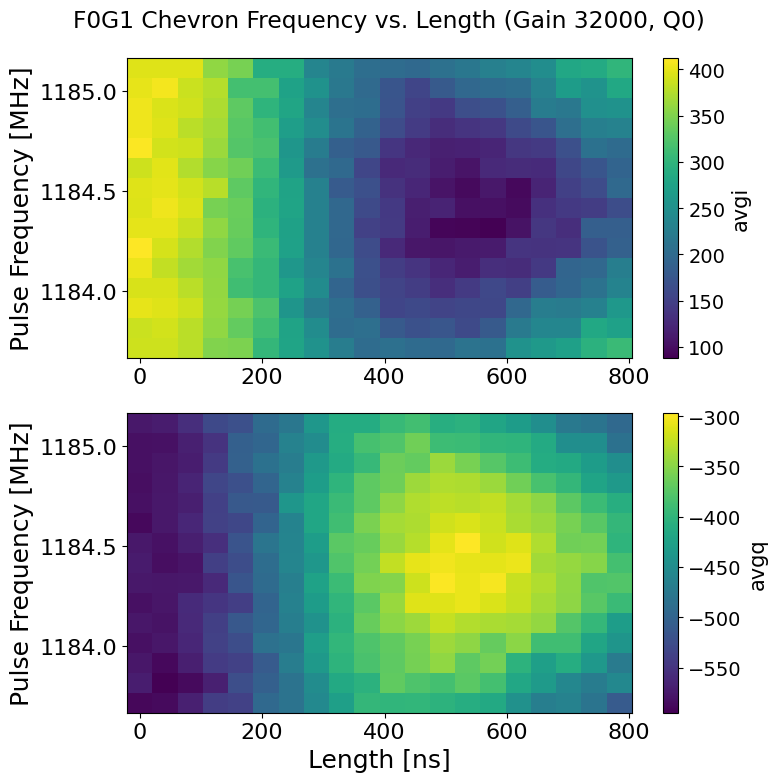

plot freq 1184.3166666666666 536.25
min q0 data_fitavgi 92.05537293485952
[[ 6 13]]
Q0 data_fitavgi freq 1184.3166666666666 len 536.25
plot freq 1184.4166666666667 536.25
max q0 data_fitavgq -297.98310541361633
[[ 7 13]]
Q0 data_fitavgq freq 1184.4166666666667 len 536.25


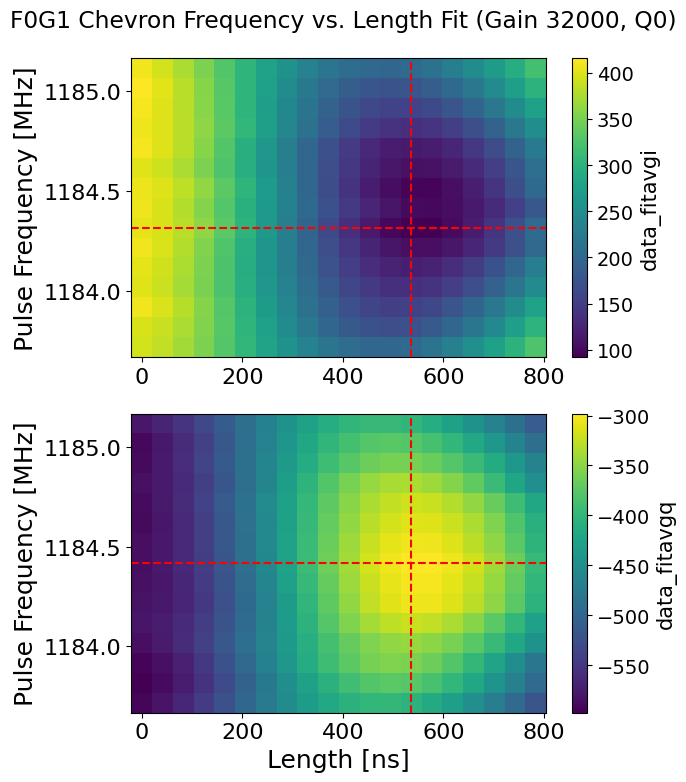

([None, None], [0.53625, 0.53625])

In [88]:
data = rabiF0G1FreqLenChevron.analyze(data=None)
rabiF0G1FreqLenChevron.display(data=data, fit=True, signs=[-1, 1]) #, plot_freq=1618.5, plot_len=600)

In [ ]:
rabiF0G1FreqLenChevron.save_data()

## Calibrate cool idle time

In [16]:
reps = 100
rounds = 10

In [75]:
qubit_i = 2

In [76]:
"""
amprabiEF1: program from amp rabi EF with ge pulse, should already ahve called analyze with fit=True
amprabiEF2: program from amp rabi EF without ge pulse
"""
# NATURAL CONSTANTS
h = 6.62607015e-34
fge = 1e6*(amprabiEF2.cfg.device.qubit.f_ge[qubit_i] + amprabiEF2.cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i])
kB = 1.380649e-23
################
def process_qubit_temp(amprabiEF1, amprabiEF2, verbose=True):
    # fitparams = [None]*4
    # fitparams[1] = 2/amprabiEF1.data['xpts'][-1]
    # amprabiEF1.analyze(fit=True, fitparams=fitparams)
    # fitparams[1] = 2/amprabiEF2.data['xpts'][-1]
    # amprabiEF2.analyze(fit=True, fitparams=fitparams)

    # amprabiEF2_fit, amprabiEF2_fit_err = meas.fitting.get_best_fit(amprabiEF2.data)

    fit_axis = 'amps'
    # fit_axis = 'avgq'

    # p = amprabiEF1.data[f'fit_{fit_axis}']
    # pCov = amprabiEF1.data[f'fit_err_{fit_axis}']
    efamp_normal = (max(amprabiEF1.data[fit_axis]) - min(amprabiEF1.data[fit_axis]))/2
    # err_normal = np.std(amprabiEF1.data[fit_axis][:5])
    # efamp_normal = p[0]
    # err_normal = pCov[0][0]

    # p = amprabiEF2.data[f'fit_{fit_axis}']
    # pCov = amprabiEF2.data[f'fit_err_{fit_axis}']
    efamp_nopulse = (max(amprabiEF2.data[fit_axis]) - min(amprabiEF2.data[fit_axis]))/2
    # err_nopulse = np.std(amprabiEF2.data[fit_axis][:5])
    # efamp_nopulse = p[0]
    # err_nopulse = pCov[0][0]
    # if verbose: print('err normal %', err_normal*100, 'err no pulse %', err_nopulse*100)

    # amprabiEF2.display(fit=True, fit_func='sin')
    # amprabiEF2.display(fit=False)

    temp = 1e3*-h*fge/(kB*np.log(efamp_nopulse/(efamp_normal+efamp_nopulse)))
    thermal_percent = efamp_nopulse/efamp_normal*100
    # thermal_percent_error = 100*efamp_nopulse/efamp_normal*np.sqrt((err_nopulse/efamp_nopulse)**2 + (err_normal/efamp_normal)**2)

    if verbose:
        print('yscale normal:', efamp_normal)
        print('yscale no pulse:', efamp_nopulse)
        print('Qubit temp [mK]:', temp)
        # print('Qubit E thermal population (%):', efamp_nopulse/efamp_normal*100, '+/-', thermal_percent_error)
        print('Qubit E thermal population (%):', efamp_nopulse/efamp_normal*100)
    
    # return temp, thermal_percent, thermal_percent_error
    return temp, thermal_percent, None

### Baseline qubit temperature

In [260]:
amprabiEF = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="amp_rabi_EF"+f"_qubit{qubit_i}",
    config_file=config_path,
)
pi_lenEF = amprabiEF.cfg.device.qubit.pulses.pi_ef.sigma[qubit_i]

span = min((32000, 5.0*amprabiEF.cfg.device.qubit.pulses.pi_ef.gain[qubit_i]))
# span = 20000
# span = 50
npts = 101

amprabiEF.cfg.expt = dict(
    start=0, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=reps,
    rounds=rounds,
    sigma_test=pi_lenEF*2, #/3, # gaussian sigma for pulse length - default from cfg [us]
    pulse_type='gauss',
    checkZZ=False,
    checkEF=True, 
    qubits=[qubit_i],
)

# print(amprabiEF.cfg)
amprabiEF.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/10 [00:00<?, ?it/s]

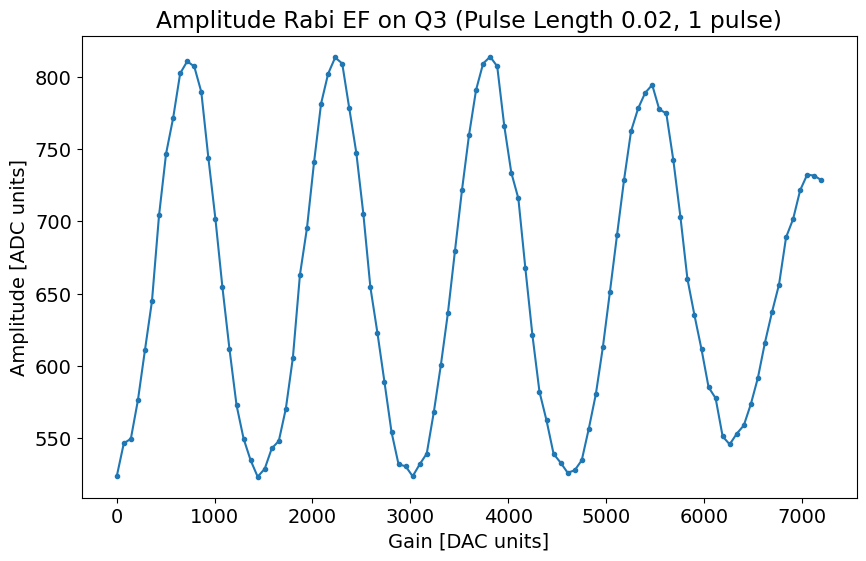

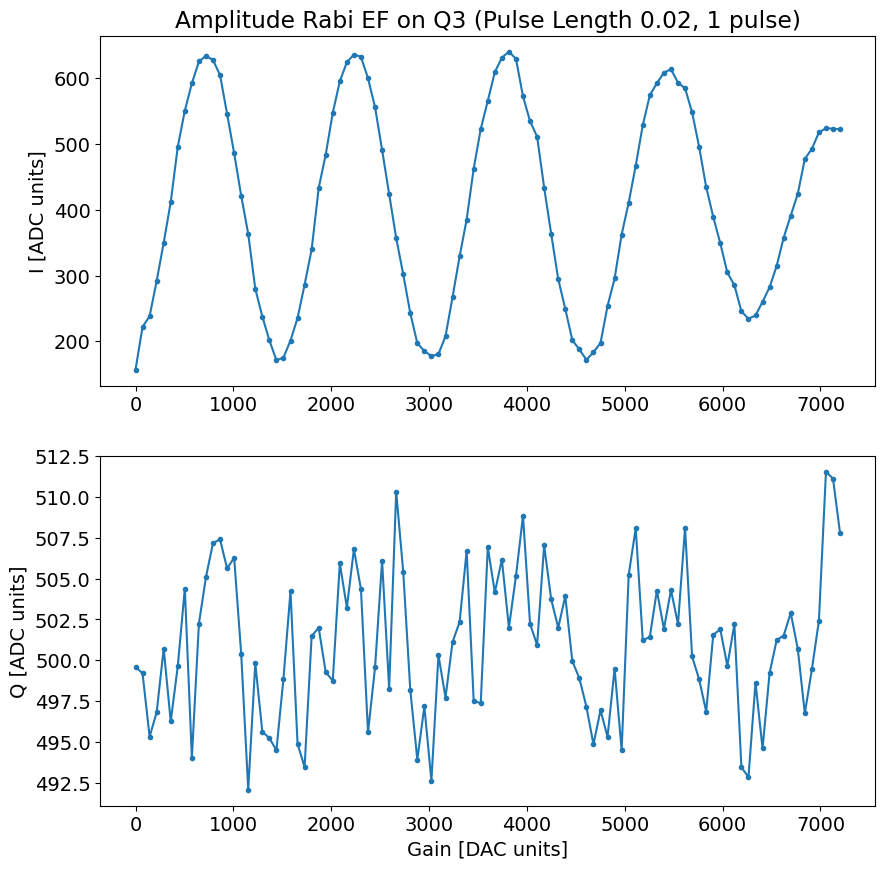

In [261]:
amprabiEF.display(fit=False)

  0%|          | 0/100 [00:00<?, ?it/s]

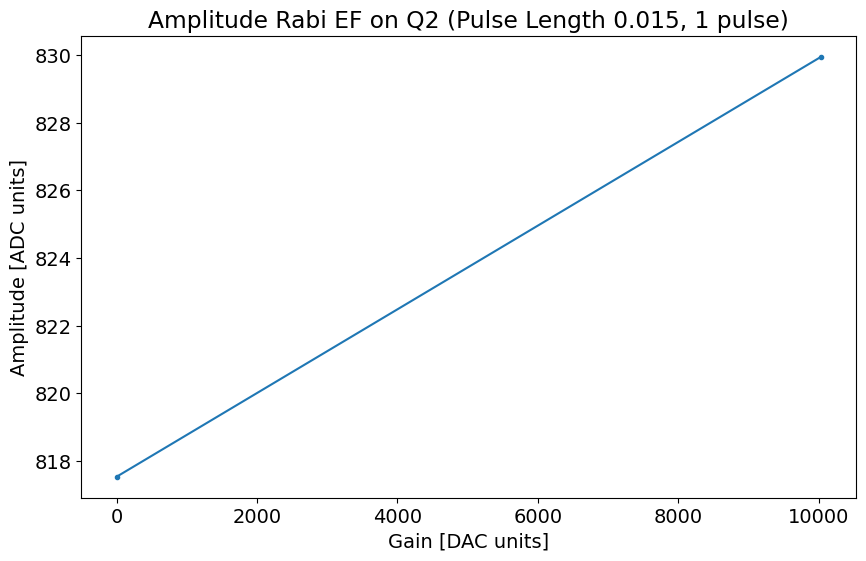

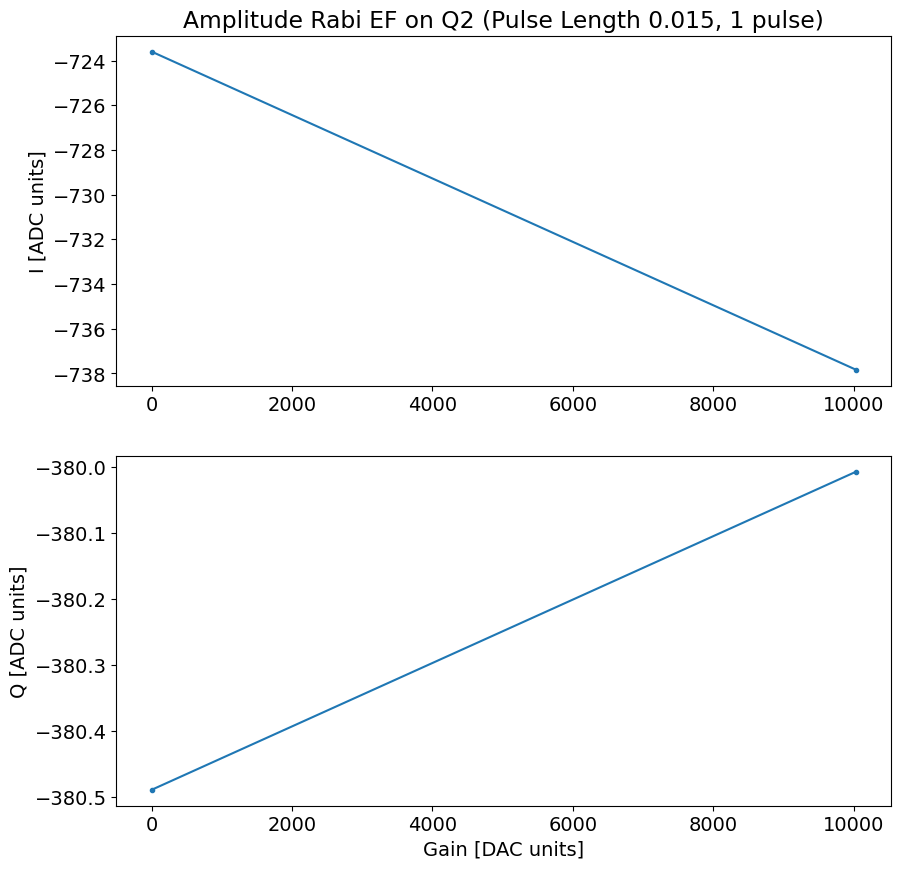

In [79]:
verbose = True

amprabiEF2_baseline = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="amp_rabi_EF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

reps_temp=500
rounds_temp=reps*rounds*50//500

amprabiEF2_baseline.cfg.expt = dict(
    start=0, # qubit gain [dac level]
    step=amprabiEF.cfg.device.qubit.pulses.pi_ef.gain[qubit_i],
    expts=2,
    reps=reps_temp,
    rounds=rounds_temp,
    sigma_test=pi_lenEF, # gaussian sigma for pulse length - default from cfg [us]
    pulse_ge=False, # set to false when measuring qubit temp
    pulse_type='gauss',
    checkZZ=False,
    checkEF=True, 
    qubits=[qubit_i],

    cool_qubits = None,
)

amprabiEF2_baseline.go(analyze=False, display=verbose, progress=verbose, save=False)

In [80]:
baseline_temp, baseline_thermal_percent, _ = process_qubit_temp(amprabiEF, amprabiEF2_baseline, verbose=True)

yscale normal: 227.03068119241527
yscale no pulse: 6.20728698128579
Qubit temp [mK]: 63.0247123574613
Qubit E thermal population (%): 2.7341181150863614


### Loop over different wait times

#### Loop amp rabi (temperature) measurement

In [81]:
expt_idle_sweep = Experiment(
    path=expt_path,
    prefix=f"cool_idle_time_sweep_qubit{qubit_i}",
    config_file=config_path,
)
expt_idle_sweep.data = dict(avgi=[], avgq=[], amps=[], xpts=[], idle_times=[])

# idle_time_sweep = np.linspace(0, 15, 5+1)
idle_time_sweep = [0, 3, 6, 9, 12, 15, 30]
# idle_time_sweep = np.linspace(0, 60, 4)
# idle_time_sweep = [0, 5, 10, 15, 20, 25, 30, 45]
# idle_time_sweep = [5, 10, 15, 30]
# idle_time_sweep = [5, 7, 10, 15]
# idle_time_sweep = [8, 9, 10, 11]
print(idle_time_sweep)

[0, 3, 6, 9, 12, 15, 30]


In [82]:
verbose = False

amprabiEF2 = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="amp_rabi_EF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

reps_temp=500
rounds_temp=reps*rounds*50//500

amprabiEF2.cfg.expt = dict(
    start=0, # qubit gain [dac level]
    step=amprabiEF.cfg.device.qubit.pulses.pi_ef.gain[qubit_i],
    expts=2,
    reps=reps_temp,
    rounds=rounds_temp,
    sigma_test=pi_lenEF, # gaussian sigma for pulse length - default from cfg [us]
    pulse_ge=False, # set to false when measuring qubit temp
    pulse_type='gauss',
    checkZZ=False,
    checkEF=True, 
    qubits=[qubit_i],

    # cool_qubits = None,
    cool_qubits=[qubit_i],
    # cool_idle=9.1, # us
)

# BEGIN LOOPING

for idle_time in tqdm(idle_time_sweep):
    amprabiEF2.cfg.expt.cool_idle = [idle_time]
    amprabiEF2.go(analyze=False, display=verbose, progress=verbose, save=False)
    expt_idle_sweep.data['avgi'].append(np.copy(amprabiEF2.data['avgi']))
    expt_idle_sweep.data['avgq'].append(np.copy(amprabiEF2.data['avgq']))
    expt_idle_sweep.data['amps'].append(np.copy(amprabiEF2.data['amps']))
    expt_idle_sweep.data['xpts'].append(np.copy(amprabiEF2.data['xpts']))
    expt_idle_sweep.data['idle_times'].append(idle_time)
    expt_idle_sweep.save_data()

100%|██████████| 7/7 [05:47<00:00, 49.68s/it]


In [83]:
print(expt_idle_sweep.save_data())

s:\Connie\experiments\qramLL_4QR2\data\data_240617\00005_cool_idle_time_sweep_qubit2.h5


baseline thermal population 2.7341181150863614

yscale normal: 227.03068119241527
yscale no pulse: 4.289187496301906
Qubit temp [mK]: 57.31336452580069
Qubit E thermal population (%): 1.8892545596807209
yscale normal: 227.03068119241527
yscale no pulse: 4.244640058594712
Qubit temp [mK]: 57.16645679119236
Qubit E thermal population (%): 1.8696327898506602
yscale normal: 227.03068119241527
yscale no pulse: 2.2363827072715594
Qubit temp [mK]: 49.36228225795467
Qubit E thermal population (%): 0.985057480128053
yscale normal: 227.03068119241527
yscale no pulse: 1.3582008051294565
Qubit temp [mK]: 44.595842996263585
Qubit E thermal population (%): 0.5982454873481795
yscale normal: 227.03068119241527
yscale no pulse: 0.16555376523479026
Qubit temp [mK]: 31.63622541327016
Qubit E thermal population (%): 0.07292131810787217
yscale normal: 227.03068119241527
yscale no pulse: 0.6688182545556174
Qubit temp [mK]: 39.20037205000325
Qubit E thermal population (%): 0.2945937751861714
yscale normal: 2

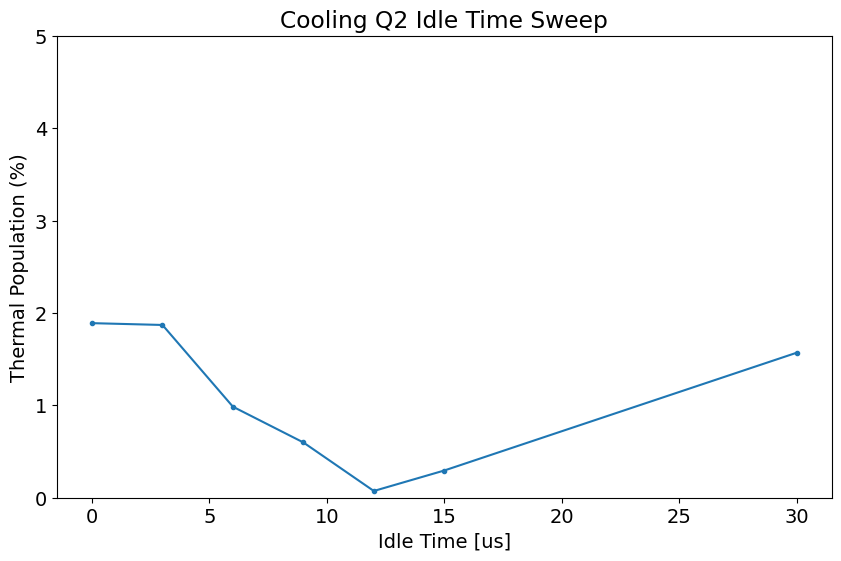

In [84]:
data = expt_idle_sweep.data

# data, attrs = prev_data('s:\Connie\experiments\qramLL_4QR2\data\data_240617\\00003_cool_idle_time_sweep_qubit3.h5')

idle_time_sweep = data['idle_times'] 

print('baseline thermal population', baseline_thermal_percent)
print()

temps = []
thermal_percents = []
thermal_percent_errors = []

for i, idle_time in enumerate(idle_time_sweep):
    amprabiEF2.data['avgi'] = np.copy(data['avgi'][i])
    amprabiEF2.data['avgq'] = np.copy(data['avgq'][i])
    amprabiEF2.data['amps'] = np.copy(data['amps'][i])
    amprabiEF2.data['xpts'] = np.copy(data['xpts'][i])
    temp, thermal_percent, thermal_percent_error = process_qubit_temp(amprabiEF, amprabiEF2, verbose=True)
    temps.append(temp)
    thermal_percents.append(thermal_percent)
    thermal_percent_errors.append(thermal_percent_error)

plt.figure()
# plt.errorbar(idle_time_sweep, thermal_percents, fmt='.-', yerr=thermal_percent_errors)
plt.title(f'Cooling Q{qubit_i} Idle Time Sweep')
plt.plot(idle_time_sweep, thermal_percents, '.-')
plt.xlabel('Idle Time [us]')
plt.ylabel('Thermal Population (%)')
plt.ylim(0, 5)
plt.show()

#### Loop ramsey measurement

In [ ]:
verbose = True

expt_idle_t2_sweep = Experiment(
    path=expt_path,
    prefix=f"cool_idle_time_t2_sweep_qubit{qubit_i}",
    config_file=config_path,
)
expt_idle_t2_sweep.data = dict(avgi=[], avgq=[], amps=[], xpts=[], idle_times=[])

idle_time_sweep = np.linspace(0, 60, 4)
print(idle_time_sweep)

t2r = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ramsey_qubit{qubit_i}",
    config_file=config_path,
)

ramsey_freq = 4.0

# make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
t2r.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(4), # [us] 
    # step=soc.cycles2us(2) if short_T1 else soc.cycles2us(10), # [us] 
    expts=150,
    ramsey_freq=ramsey_freq, # [MHz]
    reps=reps,
    rounds=rounds,
    qubits=[qubit_i],
    checkZZ=False,
    checkEF=False,

    # cool_qubits = None,
    cool_qubits=[qubit_i],
    # cool_idle=9.1, # us
)

# BEGIN LOOPING

for idle_time in tqdm(idle_time_sweep):
    t2r.cfg.expt.cool_idle = [idle_time]
    t2r.go(analyze=False, display=False, progress=verbose, save=False)
    t2r.display(fit=False)
    expt_idle_t2_sweep.data['avgi'].append(np.copy(t2r.data['avgi']))
    expt_idle_t2_sweep.data['avgq'].append(np.copy(t2r.data['avgq']))
    expt_idle_t2_sweep.data['amps'].append(np.copy(t2r.data['amps']))
    expt_idle_t2_sweep.data['xpts'].append(np.copy(t2r.data['xpts']))
    expt_idle_t2_sweep.data['idle_times'].append(idle_time)
    expt_idle_t2_sweep.save_data()

In [ ]:
idle_time_sweep = expt_idle_t2_sweep.data['idle_times'] 

qubit_freqs = []

old_qubit_freq = t2r.cfg.device.qubit.f_ge[t2r.cfg.expt.qubits[0]]

for i, idle_time in enumerate(idle_time_sweep):
    t2r.data['avgi'] = np.copy(expt_idle_t2_sweep.data['avgi'][i])
    t2r.data['avgq'] = np.copy(expt_idle_t2_sweep.data['avgq'][i])
    t2r.data['amps'] = np.copy(expt_idle_t2_sweep.data['amps'][i])
    t2r.data['xpts'] = np.copy(expt_idle_t2_sweep.data['xpts'][i])
    t2r.analyze(fit=True)
    t2r_fit, t2r_fit_err, t2r_adjust = meas.fitting.get_best_fit(t2r.data, get_best_data_params=['f_adjust_ramsey'])
    qubit_freq = old_qubit_freq + t2r_adjust[0]
    print(qubit_freq)
    qubit_freqs.append(qubit_freq)

plt.figure()
plt.plot(idle_time_sweep, np.array(qubit_freqs) - old_qubit_freq, '.-')
plt.xlabel('Idle Time [us]')
plt.ylabel('Qubit Freq - Original Freq (MHz)')
plt.show()

# AC stark shift

Determine how much effective power is being applied for a drive detuned from qubit frequency

In [297]:
qubit_i = 3

In [301]:
acspec = meas.ACStarkShiftPulseProbeExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ac_stark_shift_qubit{qubit_i}",
    config_file=config_path,
)

span_f = 30
npts_f = 100

start_gain = 0
span_gain = 15000
npts_gain = 50

# start_gain = 15000
# span_gain = 15000
# npts_gain = 15

# span_gain = 0
# npts_gain = 1

probe_params=dict( # to probe the qubit frequency
    ch=5,
    type='full',
    mixer_freq=0,
    nyquist=2,
)

pump_params=dict( # to try to stark shift the qubit
    ch=qubit_i, # check to make sure this is the right channel!!!
    type='full',
    mixer_freq=0,
    nyquist=2,
)

acspec.cfg.expt = dict(
    # PROBE PARAMETERS
    # start_f=acspec.cfg.device.qubit.f_ge[qubit_i]-span_f/2, # probe frequency [MHz]
    start_f=acspec.cfg.device.qubit.f_ge[qubit_i]-0.9*span_f, # probe frequency [MHz]
    # start_f=acspec.cfg.device.qubit.f_ge[qubit_i]-0.1*span_f, # probe frequency [MHz]
    step_f=span_f/npts_f,
    expts_f=npts_f,

    probe_params=probe_params, 
    probe_length=5, # [us]
    probe_gain=3000,
    probe_pulse_type='flat_top',


    # PUMP PARAMETERS
    start_gain=start_gain, # pump tone gain
    step_gain=int(span_gain/npts_gain),
    expts_gain=npts_gain+1,

    # pump_params=acspec.cfg.hw.soc.dacs.swap,
    pump_params=pump_params,
    # pump_freq=3300,
    pump_freq=acspec.cfg.device.qubit.f_ge[qubit_i]+100,
    # pump_freq=acspec.cfg.device.qubit.f_ge[qubit_i]-100,
    # pump_freq=acspec.cfg.device.qubit.f_EgGf[2],
    pump_length=5, # [us]
    pump_pulse_type='flat_top',
    pump_ramp_us=0.006, # [us]

    reps=50,
    rounds=10, # Number averages per point
    qubit=qubit_i,
)
acspec.cfg.device.readout.relax_delay = 25
print(acspec.cfg)

acspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-390.95193842109995, 5794.90833333, 501.288233333334, -229.87577390000007], 'frequency_ef': [-392.9315036040767, 5794.925333329999, 499.41074988962544, -231.37577390000007], 'gain': [0.25, 0.3, 0.85, 0.35], 'readout_length': [8.0, 10.0, 8.0, 6.0], 'readout_length_ef': [8.0, 7.0, 4.0, 6.0], 'relax_delay': 25}, 'qubit': {'f_ge': [4110.120468874234, 3448.1789080733843, 4762.249073987997, 4381.601838787919], 'f_ef': [3884.967202697702, 3347.761789059698, 4572.328169162723, 4209.612874544659], 'f_Q1_ZZ': [3442.817665250723, 0, 3447.0924878770584, 3446.8884296904694], 'f_Q_ZZ1': [4104.7742544709245, 0, 4761.14068386677, 4379.46426116178], 'f_EgGf': [2686.53594683, 0, 2017.3, 2414.92850999], 'f_EgGf_Q': [0, 0, 5884.159166666667, 5144.185], 'f_f0g1': [1183.9, 999.7, 1632.9333333333334, 1618.5666666666666], 'gs': [52.40296404695958, 54.81794456602636, 43.49513117058557, 4.930653352423196, 2.6415018214608046, 

  0%|          | 0/51 [00:00<?, ?it/s]

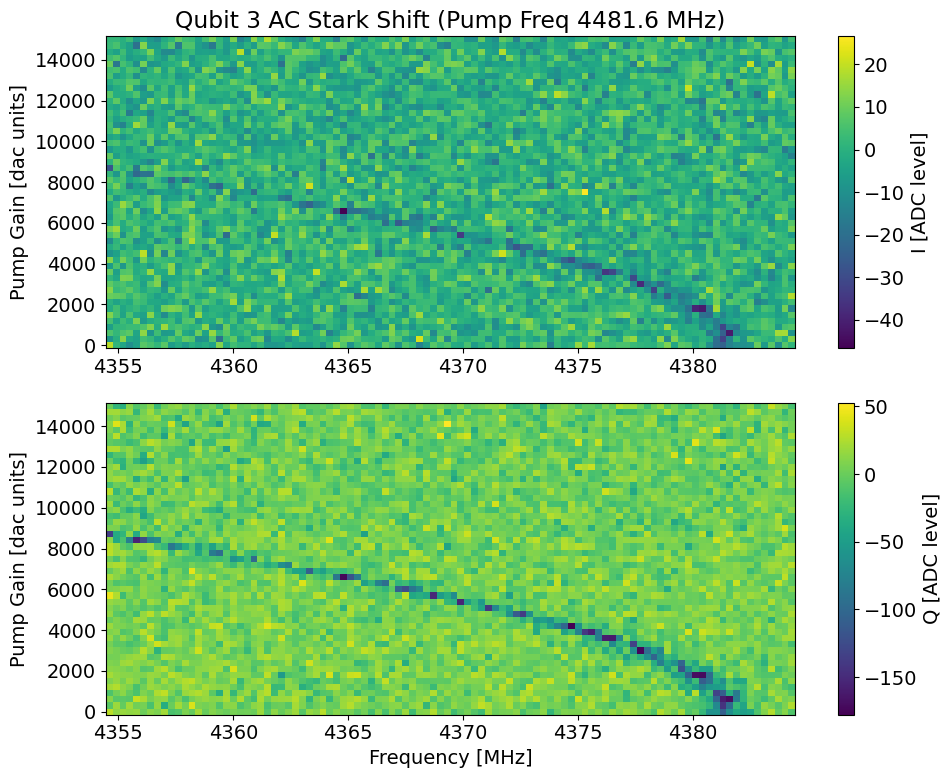

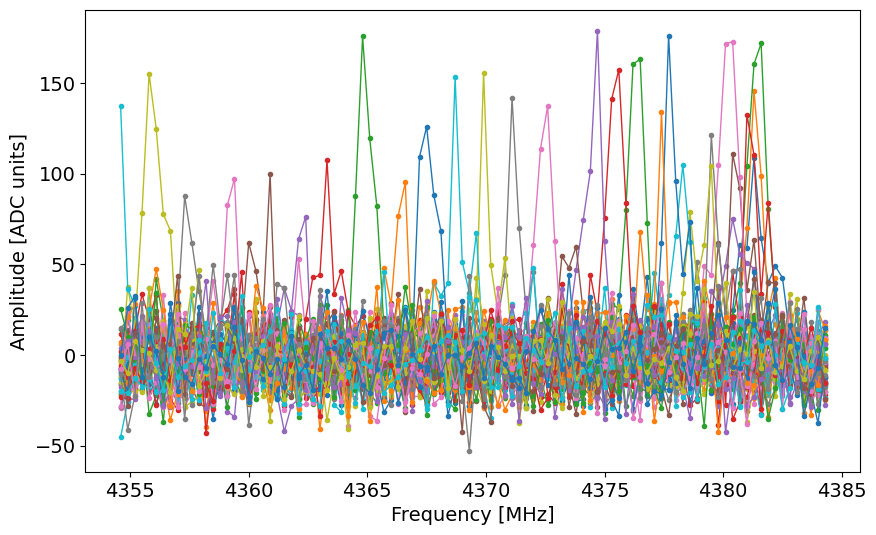

In [302]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = acspec.analyze(data=temp_data)

acspec.analyze()
acspec.display()

data = np.copy(acspec.data['amps'])
for i in range(len(data)):
    data[i] -= np.average(data[i])
freqpts = acspec.data['freqpts'] # inner sweep
gainpts = acspec.data['gainpts'] # outer sweep

plt.figure()
for i in range(len(gainpts)):
    # if i!=3: continue
    plt.plot(freqpts, data[i], '.-', linewidth=1, label=f'gain {gainpts[i]}')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Amplitude [ADC units]')
# plt.legend()
plt.show()

In [ ]:
acspec.save_data()

# Single qubit RB

In [251]:
qubit_i = 2
# qubits = [2, 1]
# qubit_i = qubits[0]

{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-390.95193842109995, 5794.90833333, 501.288233333334, -229.94910723], 'frequency_ef': [-392.9315036040767, 5794.925333329999, 499.41074988962544, -231.37577390000007], 'gain': [0.25, 0.3, 0.85, 0.35], 'readout_length': [8.0, 10.0, 7.0, 6.0], 'readout_length_ef': [8.0, 7.0, 4.0, 4.0], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4110.42834951, 3448.19703452, 4762.18199758, 4381.641411878756], 'f_ef': [3884.3809607535322, 3347.761789059698, 4572.363929531337, 4209.91711365584], 'f_Q1_ZZ': [3442.909184486008, 0, 3447.0924878770584, 3446.9608452525486], 'f_Q_ZZ1': [4104.8259754819555, 0, 4761.14068386677, 4380.292188886469], 'f_ef_Q_ZZ1': [0, 0, 4570.466450039196, 4207.199191279], 'f_EgGf': [2686.53594683, 0, 2017.3, 2414.92850999], 'f_EgGf_Q': [0, 0, 5883.99, 5146.885], 'f_f0g1': [1184.4, 999.8, 1632.9833333333333, 1620.9166666666665], 'gs': [52.40296404695958, 54.81794456602636, 43.49513117

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (2)


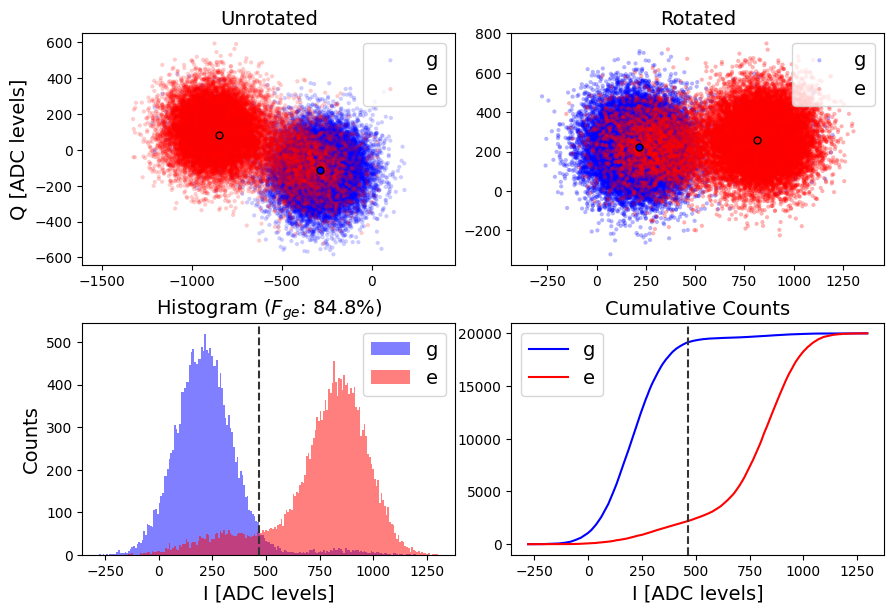

ge fidelity (%): 84.80499999999999
Qubit  (3)


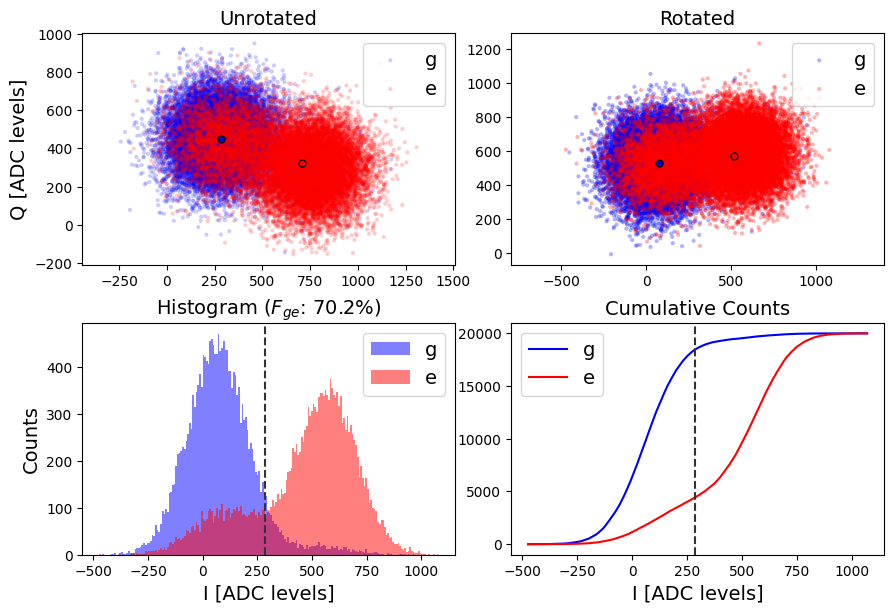

ge fidelity (%): 70.21
thresholds=[0, 0, 465.8378638290477, 286.4217886757025],
angles=[0, 0, -155.67096502615877, 24.504173693253968],
ge_avgs=[array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), [-296.25900925581396, -111.46101790697675, -809.0280926046511, 80.33041486046513], [294.94807612588176, 446.9810862452523, 658.6583817417255, 326.3913309549647]],
counts_calib=[[17541, 1571, 809, 79], [4156, 14982, 192, 670], [1987, 168, 16384, 1461], [521, 1809, 3827, 13843]]


  0%|          | 0/10 [00:00<?, ?it/s]

gate list ['X', 'X'] popln 0.020596989874220966
gate list ['X/2,-Z/2', 'X/2,-Z/2'] popln 0.01723676
gate list ['-X/2,Z/2', '-X/2,Z/2'] popln 0.015654639983221936
gate list ['-X/2,Z', '-X/2,Z'] popln 0.006523232270682715
gate list ['Z', 'Z'] popln 0.0010448339949498432
gate list ['Y', 'Y'] popln 0.03295736633537798
gate list ['Y,Z/2', 'Y,Z/2'] popln 0.02654405887837909
gate list ['-Y/2,Z', '-Y/2,Z'] popln 0.00781081
gate list ['Y/2,Z/2', 'Y/2,Z/2'] popln 0.007837293974545705
gate list ['-X/2,Z', '-X/2,Z'] popln 0.013903373093250187
gate list ['-Y/2', '-Y/2'] popln 0.005207394086829366
gate list ['X,Z/2', 'X,Z/2'] popln 0.030993297039389252
gate list ['-X/2,Z', '-X/2,Z'] popln 0.02319217052234541
gate list ['Y/2,Z/2', 'Y/2,Z/2'] popln 0.010691113088628386
gate list ['X/2,-Z/2', 'X/2,-Z/2'] popln 0.019393835969709863
gate list ['X,Z/2', 'X,Z/2'] popln 0.019884198638714285
gate list ['X/2', 'X/2'] popln 0.008131270908710344
gate list ['I', 'I'] popln 0.001006776016148629
gate list ['Y', 'Y

In [252]:
rbprog = meas.SimultaneousRBExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"rb1Q_qubit{qubit_i}",
    config_file=config_path,
)

rbprog.cfg.expt = dict(
    start=1, # rb depth start
    # step=15, # step rb depth
    step=5, # step rb depth
    expts=10, # number steps
    reps=1000, # number averages per unique sequence
    variations=30, # number different sequences per depth
    gate_char=None, # single qubit clifford gate (str) to characterize. if not None, runs interleaved RB instead of regular RB
    use_EgGf_subspace=False, # specifies whether to run RB treating EgGf as the TLS subspace
    qubits=[qubit_i], # the qubits to perform simultaneous RB on (if eg-gf, q should be qA != 1)
    # qubits=qubits,
    # qDrive=qubits[0],
    singleshot_reps=20000, # reps per state for singleshot calibration
    post_process='threshold', # 'threshold' (uses single shot binning), 'scale' (scale by ge_avgs), or None

    # thresholds=[0, 613.9114184246247, 507.47891189954305, 0],
    # angles=[0, -101.54512016437148, 72.02480620589141, 0],
    # ge_avgs=[array([0., 0., 0., 0.]), [-101.85060937209302, 466.51286116279067, -154.72153951162792, 742.5887439767441], [21.863250678241997, -256.37994772110693, 120.73579574064026, -794.2915984536081], array([0., 0., 0., 0.])],
    # counts_calib=[[16238, 3110, 527, 125], [3374, 16034, 95, 497], [1968, 395, 14344, 3293], [494, 2404, 2838, 14264]]
)
# rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i] = int(0.8*rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i])
# rbprog.cfg.device.readout.relax_delay = 1
# rbprog.cfg.device.readout.readout_length = 5

print(rbprog.cfg)

import Pyro4.util
try:
    rbprog.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

# rbprog.go(analyze=False, display=False, progress=True, save=False)

Running regular RB
Depolarizing parameter p from fit: 0.8732910346410059 +/- 0.02977641638382192
Average RB gate error: 0.06335448267949706 +/- 0.01488820819191096
	Fidelity=1-error: 0.9366455173205029 +/- 0.01488820819191096


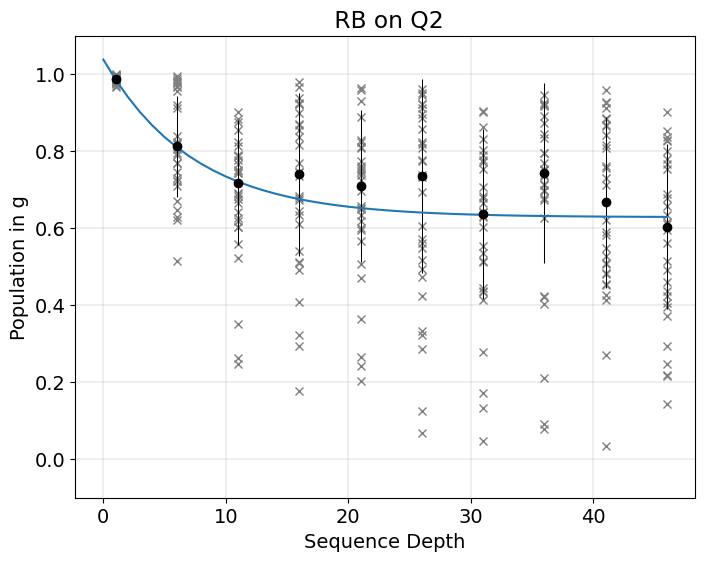

In [253]:
rbprog.analyze(fit=True)
rbprog.display(fit=True, qubit=[qubit_i])

In [ ]:
p_irb = 0.913
p_rb = 0.949  
print(100*meas.fitting.rb_error(p_rb, 2),'% average error')
print(100*(1-meas.fitting.rb_gate_fidelity(p_rb, p_irb, 2)), '% gate error')

In [ ]:
qDrive = qubits[0]
setup_ZZ = 0

In [ ]:
rbprog.save_data()

# Repeat over time

In [98]:
import time

### Qubit temperature repeat over time

In [206]:
qubit_i = 0
# cool_qubits = [2]
cool_qubits = None

In [207]:
debug = False

start_time = time.time()

all_temps = []
times = []
saved_files_normal = []
saved_files_nopulse = []

if debug:
    max_time = 5*60
    print_time = 0
    wait_time = 0
else:
    max_time = 13*60*60
    print_time = 0.5*60*60
    wait_time = 0*60

time_of_last_print = time.time()

expt_temp_sweep = Experiment(
    path=expt_path,
    prefix=f"temp_sweep_qubit{qubit_i}",
    config_file=config_path,
)
expt_temp_sweep.data = dict(xpts=[], avgi1=[], avgq1=[], amps1=[], avgi2=[], avgq2=[], amps2=[], popln_therms=[], times=[])

reps = 50000

# NATURAL CONSTANTS
h = 6.62607015e-34
kB = 1.380649e-23
################

In [208]:
while time.time() - start_time < max_time:
    
    try:
        amprabiEF = meas.AmplitudeRabiExperiment(
            soccfg=soc,
            path=expt_path,
            prefix=f"amprabiEF_qubit{qubit_i}",
            config_file=config_path,
        )
        amprabiEF.cfg.expt = dict(
            start=0,
            step=amprabiEF.cfg.device.qubit.pulses.pi_ef.gain[qubit_i],
            expts=2,
            reps=1000,
            rounds=reps//1000,
            pulse_type='gauss',
            checkZZ=False,
            checkEF=True, 
            qubits=[qubit_i],
            cool_qubits=cool_qubits,
        )

        amprabiEF.go(analyze=False, display=False, progress=True, save=False)

    except KeyboardInterrupt as err:
        print(f'caught KeyboardInterrupt, stopping after {len(expt_temp_sweep.data["times"])} iterations')
        # raise err
    except Exception as e:
        print('encountered error', e)
        continue

    # expt_temp_sweep.data['xpts'].append(amprabiEF.data['xpts'])
    expt_temp_sweep.data['avgi1'].append(amprabiEF.data['avgi'])
    expt_temp_sweep.data['avgq1'].append(amprabiEF.data['avgq'])
    expt_temp_sweep.data['amps1'].append(amprabiEF.data['amps'])

    try:
        amprabiEF2 = meas.AmplitudeRabiExperiment(
            soccfg=soc,
            path=expt_path,
            prefix="amprabi_EF"+f"_qubit{qubit_i}",
            config_file=config_path,
        )
        
        amprabiEF2.cfg.expt = dict(
            start=0,
            step=amprabiEF2.cfg.device.qubit.pulses.pi_ef.gain[qubit_i],
            expts=2,
            reps=1000,
            rounds=reps//1000,
            pulse_type='gauss',
            checkZZ=False,
            checkEF=True, 
            pulse_ge=False,
            qubits=[qubit_i],
            cool_qubits=cool_qubits,
        )

        amprabiEF2.go(analyze=False, display=False, progress=True, save=False)

    except KeyboardInterrupt as err:
        print(f'caught KeyboardInterrupt, stopping after {len(expt_temp_sweep.data["times"])} iterations')
        # raise err
    except Exception as e:
        print('encountered error', e)
        continue

    expt_temp_sweep.data['xpts'].append(amprabiEF2.data['xpts'])
    expt_temp_sweep.data['avgi2'].append(amprabiEF2.data['avgi'])
    expt_temp_sweep.data['avgq2'].append(amprabiEF2.data['avgq'])
    expt_temp_sweep.data['amps2'].append(amprabiEF2.data['amps'])

    fit_axis = 'amps'
    # fit_axis = 'avgq'

    amprabiEF_data = amprabiEF.data[fit_axis]
    efamp_normal = (max(amprabiEF_data) - min(amprabiEF_data))/2
    # p = amprabiEF.data[f'fit_{fit_axis}']
    # efamp_normal = p[0]

    amprabiEF2_data = amprabiEF2.data[fit_axis]
    efamp_nopulse = (max(amprabiEF2_data) - min(amprabiEF2_data))/2
    # p = amprabiEF2.data[f'fit_{fit_axis}']
    # efamp_nopulse = p[0]

    fge = 1e6*(amprabiEF2.cfg.device.qubit.f_ge[qubit_i] + amprabiEF2.cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i])

    temp = 1e3*-h*fge/(kB*np.log(efamp_nopulse/(efamp_normal+efamp_nopulse)))
    popln_therm = efamp_nopulse/efamp_normal*100

    expt_temp_sweep.data['popln_therms'].append(popln_therm)
    expt_temp_sweep.data['times'].append(time.time()-start_time)
    print(expt_temp_sweep.save_data())



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

s:\Connie\experiments\qramLL_4QR2\data\data_240617\00000_temp_sweep_qubit0.h5


  0%|          | 0/50 [00:00<?, ?it/s]

caught KeyboardInterrupt, stopping after 1 iterations


AttributeError: 'AmplitudeRabiExperiment' object has no attribute 'data'

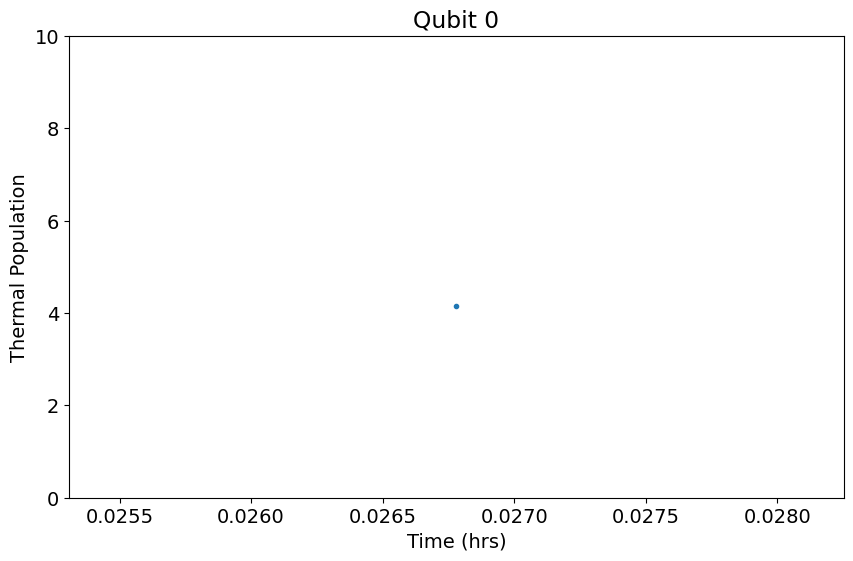

In [209]:
times = np.asarray(expt_temp_sweep.data['times'])
plt.figure(figsize=(10, 6))
plt.plot(times/60/60, expt_temp_sweep.data['popln_therms'], '.-')
plt.title(f'Qubit {qubit_i}')
plt.xlabel('Time (hrs)')
plt.ylabel('Thermal Population')
plt.ylim(0, 10)
# plt.xlim(12, None)
plt.show()

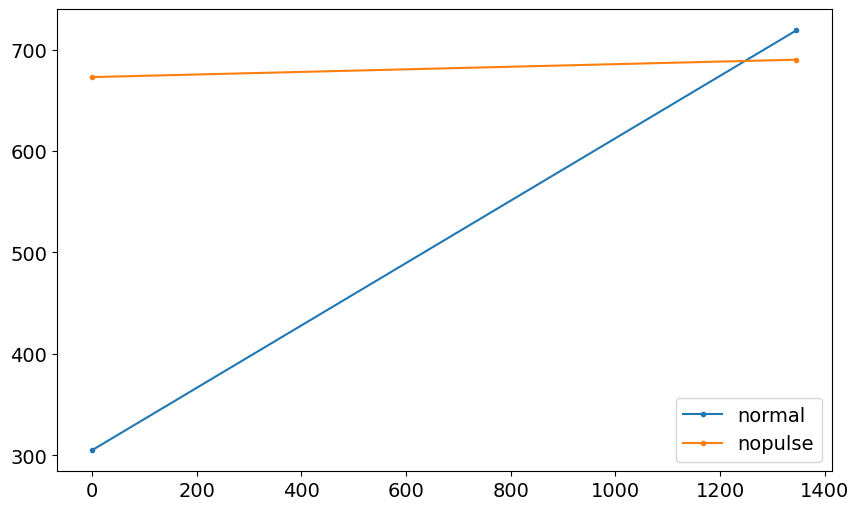

In [210]:
indx = -1
plt.plot(expt_temp_sweep.data['xpts'][indx], expt_temp_sweep.data['amps1'][indx], '.-', label='normal')
plt.plot(expt_temp_sweep.data['xpts'][indx], expt_temp_sweep.data['amps2'][indx], '.-', label='nopulse')
plt.legend()
plt.show()

In [ ]:
all_temps = []
h = 6.62607015e-34
kB = 1.380649e-23
for i in range(1, 62):
    lengthrabiEF = meas.LengthRabiExperiment(config_file=config_path,)
    if i < 10: temp_data, attrs = prev_data(expt_path, f'0000{i}_length_rabiEF_qubit1.h5')
    else: temp_data, attrs = prev_data(expt_path, f'000{i}_length_rabiEF_qubit1.h5')
    lengthrabiEF.cfg = AttrDict(attrs['config'])
    lengthrabiEF.data = temp_data

    lengthrabiEF.analyze(fit=True, fit_func='sin')

    # lengthrabiEF_fit, lengthrabiEF_fit_err = meas.fitting.get_best_fit(lengthrabiEF.data) #, fitfunc=fitter.decaysin)

    fit_axis = 'avgq'

    lengthrabiEF_data = lengthrabiEF.data[fit_axis]
    p = lengthrabiEF.data[f'fit_{fit_axis}']
    efamp_normal = p[0]

    lengthrabiEF2 = meas.LengthRabiExperiment(config_file=config_path,)
    if i < 10: temp_data, attrs = prev_data(expt_path, f'0000{i}_length_rabi_EF_qubit1.h5')
    else: temp_data, attrs = prev_data(expt_path, f'000{i}_length_rabi_EF_qubit1.h5')
    lengthrabiEF2.cfg = AttrDict(attrs['config'])
    lengthrabiEF2.data = temp_data

    lengthrabiEF2.analyze(fit=True, fit_func='sin')

    lengthrabiEF2_data = lengthrabiEF2.data[fit_axis]
    p = lengthrabiEF2.data[f'fit_{fit_axis}']
    efamp_nopulse = p[0]

    qubit_i = lengthrabiEF2.cfg.expt.qubits[0]

    fge = 1e6*(lengthrabiEF2.cfg.device.qubit.f_ge[qubit_i] + lengthrabiEF2.cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i])

    temp = 1e3*-h*fge/(kB*np.log(efamp_nopulse/(efamp_normal+efamp_nopulse)))
    all_temps.append(temp)

In [ ]:
t2r = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ramsey_qubit{qubit_i}",
    config_file=config_path,
)

t2r.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(100), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    expts=250,
    ramsey_freq=0.2, # [MHz]
    reps=100,
    rounds=15,
    qubits=[qubit_i],
    checkZZ=False,
    checkEF=False,
)
t2r.go(analyze=True, display=True, progress=True, save=False)
t2r_fit, t2r_fit_err, t2r_adjust = meas.fitting.get_best_fit(t2r.data, get_best_data_params=['f_adjust_ramsey'])

### Single shot, T1, T2R repeat over time

In [ ]:
debug = False

start_time = time.time()

if debug:
    max_time = 5*60
    wait_time = 0
else:
    max_time = 50*60*60
    wait_time = 0*60

ss_sweep_expts = []
t1_sweep_expts = []
t2r_sweep_expts = []

for qubit_i in range(4):
    expt_ss_sweep = Experiment(
        path=expt_path,
        prefix=f"single_shot_time_sweep_qubit{qubit_i}",
        config_file=config_path,
    )
    expt_ss_sweep.data = dict(Ig=[], Qg=[], Ie=[], Qe=[], fids=[], times=[])

    expt_t1_sweep = Experiment(
        path=expt_path,
        prefix=f"t1_time_sweep_qubit{qubit_i}",
        config_file=config_path,
    )
    expt_t1_sweep.data = dict(xpts=[], avgi=[], avgq=[], amps=[], t1_fit=[], t1_fit_err=[], times=[])


    expt_t2r_sweep = Experiment(
        path=expt_path,
        prefix=f"t2r_time_sweep_qubit{qubit_i}",
        config_file=config_path,
    )
    expt_t2r_sweep.data = dict(xpts=[], avgi=[], avgq=[], amps=[], t2r_fit=[], t2r_fit_err=[], times=[])

    ss_sweep_expts.append(expt_ss_sweep)
    t1_sweep_expts.append(expt_t1_sweep)
    t2r_sweep_expts.append(expt_t2r_sweep)


while time.time() - start_time < max_time:
    for qubit_i in range(4):
        expt_ss_sweep = ss_sweep_expts[qubit_i]
        expt_t1_sweep = t1_sweep_expts[qubit_i]
        expt_t2r_sweep = t2r_sweep_expts[qubit_i]

        try:
            shot = meas.HistogramExperiment(
                soccfg=soc,
                path=expt_path,
                prefix=f"single_shot_qubit{qubit_i}",
                config_file=config_path,
            )

            shot.cfg.expt = dict(
                reps=20000,
                check_f=False,
                qubit=qubit_i,
            )
            shot.go(analyze=False, display=debug, progress=False, save=False)
            shot.analyze(verbose=False)

        except KeyboardInterrupt as err:
            print(f'caught KeyboardInterrupt, stopping after {len(expt_ss_sweep.data["times"])} iterations')
            raise err
        except Exception as e:
            print('encountered error', e)
            continue

        expt_ss_sweep.cfg = shot.cfg
        expt_ss_sweep.data['Ig'].append(shot.data['Ig'])
        expt_ss_sweep.data['Qg'].append(shot.data['Qg'])
        expt_ss_sweep.data['Ie'].append(shot.data['Ie'])
        expt_ss_sweep.data['Qe'].append(shot.data['Qe'])
        expt_ss_sweep.data['fids'].append(shot.data['fids'][0])
        expt_ss_sweep.data['times'].append(time.time()-start_time)
        print(expt_ss_sweep.save_data())


        try:
            t1 = meas.T1Experiment(
                soccfg=soc,
                path=expt_path,
                prefix=f"t1_qubit{qubit_i}",
                config_file=config_path,
            )

            span = 50
            npts = 151

            t1.cfg.expt = dict(
                start=0, # wait time [us]
                step=span/npts,
                expts=npts,
                reps=200,
                rounds=10,
                qubit=qubit_i,
            )
            t1.go(analyze=True, display=debug, progress=False, save=False)
            t1_fit, t1_fit_err = meas.fitting.get_best_fit(t1.data) #, fitter.expfunc)

            expt_t1_sweep.cfg = t1.cfg
            expt_t1_sweep.data['xpts'].append(t1.data['xpts'])
            expt_t1_sweep.data['avgi'].append(t1.data['avgi'])
            expt_t1_sweep.data['avgq'].append(t1.data['avgq'])
            expt_t1_sweep.data['amps'].append(t1.data['amps'])
            expt_t1_sweep.data['t1_fit'].append(t1_fit[3])
            expt_t1_sweep.data['t1_fit_err'].append(np.sqrt(t1_fit_err[3][3]))
            expt_t1_sweep.data['times'].append(time.time()-start_time)
            print(expt_t1_sweep.save_data())

        except KeyboardInterrupt as err:
            print(f'caught KeyboardInterrupt, stopping after {len(expt_ss_sweep.data["times"])} iterations')
            raise err
        except Exception as e:
            print('encountered error', e)
            continue



        try:
            t2r = meas.RamseyExperiment(
                soccfg=soc,
                path=expt_path,
                prefix=f"ramsey_qubit{qubit_i}",
                config_file=config_path,
            )

            t2r.cfg.expt = dict(
                start=0, # wait time tau [us]
                # step=soc.cycles2us(100), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
                # ramsey_freq=0.2, # [MHz]
                step=soc.cycles2us(8), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
                ramsey_freq=3.0, # [MHz]
                expts=200,
                reps=200,
                rounds=15,
                qubits=[qubit_i],
                checkZZ=False,
                checkEF=False,
            )
            t2r.go(analyze=True, display=debug, progress=False, save=False)
            t2r_fit, t2r_fit_err, t2r_adjust = meas.fitting.get_best_fit(t2r.data, get_best_data_params=['f_adjust_ramsey'])

            expt_t2r_sweep.cfg = t2r.cfg
            expt_t2r_sweep.data['xpts'].append(t2r.data['xpts'])
            expt_t2r_sweep.data['avgi'].append(t2r.data['avgi'])
            expt_t2r_sweep.data['avgq'].append(t2r.data['avgq'])
            expt_t2r_sweep.data['amps'].append(t2r.data['amps'])
            expt_t2r_sweep.data['t2r_fit'].append(t2r_fit[3])
            expt_t2r_sweep.data['t2r_fit_err'].append(np.sqrt(t2r_fit_err[3][3]))
            expt_t2r_sweep.data['times'].append(time.time()-start_time)
            print(expt_t2r_sweep.save_data())

        except KeyboardInterrupt as err:
            print(f'caught KeyboardInterrupt, stopping after {len(expt_t2r_sweep.data["times"])} iterations')
            raise err
        except Exception as e:
            print('encountered error', e)
            continue

        time.sleep(wait_time)


In [ ]:
qubit_i = 2

expt_ss_sweep = Experiment(config_file=config_path)
temp_data, attrs = prev_data(expt_path, f'00002_single_shot_time_sweep_qubit{qubit_i}.h5')
expt_ss_sweep.cfg = AttrDict(attrs['config'])
expt_ss_sweep.data = temp_data

expt_t1_sweep = Experiment(config_file=config_path)
temp_data, attrs = prev_data(expt_path, f'00002_t1_time_sweep_qubit{qubit_i}.h5')
expt_t1_sweep.cfg = AttrDict(attrs['config'])
expt_t1_sweep.data = temp_data

expt_t2r_sweep = Experiment(config_file=config_path)
temp_data, attrs = prev_data(expt_path, f'00002_t2r_time_sweep_qubit{qubit_i}.h5')
expt_t2r_sweep.cfg = AttrDict(attrs['config'])
expt_t2r_sweep.data = temp_data

In [ ]:
indx = -1

times_ss = np.asarray(expt_ss_sweep.data['times'])
plt.figure(figsize=(10, 6))
plt.plot(times_ss/60/60, 100*expt_ss_sweep.data['fids'], 'o-')
# plt.axvline(times_ss[indx]/60/60, color='r', linestyle='--')
plt.xlabel('Time (hrs)')
plt.ylabel('GE fidelity (%)')
plt.show()

times_t1 = np.asarray(expt_t1_sweep.data['times'])
plt.figure(figsize=(10, 6))
plt.errorbar(times_t1/60/60, expt_t1_sweep.data['t1_fit'], fmt='o-', yerr=expt_t1_sweep.data['t1_fit_err'], color='tab:blue', elinewidth=0.75)
# plt.axvline(times_t1[indx]/60/60, color='r', linestyle='--')
plt.xlabel('Time (hrs)')
plt.ylabel('T1 (us)')
plt.show()


times_t2r = np.asarray(expt_t2r_sweep.data['times'])
plt.figure(figsize=(10, 6))
plt.errorbar(times_t2r/60/60, expt_t2r_sweep.data['t2r_fit'], fmt='o-', yerr=expt_t2r_sweep.data['t2r_fit_err'], color='tab:blue', elinewidth=0.75)
# plt.axvline(times_t2r[indx]/60/60, color='r', linestyle='--')
plt.xlabel('Time (hrs)')
plt.ylabel('T2R (us)')
plt.show()

plt.figure(figsize=(10, 6))
# plt.plot(expt_t2r_sweep.data['xpts'], expt_t2r_sweep.data['amps'][indx])
plt.plot(expt_t1_sweep.data['xpts'][indx], expt_t1_sweep.data['amps'][indx])
print('fid indx', indx, expt_ss_sweep.data['fids'][indx])
print('t1 indx', indx, expt_t1_sweep.data['t1_fit'][indx])
plt.ylabel('Amplitude (ADC units)')
plt.xlabel('Wait Time (us)')
plt.title(f'T1 Q{qubit_i}')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(expt_t2r_sweep.data['xpts'][indx], expt_t2r_sweep.data['amps'][indx])
print('fid indx', indx, expt_ss_sweep.data['fids'][indx])
print('t2r indx', indx, expt_t2r_sweep.data['t2r_fit'][indx])
plt.ylabel('Amplitude (ADC units)')
plt.xlabel('Wait Time (us)')
plt.title(f'T2 Q{qubit_i}')
plt.show()

Pulse probe repeat over time

In [ ]:
qubit_i = 2

In [ ]:
debug = False

start_time = time.time()

if debug:
    max_time = 2*60
    # max_time = 10
    wait_time = 0
else:
    max_time = 50*60*60
    # wait_time = 10*60
    wait_time = 0

expt = Experiment(
    path=expt_path,
    prefix=f"pulse_probe_time_sweep_qubit{qubit_i}",
    config_file=config_path,
)
expt.data = dict(avgi=[], avgq=[], amps=[], times=[])

time_of_last_print = time.time()
while time.time() - start_time < max_time:
    try: 
        qspec = meas.PulseProbeSpectroscopyExperiment(
            soccfg=soc,
            path=expt_path,
            prefix=f"qubit_spectroscopy_qubit{qubit_i}",
            config_file=config_path,
        )
    
        span = 80
        npts = 400
    
        qspec.cfg.expt = dict(
            start=qspec.cfg.device.qubit.f_ge[qubit_i] - span/2, # [MHz]
            # start=qspec.cfg.device.qubit.f_ge[qubit_i] - 0.9*span, # [MHz]
            # start=qspec.cfg.device.qubit.f_ge[qubit_i] - 3*chi - 0.5*span, # [MHz]
            # start=4780,
            step=span/npts, # min step ~1 MHz
            expts=npts, # Number of experiments stepping from start
            reps=200, # Number of averages per point
            rounds=10, # Number of start to finish sweeps to average over
            length=1, # Qubit probe constant pulse length [us]
            gain=100, # Qubit pulse gain
            pulse_type='gauss',
            qubit=qubit_i,
        )
        qspec.cfg.device.readout.relax_delay = 20 # Wait time between experiments [us]
    
        qspec.go(analyze=False, display=False, progress=False, save=False)
    except KeyboardInterrupt as err:
        print(f'caught KeyboardInterrupt, stopping after {len(expt.data["times"])} iterations')
        break
    except Exception as e:
        print('encountered error', e)
        continue

    time.sleep(wait_time)

    expt.cfg = qspec.cfg
    expt.data['xpts'] = qspec.data['xpts']
    expt.data['avgi'].append(qspec.data['avgi'])
    expt.data['avgq'].append(qspec.data['avgq'])
    expt.data['amps'].append(qspec.data['amps'])
    expt.data['times'].append(time.time()-start_time)
    expt.save_data()

    if len(expt.data['times']) % 10 == 0:
        print(f'completed {len(expt.data["times"])} iterations')


In [ ]:
expt = Experiment(config_file=config_path)
temp_data, attrs = prev_data(expt_path, '00002_pulse_probe_time_sweep_qubit2.h5')
expt.cfg = AttrDict(attrs['config'])
expt.data = temp_data

y_sweep = np.array(expt.data['times'])
x_sweep = expt.data['xpts']
z_data = np.copy(expt.data['amps'])
for row in z_data:
    row -= np.mean(row)

plt.figure()
plt.pcolormesh(y_sweep/60/60, x_sweep, np.rot90(z_data, k=3), cmap='viridis', shading='auto')
plt.xlabel('Time [hr]')
plt.ylabel('Frequency [MHz]')
plt.title(f'Qubit {expt.cfg.expt.qubit}')
plt.colorbar()
plt.show()

## Pulse probe, T1, T2R

### Parameters

In [26]:
qubits = [3]
max_time = 60*60*8
wait_time = 0
debug = False 

spectro_expts = []
t1_expts = []
t2r_expts = []
expt = Experiment(config_file=config_path)


# experiment parameters 

t1_span = [300, 300, 300, 300]
t1_rep = [200, 400, 200, 200]

t2_rep = [200, 400, 200, 200]
t2_step = [150, 100, 150, 15]

### Setup experiments

In [27]:
for qubit_i in qubits:
    
    # pulse probe
    expt_spectro = Experiment(
    path=expt_path,
    prefix=f"pulse_probe_time_sweep_qubit{qubit_i}",
    config_file=config_path)
    expt.data = dict(avgi=[], avgq=[], amps=[], times=[])
    
    # T1
    expt_t1_sweep = Experiment(
    path=expt_path,
    prefix=f"t1_time_sweep_qubit{qubit_i}",
    config_file=config_path)
    
    expt_t1_sweep.data = dict(xpts=[], avgi=[], avgq=[], amps=[], t1_fit=[], t1_fit_err=[], times=[])
    
    # T2R
    expt_t2r_sweep = Experiment(
    path=expt_path,
    prefix=f"t2r_time_sweep_qubit{qubit_i}",
    config_file=config_path)
    
    expt_t2r_sweep.data = dict(xpts=[], avgi=[], avgq=[], amps=[], t2r_fit=[], t2r_fit_err=[], times=[], freq_qb=[])
    
    spectro_expts.append(expt_spectro)
    t1_expts.append(expt_t1_sweep)
    t2r_expts.append(expt_t2r_sweep)

### Start experiments

In [28]:
start_time = time.time()

while time.time() - start_time < max_time:
    for idxq, qubit_i in enumerate(qubits):
        
        expt_spectro = spectro_expts[idxq]
        expt_t1_sweep = t1_expts[idxq]
        expt_t2r_sweep = t2r_expts[idxq]
        
        try:
            # pulse probe
            qspec = meas.PulseProbeSpectroscopyExperiment(
                soccfg=soc,
                path=expt_path,
                prefix=f"qubit_spectroscopy_qubit{qubit_i}",
                config_file=config_path,
            )
        
            span = 12
            npts = 150
                
            qspec.cfg.expt = dict(
                start=qspec.cfg.device.qubit.f_ge[qubit_i] - span/2, # [MHz]
                step=span/npts, # min step ~1 MHz
                expts=npts, # Number of experiments stepping from start
                reps=500, # Number of averages per point
                rounds=1, # Number of start to finish sweeps to average over
                length=30, # Qubit probe constant pulse length [us]
                gain=25, # Qubit pulse gain
                pulse_type='const',
                qubit=qubit_i)
            
            qspec.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]
            
            qspec.go(analyze=True, display=debug, progress=False, save=False)
            
            p = qspec.data['fit_amps']
            freq_qb = p[2]
            print('freq_qb_{}'.format(qubit_i), freq_qb)

        
        except KeyboardInterrupt as err:
            print(f'caught KeyboardInterrupt, stopping after {len(expt.data["times"])} iterations')
            break
        except Exception as e:
            print('encountered error', e)
            continue
        
        try:
            
            # # T1
            t1 = meas.T1Experiment(
            soccfg=soc,
            path=expt_path,
            prefix=f"t1_qubit{qubit_i}",
            config_file=config_path,
            )

            span = t1_span[qubit_i]
            npts = 40

            t1.cfg.expt = dict(
                start=0, # wait time [us]
                step=span/npts,
                expts=npts,
                reps=t1_rep[qubit_i],
                rounds=3,
                qubit=qubit_i,
                checkEF=False,
            )

            t1.cfg.device.qubit.f_ge[qubit_i] = freq_qb
                
            t1.go(analyze=True, display=debug, progress=False, save=False)
            

            t1_fit, t1_fit_err = meas.fitting.get_best_fit(t1.data) #, fitter.expfunc)

            expt_t1_sweep.cfg = t1.cfg
            expt_t1_sweep.data['xpts'].append(t1.data['xpts'])
            expt_t1_sweep.data['avgi'].append(t1.data['avgi'])
            expt_t1_sweep.data['avgq'].append(t1.data['avgq'])
            expt_t1_sweep.data['amps'].append(t1.data['amps'])
            expt_t1_sweep.data['t1_fit'].append(t1_fit[3])
            expt_t1_sweep.data['t1_fit_err'].append(np.sqrt(t1_fit_err[3][3]))
            expt_t1_sweep.data['times'].append(time.time()-start_time)
            
            # save data
            expt_t1_sweep.save_data()
            
            
            print('T1: %i +/- %i' % (t1_fit[3], np.sqrt(t1_fit_err[3][3]))) 
        
        except KeyboardInterrupt as err:
            print(f'caught KeyboardInterrupt, stopping after {len(expt.data["times"])} iterations')
            break
        except Exception as e:
            print('encountered error', e)
            continue
        
        try:            
            # T2R
            t2r = meas.RamseyExperiment(
            soccfg=soc,
            path=expt_path,
            prefix=f"ramsey_qubit{qubit_i}",
            config_file=config_path)

            t2r.cfg.expt = dict(
                start=0, # wait time tau [us]
                expts=50,
                step=soc.cycles2us(t2_step[qubit_i]), # [us] make sure nyquist freq = 
                ramsey_freq=0.25*4, # [MHz]
                reps=t2_rep[qubit_i],
                rounds=4,
                checkZZ=False,
                checkEF=False,
                qubits=[qubit_i])
        
            t2r.cfg.device.qubit.f_ge[qubit_i] = freq_qb
            
            t2r.go(analyze=True, display=debug, progress=False, save=False)
            t2r_fit, t2r_fit_err, t2r_adjust = meas.fitting.get_best_fit(t2r.data, get_best_data_params=['f_adjust_ramsey'])

            expt_t2r_sweep.cfg = t2r.cfg
            expt_t2r_sweep.data['xpts'].append(t2r.data['xpts'])
            expt_t2r_sweep.data['avgi'].append(t2r.data['avgi'])
            expt_t2r_sweep.data['avgq'].append(t2r.data['avgq'])
            expt_t2r_sweep.data['amps'].append(t2r.data['amps'])
            expt_t2r_sweep.data['t2r_fit'].append(t2r_fit[3])
            expt_t2r_sweep.data['t2r_fit_err'].append(np.sqrt(t2r_fit_err[3][3]))
            expt_t2r_sweep.data['times'].append(time.time()-start_time)
            delta_freq = np.min(np.abs(t2r_adjust))
            expt_t2r_sweep.data['freq_qb'].append(freq_qb + delta_freq)
            
            print('T2R: %i +/- %i' % (t2r_fit[3], np.sqrt(t2r_fit_err[3][3])))
            
            # save data
            expt_t2r_sweep.save_data()
            
        except KeyboardInterrupt as err:
            print(f'caught KeyboardInterrupt, stopping after {len(expt.data["times"])} iterations')
            break
        except Exception as e:
            print('encountered error', e)
            continue
    
            
            

freq_qb_3 4377.552127132354


s:\Connie\experiments\qramLL_4QR2\experiments\fitting.py:68: RuntimeWarning: overflow encountered in exp
  return y0 + yscale*np.exp(-(x-x0)/decay)


best 2 131963.63598573825
T1: 39 +/- 2
best 1 0.06948105896331128
T2R: 0 +/- 0
freq_qb_3 4377.501652042753
best 1 206148.91174108762
T1: 36 +/- 1
best 1 0.06495899654656194
T2R: 0 +/- 0
freq_qb_3 4377.617653193693
best 1 136776.7157460948
T1: 41 +/- 1
best 2 0.06180660424344806
T2R: 0 +/- 0
freq_qb_3 4377.680124865517
best 0 139515.64017744176
T1: 36 +/- 1
best 1 0.06762136812231553
T2R: 0 +/- 0
freq_qb_3 4377.538636642624
best 1 160056.57975160246
T1: 35 +/- 1
best 1 0.0664659191186566
T2R: 0 +/- 0
freq_qb_3 4377.561157983829
best 1 137328.40087419143
T1: 35 +/- 1
best 1 0.05231325471249139
T2R: 0 +/- 0
freq_qb_3 4377.663692429226
best 0 147299.05340504632
T1: 40 +/- 1
best 1 0.05508666821040335
T2R: 0 +/- 0
freq_qb_3 4377.404742765128
best 1 227470.64422453925
T1: 37 +/- 1
best 1 0.07556079372180909
T2R: 0 +/- 0
freq_qb_3 4377.664911409966
best 1 155563.85115028344
T1: 35 +/- 1
best 1 0.06846956646270416
T2R: 0 +/- 0
freq_qb_3 4377.508236130812
best 1 240263.05452872152
T1: 34 +/- 1


In [29]:
# qubits = [0,1,2,3]
qubits = [3]
file_name_qubit = ['00006', '00020', '00008', '00011']
# file_name_qubit = ['00001', '00003', '00001']

t1_tab = []
t1err_tab = []
time_t1_tab = []
t2_tab = []
t2err_tab = []
time_t2_tab = []
qb_freq = []
for idxq, qubit_i in enumerate(qubits):
    
    print('qubit', qubit_i)
    
    fname_t1 = file_name_qubit[qubit_i] + f'_t1_time_sweep_qubit{qubit_i}.h5'
    fname_t2 = file_name_qubit[qubit_i] + f'_t2r_time_sweep_qubit{qubit_i}.h5'

    expt_t1_sweep = Experiment(config_file=config_path)
    temp_data, attrs = prev_data(expt_path, fname_t1)
    expt_t1_sweep.cfg = AttrDict(attrs['config'])
    expt_t1_sweep.data = temp_data

    expt_t2r_sweep = Experiment(config_file=config_path)
    temp_data, attrs = prev_data(expt_path, fname_t2)
    expt_t2r_sweep.cfg = AttrDict(attrs['config'])
    expt_t2r_sweep.data = temp_data
    
    time_t1 = np.asarray(expt_t1_sweep.data['times'])
    t1_fit = np.asarray(expt_t1_sweep.data['t1_fit'])
    t1_fit_err = np.asarray(expt_t1_sweep.data['t1_fit_err'])


    time_t2r = np.asarray(expt_t2r_sweep.data['times'])
    t2r_fit = np.asarray(expt_t2r_sweep.data['t2r_fit'])
    t2r_fit_err = np.asarray(expt_t2r_sweep.data['t2r_fit_err'])
    freq_qb = np.asarray(expt_t2r_sweep.data['freq_qb'])   
    
    t1_err_bounds = [0.01, 20]
    t2r_err_bounds = [0.01, 4]
    
    idx_remove_t1 = np.where((t1_fit_err < t1_err_bounds[0]) | (t1_fit_err > t1_err_bounds[1]))[0]
    idx_remove_t2r = np.where((t2r_fit_err < t2r_err_bounds[0]) | (t2r_fit_err > t2r_err_bounds[1]))[0]
    

    time_t1 = np.delete(time_t1, idx_remove_t1)
    t1_fit = np.delete(t1_fit, idx_remove_t1)
    t1_fit_err = np.delete(t1_fit_err, idx_remove_t1)

    time_t2r = np.delete(time_t2r, idx_remove_t2r)
    t2r_fit = np.delete(t2r_fit, idx_remove_t2r)
    t2r_fit_err = np.delete(t2r_fit_err, idx_remove_t2r)
    freq_qb = np.delete(freq_qb, idx_remove_t2r)
    
        
    
    t1_tab.append(t1_fit)
    t1err_tab.append(t1_fit_err)
    time_t1_tab.append(time_t1)
    
    t2_tab.append(t2r_fit)
    t2err_tab.append(t2r_fit_err)
    time_t2_tab.append(time_t2r)
    
    qb_freq.append(freq_qb)
    
    


qubit 3
s:\Connie\experiments\qramLL_4QR2\data\data_240617\00011_t1_time_sweep_qubit3.h5
Extracted data and attrs ['config']
s:\Connie\experiments\qramLL_4QR2\data\data_240617\00011_t2r_time_sweep_qubit3.h5


C:\Users\slab\AppData\Local\Temp\ipykernel_8748\1939458940.py:13: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  temp_data.update({key:np.array(a[key])})


Extracted data and attrs ['config']


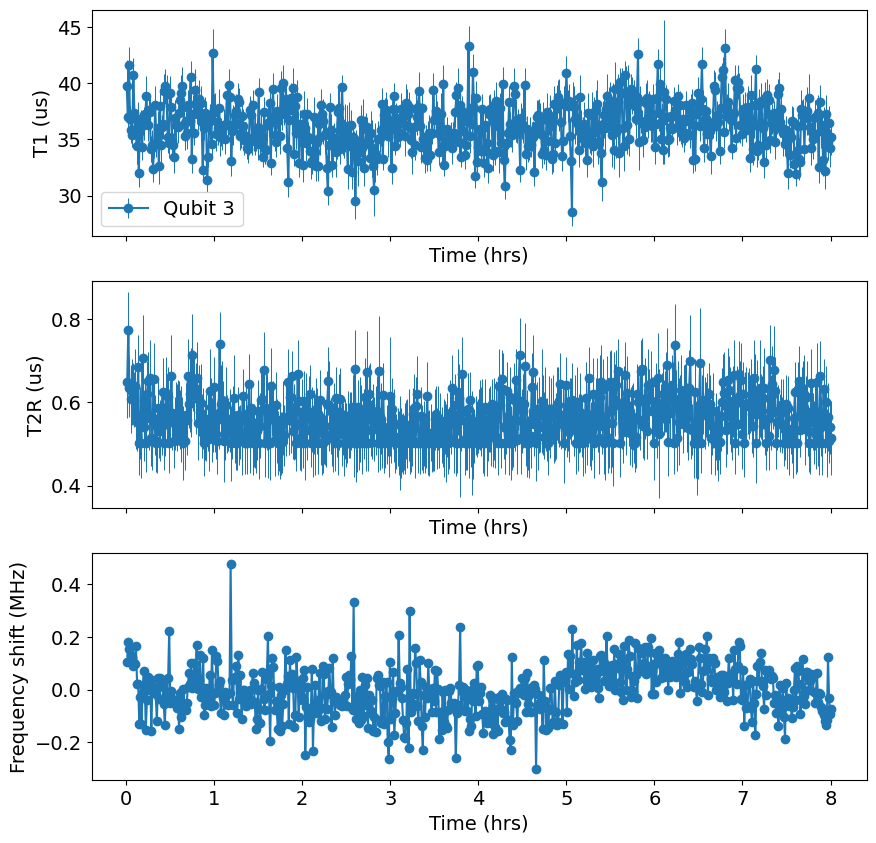

In [30]:
fig, ax = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

for idxq, qubit_i in enumerate(qubits):

    ax[0].errorbar(time_t1_tab[idxq]/60/60, t1_tab[idxq], yerr=t1err_tab[idxq], fmt='o-',  elinewidth=0.75, label=f'Qubit {qubit_i}')
    ax[0].set_ylabel('T1 (us)')
    ax[0].set_xlabel('Time (hrs)')

    ax[1].errorbar(time_t2_tab[idxq]/60/60, t2_tab[idxq], yerr=t2err_tab[idxq], fmt='o-', elinewidth=0.75, label=f'Qubit {qubit_i}')
    ax[1].set_ylabel('T2R (us)')
    ax[1].set_xlabel('Time (hrs)')

    ax[2].plot(time_t2_tab[idxq]/60/60, qb_freq[idxq] - np.mean(qb_freq[idxq]), 'o-', label=f'Qubit {qubit_i}')
    ax[2].set_ylabel('Frequency shift (MHz)')
    ax[2].set_xlabel('Time (hrs)')

ax[0].legend()
